<a href="https://colab.research.google.com/github/ChrisW2420/FedPKDG/blob/main/FedPKDG.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# FedPKDG -- Prune + KD + GAN + FL
This prototype implements the algorithm in a distributed setting
TODO:
1. implement a FedAvg aggregator/server
2. build a centralised FL system with n clients connected to the server
3. design experiments to assess accuracy, efficiency, generalisation on homogenoeous data
4. repeat experiments on heterogeneous data, identical model sparsity
5. repeat experiments on heterogeneous data, different model sparsity, mimicing different computational capability of clients

# Setup and Imports

In [1]:
# NB: package versions are very important
!pip install -q tensorflow-model-optimization # for pruning
!pip install -q git+https://github.com/tensorflow/docs # newest tf
!pip install --upgrade keras #newest keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 5.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.2/311.2 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.3.3 which is incompatible.


In [2]:
# 3 versions of keras are used for different functionalities, imported as different names
import tensorflow as tf
import numpy as np
import tensorflow_model_optimization as tfmot
from tensorflow_model_optimization.sparsity import keras as sparsity
import tf_keras as keras_model #only for pruning
from tf_keras import layers as model_layers
import keras
import tempfile
from tf_keras.callbacks import EarlyStopping, Callback
from keras import ops, layers
from tensorflow_docs.vis import embed # for GAN
import matplotlib.pyplot as plt
from tf_keras.preprocessing.image import ImageDataGenerator

In [3]:
# Logging metrics with WandB

# !pip install wandb
# import wandb
# wandb.login()
# from wandb.keras import WandbMetricsLogger

## Loading Data

In [4]:
# MNIST
# Prepare the train and test dataset.
batch_size = 64
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# Normalize data
x_train = x_train.astype("float32") / 255.0
x_train = np.reshape(x_train, (-1, 28, 28, 1))

x_test = x_test.astype("float32") / 255.0
x_test = np.reshape(x_test, (-1, 28, 28, 1))

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


# Components Implementation

## Model zoo

### CNN

In [5]:
def miniCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="minicnn",
  )
  return model

def smallCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="smallcnn",
  )
  return model

def mediumCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(8, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(16, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="mediumcnn",
  )
  return model

def bigCNN():
  model = keras_model.Sequential(
      [
          keras_model.Input(shape=(28, 28, 1)),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.LeakyReLU(alpha=0.2),
          model_layers.MaxPooling2D(pool_size=(2, 2), strides=(1, 1), padding="same"),
          model_layers.Conv2D(32, (3, 3), strides=(2, 2), padding="same"),
          model_layers.Flatten(),
          model_layers.Dense(10),
      ],
      name="bigcnn",
  )
  return model

### GAN

In [6]:
num_channels = 1
num_classes = 10
image_size = 28
latent_dim = 128 # hyperparam, can tune

generator_in_channels = latent_dim + num_classes
discriminator_in_channels = num_channels + num_classes

# Create the discriminator.
def Discriminator(latent_dim = 128):
  discriminator = keras.Sequential(
      [
          keras.layers.InputLayer((28, 28, discriminator_in_channels)),
          layers.Conv2D(64, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(128, (3, 3), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.GlobalMaxPooling2D(),
          layers.Dense(1),
      ],
      name="discriminator",
  )
  return discriminator

# Create the generator.
def Generator():
  generator = keras.Sequential(
      [
          keras.layers.InputLayer((generator_in_channels,)),
          # We want to generate 128 + num_classes coefficients to reshape into a
          # 7x7x(128 + num_classes) map.
          layers.Dense(7 * 7 * generator_in_channels),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Reshape((7, 7, generator_in_channels)),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding="same"),
          layers.LeakyReLU(negative_slope=0.2),
          layers.Conv2D(1, (7, 7), padding="same", activation="sigmoid"),
      ],
      name="generator",
  )
  return generator

## GAN

In [7]:
class ConditionalGAN(keras.Model):
    def __init__(self, discriminator, generator, latent_dim):
        super().__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.seed_generator = keras.random.SeedGenerator(1337)
        self.gen_loss_tracker = keras.metrics.Mean(name="generator_loss")
        self.disc_loss_tracker = keras.metrics.Mean(name="discriminator_loss")

    @property
    def metrics(self):
        return [self.gen_loss_tracker, self.disc_loss_tracker]

    def compile(self, d_optimizer, g_optimizer, loss_fn):
        super().compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.loss_fn = loss_fn

    def train_step(self, data):
        # Unpack the data.
        real_images, one_hot_labels = data

        # Add dummy dimensions to the labels so that they can be concatenated with
        # the images. This is for the discriminator.
        image_one_hot_labels = one_hot_labels[:, :, None, None]
        image_one_hot_labels = ops.repeat(
            image_one_hot_labels, repeats=[image_size * image_size]
        )
        image_one_hot_labels = ops.reshape(
            image_one_hot_labels, (-1, image_size, image_size, num_classes)
        )

        # Sample random points in the latent space and concatenate the labels.
        # This is for the generator.
        batch_size = ops.shape(real_images)[0]
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Decode the noise (guided by labels) to fake images.
        generated_images = self.generator(random_vector_labels)

        # Combine them with real images. Note that we are concatenating the labels
        # with these images here.
        fake_image_and_labels = ops.concatenate(
            [generated_images, image_one_hot_labels], -1
        )
        real_image_and_labels = ops.concatenate([real_images, image_one_hot_labels], -1)
        combined_images = ops.concatenate(
            [fake_image_and_labels, real_image_and_labels], axis=0
        )

        # Assemble labels discriminating real from fake images.
        labels = ops.concatenate(
            [ops.ones((batch_size, 1)), ops.zeros((batch_size, 1))], axis=0
        )

        # Train the discriminator.
        with tf.GradientTape() as tape:
            predictions = self.discriminator(combined_images)
            d_loss = self.loss_fn(labels, predictions)
        grads = tape.gradient(d_loss, self.discriminator.trainable_weights)
        self.d_optimizer.apply_gradients(
            zip(grads, self.discriminator.trainable_weights)
        )

        # Sample random points in the latent space.
        random_latent_vectors = keras.random.normal(
            shape=(batch_size, self.latent_dim), seed=self.seed_generator
        )
        random_vector_labels = ops.concatenate(
            [random_latent_vectors, one_hot_labels], axis=1
        )

        # Assemble labels that say "all real images".
        misleading_labels = ops.zeros((batch_size, 1))

        # Train the generator (note that we should *not* update the weights
        # of the discriminator)!
        with tf.GradientTape() as tape:
            fake_images = self.generator(random_vector_labels)
            fake_image_and_labels = ops.concatenate(
                [fake_images, image_one_hot_labels], -1
            )
            predictions = self.discriminator(fake_image_and_labels)
            g_loss = self.loss_fn(misleading_labels, predictions)
        grads = tape.gradient(g_loss, self.generator.trainable_weights)
        self.g_optimizer.apply_gradients(zip(grads, self.generator.trainable_weights))

        # Monitor loss.
        self.gen_loss_tracker.update_state(g_loss)
        self.disc_loss_tracker.update_state(d_loss)
        return {
            "g_loss": self.gen_loss_tracker.result(),
            "d_loss": self.disc_loss_tracker.result(),
        }

In [8]:
# image generation functions
def generate_image(generator, target_class, latent_dim):
    noise_matrix = keras.random.normal(shape=(1, latent_dim))
    # Convert the target label to one-hot encoded vectors.
    target_label = keras.utils.to_categorical([target_class], num_classes)
    target_label = ops.cast(target_label, "float32")
    noise_and_labels = ops.concatenate([noise_matrix, target_label], 1)
    fake = generator.predict(noise_and_labels,verbose = 0)
    return fake


def dataAugmentation(x_initial, y_initial, num_augimg, batch_size):
  datagen = ImageDataGenerator(
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.1,
      zoom_range=0.1
  )

  # Create empty arrays to store the augmented data
  augmented_images = np.empty((num_augimg, 28, 28, 1), dtype=np.float32)
  augmented_labels = np.empty((num_augimg,), dtype=np.int64)

  # Generate the augmented dataset
  num_batches = num_augimg // batch_size
  counter = 0

  for x_batch, y_batch in datagen.flow(x_initial, y_initial, batch_size=batch_size):
      augmented_images[counter*batch_size:(counter+1)*batch_size] = x_batch
      augmented_labels[counter*batch_size:(counter+1)*batch_size] = y_batch
      counter += 1
      if counter >= num_batches:
          break

  # Verify the shape of the augmented dataset
  print(f"Augmented dataset shape: {augmented_images.shape}, {augmented_labels.shape}")

  # Optionally, combine the augmented data with the original training data
  combined_images = np.concatenate((x_initial, augmented_images), axis=0)
  combined_labels = np.concatenate((y_initial, augmented_labels), axis=0)
  return combined_images, combined_labels


def pseudoDataset(generator, total_num, latent_dim, is_augment=True, batch_size=64): # producing equal numbers of samples for each class
    pseudo_images = []
    if is_augment:
      total_num = total_num//2
    for num in range(10):
      target_class = num
      print('Generating', int(total_num/10), 'fake images of digit', num, '......')
      for _ in range(int(total_num/10)):
        generated_images = generate_image(generator, target_class, latent_dim)
        generated_images *= 255.0
        converted_images = generated_images.astype(np.uint8)
        converted_images = ops.image.resize(converted_images, (28, 28)).numpy().astype(np.uint8)
        pseudo_images.append(converted_images)
    pseudo_images = np.concatenate(pseudo_images, axis=0)
    x_pseudo = pseudo_images.astype("float32") / 255.0
    x_pseudo = np.reshape(x_pseudo, (-1, 28, 28, 1))
    pseudo_labels = np.repeat(np.arange(10), int(total_num/10))

    if is_augment:
      x_pseudo, pseudo_labels = dataAugmentation(x_pseudo, pseudo_labels, total_num, batch_size) #1:1 augmentation to true ratio

    print('Added', pseudo_labels.shape, 'data points to the public dataset')
    return x_pseudo, pseudo_labels

## Pruning

In [9]:
def prune_finetrain(base_model, _epochs, x, y, target_sparsity, fine_tune_epochs, validation_split=0.1):
  callbacks = [
      sparsity.UpdatePruningStep(),
      early_stopping
  ]
  steps_per_epoch = len(x)*(1-validation_split) // batch_size
  if fine_tune_epochs<_epochs:
    begin_step=int(steps_per_epoch*fine_tune_epochs)
  end_step=int(steps_per_epoch*_epochs)+1
  print('begin_step=', begin_step, 'end_step=', end_step)
  pruning_schedule = sparsity.PolynomialDecay(initial_sparsity=0, final_sparsity=target_sparsity,
                                              begin_step=begin_step, end_step=end_step) # TODO: tune begin_step, consider fining training before starting to prune

  model_for_pruning = sparsity.prune_low_magnitude(base_model, pruning_schedule=pruning_schedule) #default constant sparsity of 50%

  model_for_pruning.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
  )

  model_for_pruning.fit(
      x,
      y,
      batch_size=batch_size,
      validation_split=validation_split,
      callbacks=callbacks,
      epochs=_epochs,
  )
  pruned_model = sparsity.strip_pruning(model_for_pruning)

  return pruned_model


# Model size metrics

def get_model_sparsity(model):
    total_weights = 0
    zero_weights = 0
    for weight in model.get_weights():
        total_weights += weight.size
        zero_weights += np.count_nonzero(weight == 0)
    return zero_weights / total_weights

def get_gzipped_model_size(model):
  # Returns size of gzipped model, in bytes.
  import os
  import zipfile

  _, keras_file = tempfile.mkstemp('.h5')
  model.save(keras_file, include_optimizer=False)

  _, zipped_file = tempfile.mkstemp('.zip')
  with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
    f.write(keras_file)

  return os.path.getsize(zipped_file)

## Knowledge Distillation

In [10]:
class Distiller(keras_model.Model):
    def __init__(self, get_teacher_logits, student, alpha=0.1, temperature=3, **kwargs):
        super(Distiller, self).__init__(**kwargs)
        self.student = student
        self.get_teacher_logits = get_teacher_logits

    def compile(self, optimizer, metrics, student_loss_fn, distillation_loss_fn, alpha, temperature, **kwargs):
        super(Distiller, self).compile(optimizer=optimizer, metrics=metrics, **kwargs)
        self.student_loss_fn = student_loss_fn
        self.student.compile(optimizer=optimizer, metrics=metrics, loss=self.student_loss_fn)
        self.distillation_loss_fn = distillation_loss_fn
        self.alpha = alpha
        self.temperature = temperature

    def train_step(self, data):
        # Unpack the data
        x, y = data

        teacher_predictions = self.get_teacher_logits(x)

        with tf.GradientTape() as tape:
            # Forward pass of the student
            student_predictions = self.student(x, training=True)

            # Calculate the task-specific loss
            task_loss = self.student_loss_fn(y, student_predictions)

            # Calculate the soft targets and the distillation loss
            soft_targets = tf.nn.softmax(teacher_predictions / self.temperature)

            student_soft = tf.nn.softmax(student_predictions / self.temperature)
            distillation_loss = self.distillation_loss_fn(soft_targets, student_soft)

            # Calculate the total loss
            total_loss = (1 - self.alpha) * task_loss + self.alpha * distillation_loss * (self.temperature ** 2)

        # Compute gradients and update weights
        trainable_vars = self.student.trainable_variables
        gradients = tape.gradient(total_loss, trainable_vars)
        self.optimizer.apply_gradients(zip(gradients, trainable_vars))

        # Update metrics
        self.compiled_metrics.update_state(y, student_predictions)
        results = {m.name: m.result() for m in self.metrics}
        results.update({"task_loss": task_loss, "distillation_loss": distillation_loss, "total_loss": total_loss})
        return results

    def test_step(self, data):
        # Unpack the data
        x, y = data

        # Forward pass of the student
        y_pred = self.student(x, training=False)

        # Calculate the task-specific loss
        task_loss = self.student_loss_fn(y, y_pred)

        # Update the metrics
        self.compiled_metrics.update_state(y, y_pred)
        return {m.name: m.result() for m in self.metrics}

    def call_model(self):
      return self.student

# Helper Function Implementation

TODO:
Dataset:
- Dataloader
- heterogeneous dataset partition
- data augmentation

visualisation:
- dataset example visualisation
- data distribution visualisation
- confusion matrix
-

In [11]:
def set_model_weights_to_zero(model):
    for layer in model.layers:
        zero_weights = [np.zeros_like(w) for w in layer.get_weights()]
        layer.set_weights(zero_weights)
    return model

In [12]:
def if_synced(model1, model2):
    for layer1, layer2 in zip(model1.layers, model2.layers):
          weights1 = layer1.get_weights()
          weights2 = layer2.get_weights()
          for w1, w2 in zip(weights1, weights2):
              if not np.array_equal(w1, w2):
                  print('different weights, syncing failed')
    print('weights synced for client')

## Callback zoo

In [13]:
early_stopping = EarlyStopping(
    monitor='val_loss', #default to val_loss
    min_delta=0.001,  # only consider as improvement significant changes
    patience=2,      # number of epochs with no improvement after which training will be stopped
    verbose=1,
    mode='min'        # 'min' because we want to minimize the loss
    )

# Client

In [14]:
class Client(): #TODO: add name to clients to refer to them, espeically during logging
  def __init__(self, model_fn, x_train, y_train, **kwargs): #generator = None, discriminator = None, self.latent_dim = 128
    self.cnn = model_fn
    self.generator = Generator()
    self.discriminator = Discriminator()
    self.latent_dim = 128
    self.x_private = x_train
    self.y_private = y_train
    self.batch_size = 64 # hyperparam, can tune
    self.validation_split=0.1

  def train_cnn(self, epochs = 5, is_prune = False, target_sparsity = 0.3, fine_tune_epochs = 0, is_earlystop=True, **kwargs):
    if is_prune:
      print('from gloabl - before pruning client has sparsity', get_model_sparsity(self.cnn))
      self.cnn = prune_finetrain(self.cnn, _epochs = epochs, x = self.x_private, y = self.y_private, target_sparsity = target_sparsity, fine_tune_epochs = fine_tune_epochs) # fine_tune_epochs can take decimals, starts pruning after fine tune
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      print('after pruning client has sparsity', get_model_sparsity(self.cnn))
    else:
      self.cnn.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )
      callbacks=[]
      if is_earlystop:
        callbacks=[early_stopping]
      self.cnn.fit(self.x_private, self.y_private, batch_size=batch_size, epochs=epochs,validation_split=self.validation_split, callbacks=callbacks)

  def train_gen(self, epochs = 20, d_learning_rate = 0.0003, g_learning_rate = 0.0003, is_earlystop=True):
    cond_gan = ConditionalGAN(self.discriminator, self.generator, self.latent_dim)
    cond_gan.compile(
        d_optimizer=keras.optimizers.Adam(d_learning_rate),
        g_optimizer=keras.optimizers.Adam(g_learning_rate),
        loss_fn=keras.losses.BinaryCrossentropy(from_logits=True),
    )
    callbacks=[]
    if is_earlystop:
      gan_early_stopping = EarlyStopping(
      monitor='g_loss',
      min_delta=0.0005,
      patience=2,
      verbose=1,
      mode='min'
      )
      callbacks=[gan_early_stopping]
    # produce GAN training dataset
    train_label = keras.utils.to_categorical(self.y_private, 10) # 1 hot encoding label
    dataset = tf.data.Dataset.from_tensor_slices((self.x_private, train_label))
    dataset = dataset.shuffle(buffer_size=1024).batch(batch_size)
    cond_gan.fit(dataset, epochs=epochs, callbacks=callbacks)


  ## the following code act as interface with the server, avoid direct access to private model and dataset

  def produce_logits(self, x): #for KD
    logits = self.cnn(x, training=False)
    print('----getting 1 client logits')
    return logits

  def get_cnn_weights(self): #only for FedAvg, disabled
    return self.cnn.get_weights()

  def get_cnn_classifier(self):
    return self.cnn.layers[-1].get_weights()

  def set_cnn_weights(self, weights): #for downloading global weights
    self.cnn.set_weights(weights)

  def get_gen_weights(self): #only for FedAvg, disabled
    return self.generator.get_weights()

  def set_gen_weights(self, weights): #for downloading global weights
    self.generator.set_weights(weights)

  def get_datasize(self):
    return self.x_private.shape[0]

# Server

In [15]:
class Server():
  def __init__(self, model_fn, client_list, comm_freq = 1, algo = 'FedAvg', **kwargs): #generator = None,
    self.cnn = model_fn
    self.client_list = client_list # calling this param when "uploading" or "downloading"
    self.client_datasize = []
    self.generator = Generator()
    self.latent_dim = 128 # hyperparam, can tune
    self.x_public = np.array([]) # to generate
    self.y_public = np.array([]) # to generate
    self.batch_size = 64 # hyperparam, can tune
    self.comm_freq = comm_freq # no. of client local training epochs before upload

    # default settings for FedAvg
    self.is_prune = False
    self.is_simKD = False

    if algo == 'FedPKDG':
    # turn on FedPKDG
      self.is_prune = True
      self.is_simKD = True

  def get_client_datasize(self):
    if len(self.client_datasize) != len(self.client_list):
      for i in range(len(self.client_datasize), len(self.client_list)):
        self.client_datasize.append(self.client_list[i].get_datasize())
    return self.client_datasize

  def assign_weights_cnn(self, client):
    client.set_cnn_weights(self.cnn.get_weights())

  def assign_weights_gen(self, client):
    client.set_gen_weights(self.generator.get_weights())

  def broadcast(self):
    # TODO: improve: can use tff.federated_map and tff.federated_broadcast, can combine the two assign fns
    for client in self.client_list:
        self.assign_weights_cnn(client)
    for client in self.client_list:
        self.assign_weights_gen(client)

  def local_training(self, cnn_epochs=None, target_sparsity=0.3, fine_tune_epochs = 0, gen_epochs=None, is_earlystop=True):
    for idx, client in enumerate(self.client_list):
      # train the cnn
      print('training client', idx, '\'s CNN')
      if cnn_epochs!=0:
        if not cnn_epochs:
          cnn_epochs = self.comm_freq
        client.train_cnn(epochs = cnn_epochs, is_prune = self.is_prune, target_sparsity=target_sparsity, fine_tune_epochs = fine_tune_epochs, is_earlystop=is_earlystop)
      # train the generator
      print('training client', idx, '\'s GEN')
      if gen_epochs!=0:
        if not gen_epochs:
          gen_epochs = self.comm_freq
        client.train_gen(epochs = gen_epochs, is_earlystop=is_earlystop)

  def weighted_average(self, type_of_value ,output):
    print('----getting weighted avg of clients\'', type_of_value)
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
        p_k = p[client_idx]/total_size
        if type_of_value == 'cnn':
          client_val = client.get_cnn_weights()
        elif type_of_value == 'gen':
          client_val = client.get_gen_weights()
        elif type_of_value == 'classifier':
          client_val = client.get_cnn_classifier()
        for val_idx, value in enumerate(client_val):
          output[val_idx] += p_k * value
    return output

  def agg_cnn(self):
    global_weights = [np.zeros_like(w) for w in self.cnn.get_weights()]
    global_weights = self.weighted_average('cnn', global_weights)
    # Set the updated weights to the global model
    self.cnn.set_weights(global_weights)

  def agg_classifier(self):
    # !!TODO: to test, can use tff.federated_mean
    global_weights = [np.zeros_like(w) for w in self.cnn.layers[-1].get_weights()]
    global_weights = self.weighted_average('classifier', global_weights)
    # Set the updated weights to the global model
    self.cnn.layers[-1].set_weights(global_weights)
    self.cnn.layers[-1].trainable = False

  def agg_gen(self):
    global_weights = [np.zeros_like(w) for w in self.generator.get_weights()]
    global_weights = self.weighted_average('gen', global_weights)
    # Set the updated weights to the global model
    self.generator.set_weights(global_weights)

  def produce_pseudo_dataset(self, total_num = None):
    # generate with gen, homogenous data: equal number of datapoints for each class
    #TODO: test pseudoDataset
    if total_num == None:
      total_num = min(self.client_datasize)
    if self.x_public.size==0:
      self.x_public, self.y_public = pseudoDataset(generator=self.generator, total_num=total_num, latent_dim=self.latent_dim)
    else:
      new_x, new_y = pseudoDataset(generator=self.generator, total_num=5*self.batch_size, latent_dim=self.latent_dim)
      self.x_public = np.concatenate((self.x_public, new_x), axis=0)
      self.y_public = np.concatenate((self.y_public, new_y), axis=0)

  def agg_logits(self, data):
    # mimics clients sending their logits to the server given the same input
    p = self.get_client_datasize()
    total_size = sum(p)
    for client_idx, client in enumerate(self.client_list):
      p_k = p[client_idx]/total_size
      if client_idx == 0:
        logits = p_k * client.produce_logits(data)
      else:
        logits += p_k * client.produce_logits(data)
    print('----getting aggregate client logits',logits)
    return logits

  def distill_to_global(self, epochs=3):
    #!!!TODO: test distillation based on the public_dataset and agg_logits
    if self.is_simKD:
      self.agg_classifier()
    distiller = Distiller(get_teacher_logits = self.agg_logits, student = self.cnn)
    distiller.compile(
      optimizer=keras_model.optimizers.Adam(),
      metrics=[keras_model.metrics.SparseCategoricalAccuracy()],
      student_loss_fn=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
      distillation_loss_fn=keras_model.losses.KLDivergence(),
      alpha=0.4,
      temperature=3,
    )
    # Distill teacher to student
    distiller.fit(self.x_public, self.y_public, epochs=epochs, validation_split=0.1)

    print('should print not trainable:', self.cnn.layers[-1].trainable)
    self.cnn.layers[-1].trainable = True
    print('should print trainable:', self.cnn.layers[-1].trainable)

# Testing Functionality

NB: re-run the server block before every experiment to avoid error: Server class not callable

## FedAvg (Don't Touch)

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1)

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  client.cnn.evaluate(x_test, y_test)

Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.8666 - sparse_categorical_accuracy: 0.7477 - val_loss: 0.3297 - val_sparse_categorical_accuracy: 0.9050
training client 1 's cnn
282/282 [==============================] - 5s 11ms/step - loss: 0.8512 - sparse_categorical_accuracy: 0.7609 - val_loss: 0.3672 - val_sparse_categorical_accuracy: 0.8970
training client 2 's cnn
282/282 [==============================] - 7s 19ms/step - loss: 0.8463 - sparse_categorical_accuracy: 0.7662 - val_loss: 0.2613 - val_sparse_categorical_accuracy: 0.9210
trained all clients cnn round 0
Weighted aggregated client weights
Broadcasted weights to all clients
training client 0 's cnn
282/282 [==============================] - 6s 14ms/step - loss: 0.3540 - sparse_categorical_accuracy: 0.8938 - val_loss: 0.2673 - val_sparse_categorical_accuracy: 0.9210
training client 1 's cnn
282/282 [==============================] - 6s 12ms/step - 

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs=3)
client.cnn.evaluate(x_test, y_test)

Epoch 1/3
282/282 [==============================] - 5s 14ms/step - loss: 0.7805 - sparse_categorical_accuracy: 0.7734 - val_loss: 0.3458 - val_sparse_categorical_accuracy: 0.9010
Epoch 2/3
282/282 [==============================] - 3s 12ms/step - loss: 0.3653 - sparse_categorical_accuracy: 0.8892 - val_loss: 0.2914 - val_sparse_categorical_accuracy: 0.9185
Epoch 3/3
313/313 [==============================] - 1s 3ms/step - loss: 0.2903 - sparse_categorical_accuracy: 0.9135


[0.29031461477279663, 0.9135000109672546]

comment: model quickly overfit to bad training data even after syncing weights, need to prevent this

## Just Pruning (Don't Touch)

In [ ]:
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 1, algo = 'FedPKDG')

for _ in range(3):
  Server.broadcast()
  print('Broadcasted weights to all clients')
  Server.local_training()
  print('trained all clients cnn round', _)
  Server.agg_cnn()
  print('Weighted aggregated client weights')

for client in client_list:
  get_model_sparsity(client.cnn)
  client.cnn.evaluate(x_test, y_test)

after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
after broadcasting client has sparsity 0.0056595559425337396
Broadcasted weights to all clients
training client 0 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 13ms/step - loss: 0.8240 - sparse_categorical_accuracy: 0.7577 - val_loss: 0.3441 - val_sparse_categorical_accuracy: 0.8970
training client 1 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 9s 18ms/step - loss: 0.8242 - sparse_categorical_accuracy: 0.7551 - val_loss: 0.4127 - val_sparse_categorical_accuracy: 0.8890
training client 2 's cnn
begin_step= 0 end_step= 282
282/282 [==============================] - 7s 12ms/step - loss: 0.8215 - sparse_categorical_accuracy: 0.7543 - val_loss: 0.2855 - val_sparse_categorical_accuracy: 0.9250
trained all clients cnn round 0
before agg client 0 has sparsity 0.4849804092294297
before agg client 1 has spars

In [ ]:
x_train_k = x_train[:no_sample]
y_train_k = y_train[:no_sample]
client = Client(smallCNN(), x_train_k, y_train_k)
client.local_train(epochs = 3, is_prune = True)
client.cnn.evaluate(x_test, y_test)

begin_step= 0 end_step= 844
Epoch 1/3
282/282 [==============================] - 7s 12ms/step - loss: 0.8385 - sparse_categorical_accuracy: 0.7484 - val_loss: 0.3486 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/3
282/282 [==============================] - 4s 15ms/step - loss: 0.3786 - sparse_categorical_accuracy: 0.8857 - val_loss: 0.2972 - val_sparse_categorical_accuracy: 0.9150
Epoch 3/3
313/313 [==============================] - 2s 3ms/step - loss: 0.3094 - sparse_categorical_accuracy: 0.9068


[0.30936574935913086, 0.9067999720573425]

## Script for FedPKDG

In [ ]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 2, algo='FedPKDG')

total_rounds = 3
for round in range(total_rounds):
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  if round == 0:
    Server.local_training(gen_epochs=10,target_sparsity = target_sparsity)
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset(total_num = 2000)
  else:
    Server.local_training()
    print('>>>>>>>>>trained all clients cnn round', _)
    Server.agg_gen()
    print('>>>>>>>>>Weighted aggregated client generator')
    Server.produce_pseudo_dataset()
    print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 0 end_step= 563
Epoch 1/2
282/282 [==============================] - 5s 7ms/step - loss: 0.8455 - sparse_categorical_accuracy: 0.7486 - val_loss: 0.3442 - val_sparse_categorical_accuracy: 0.8985
Epoch 2/2
282/282 [==============================] - 2s 5ms/step - loss: 0.3719 - sparse_categorical_accuracy: 0.8879 - val_loss: 0.3011 - val_sparse_categorical_accuracy: 0.9135
after pruning client has sparsity 0.0
training client 0 's GEN
Epoch 1/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - d_loss: 0.4390 - g_loss: 1.4507
Epoch 2/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - d_loss: 0.3727 - g_loss: 1.4628
Epoch 3/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.5172 - g_loss: 1.2452
Epoch 4/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.5640 - g_loss: 1.1373
Epoch 5/10
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_los

## FL on Generator only (Don't Touch)

it was seen that the aggregated generator produces blurry and unidentifiable results whilst the client generators perform well. Fixed this and improve the performance of global generator

training client 0 's CNN
training client 0 's GEN
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - d_loss: 0.5157 - g_loss: 1.2633
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 22ms/step - d_loss: 0.4038 - g_loss: 1.3320
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.3476 - g_loss: 1.8053
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4751 - g_loss: 1.4209
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4577 - g_loss: 1.3890
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4582 - g_loss: 1.3604
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4214 - g_loss: 1.5891
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3748 - g_loss: 1.6951
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4298 - g_loss: 1.6192
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3978 - g_loss: 1.7306
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3130 - g

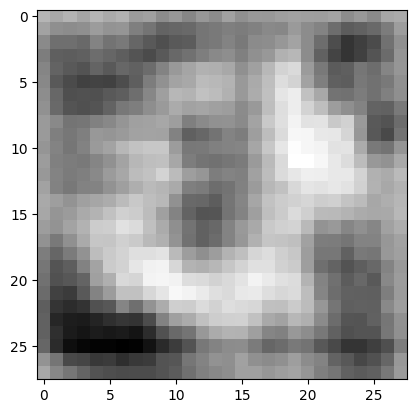

Global 0


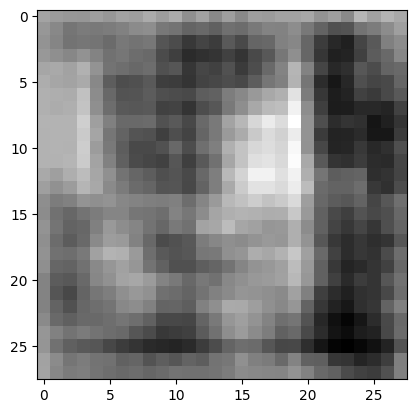

Global 1


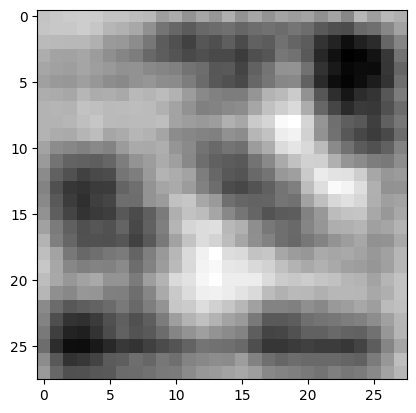

Global 2


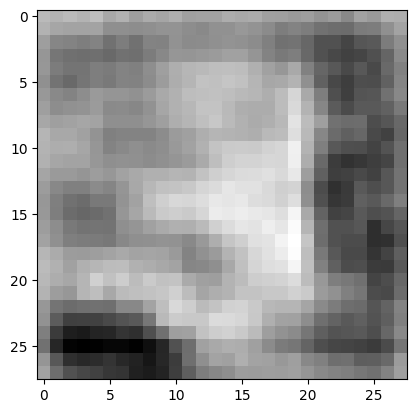

Global 3


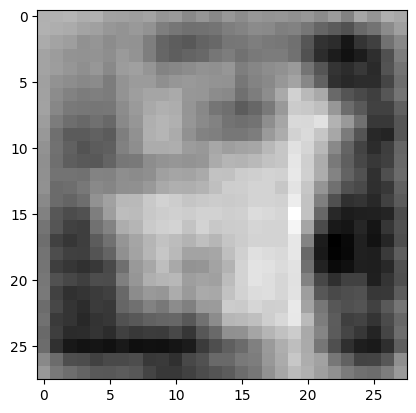

Global 4


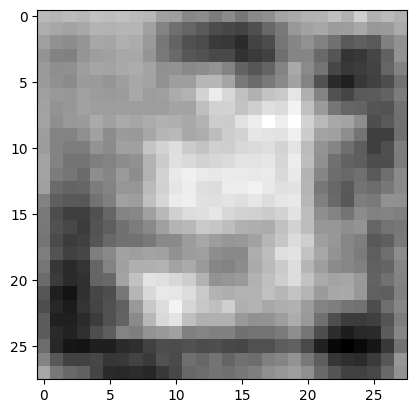

Global 5


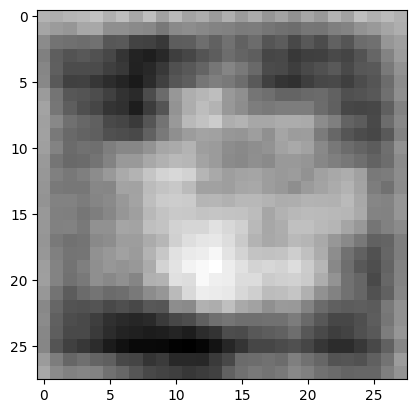

Global 6


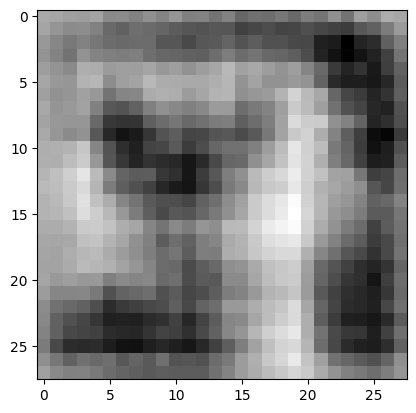

Global 7


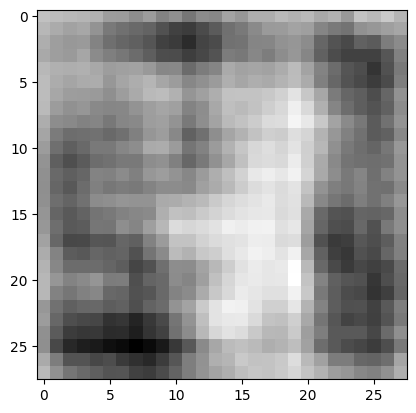

Global 8


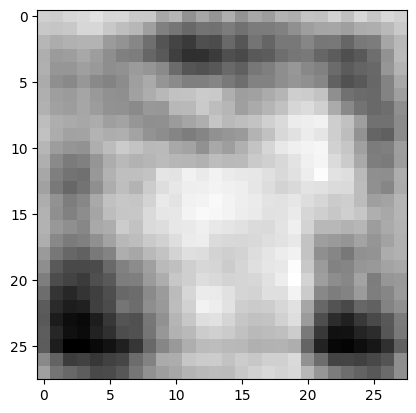

Global 9


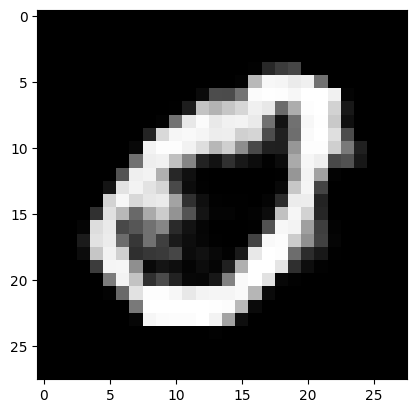

Client 0


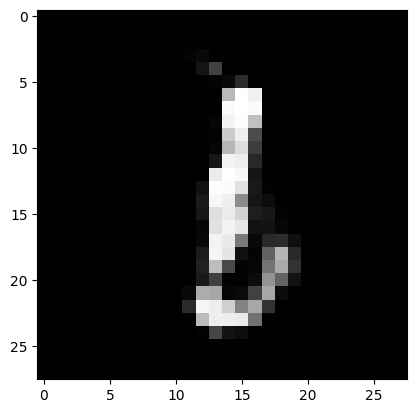

Client 1


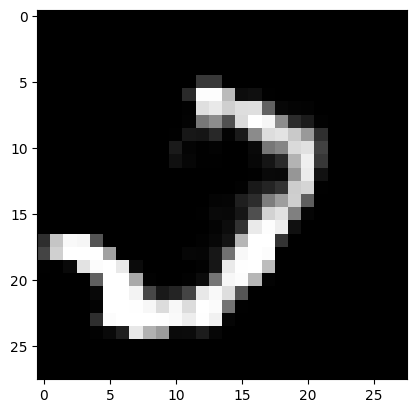

Client 2


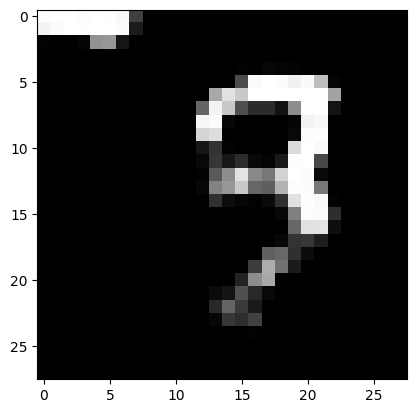

Client 3


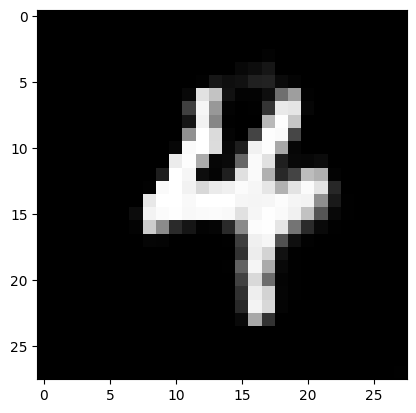

Client 4


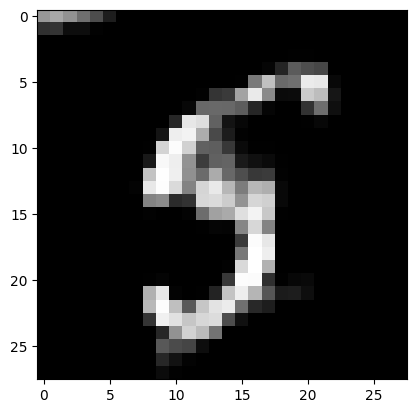

Client 5


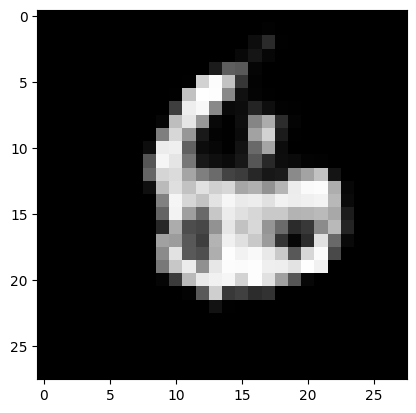

Client 6


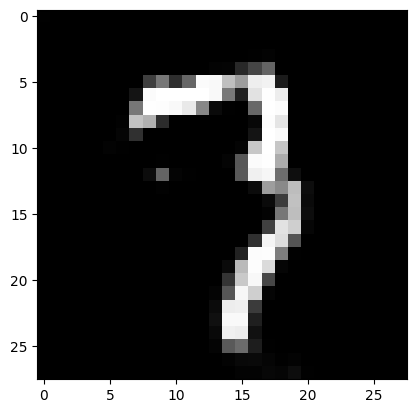

Client 7


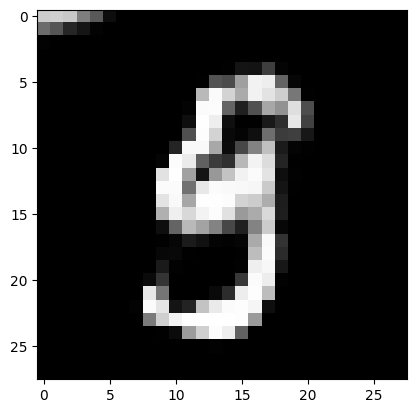

Client 8


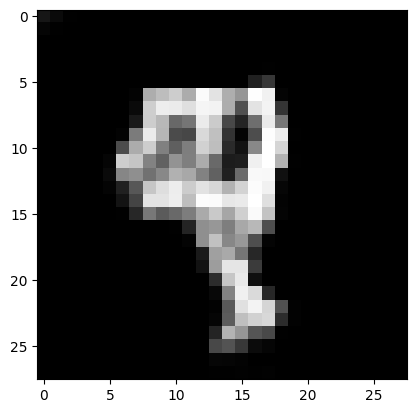

Client 9


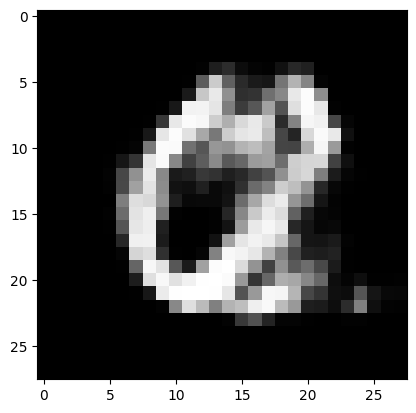

Client 0


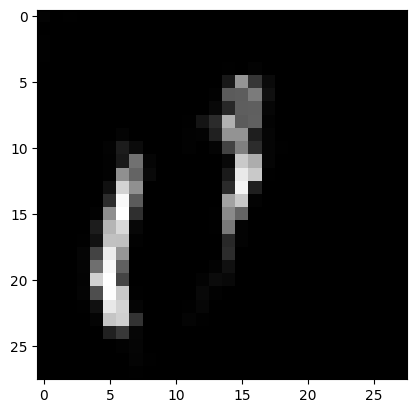

Client 1


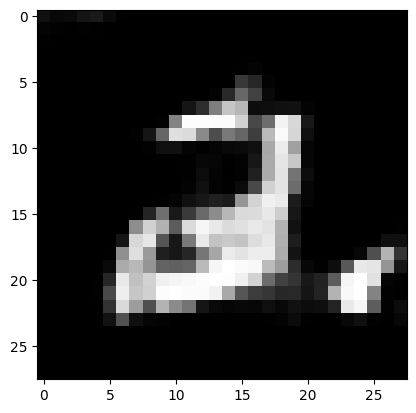

Client 2


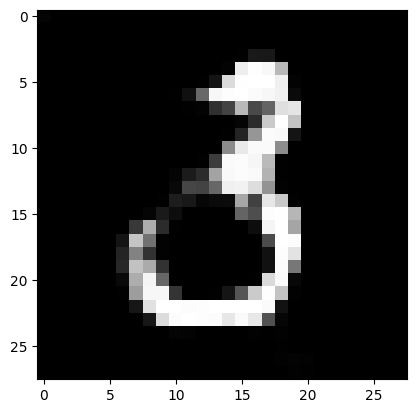

Client 3


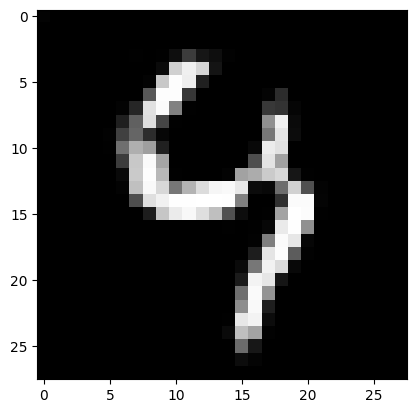

Client 4


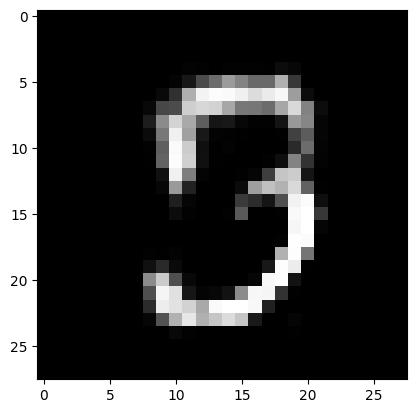

Client 5


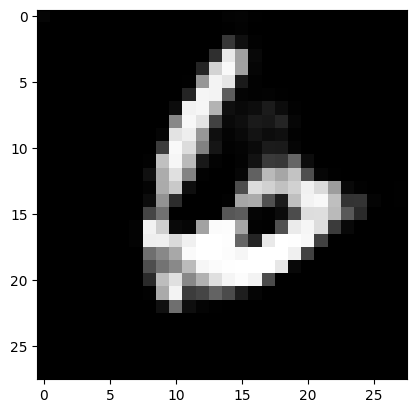

Client 6


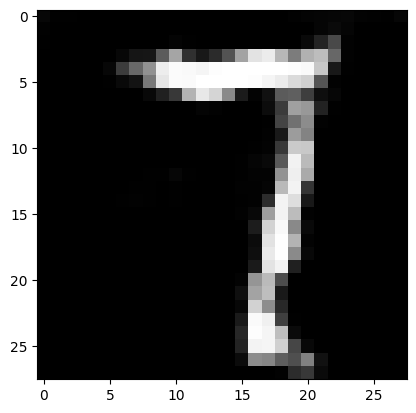

Client 7


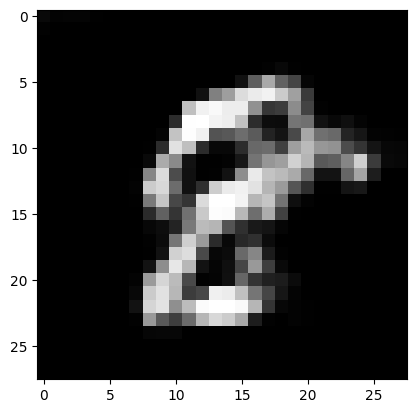

Client 8


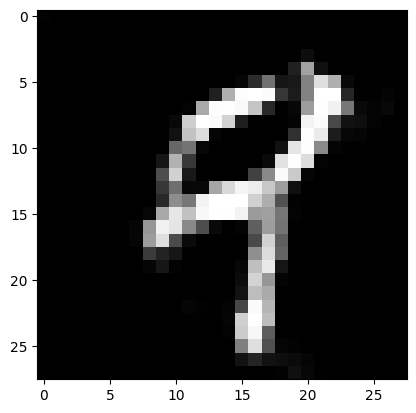

Client 9


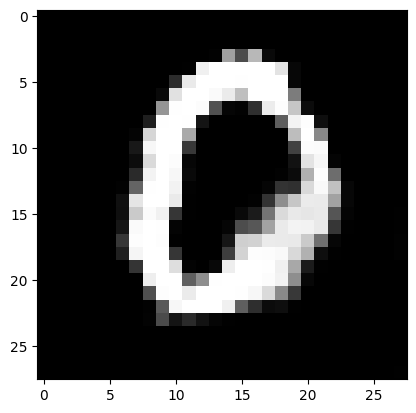

Client 0


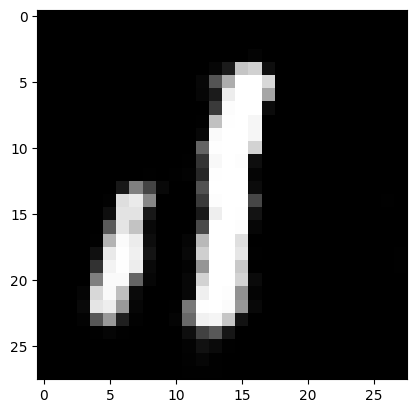

Client 1


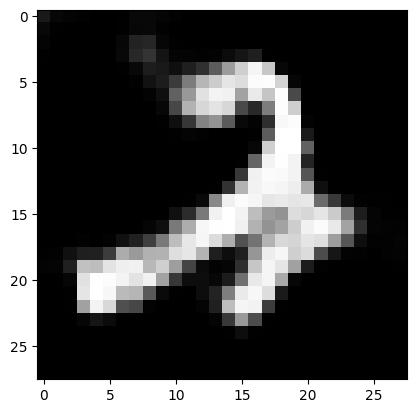

Client 2


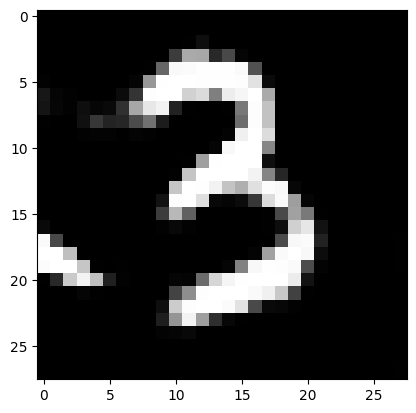

Client 3


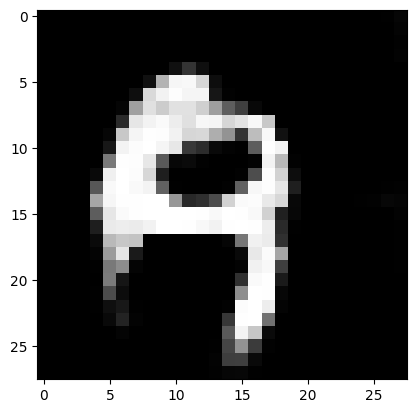

Client 4


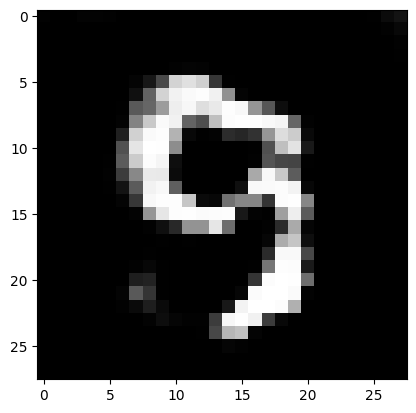

Client 5


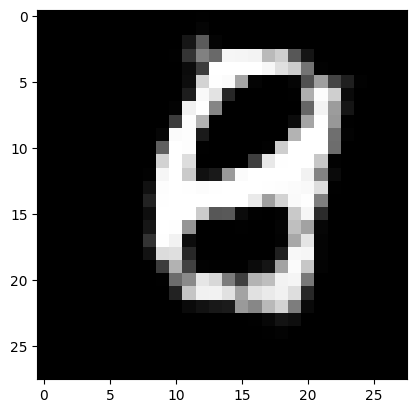

Client 6


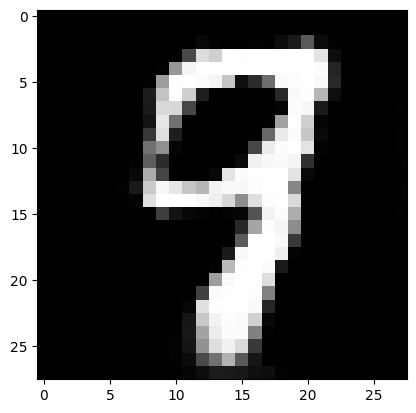

Client 7


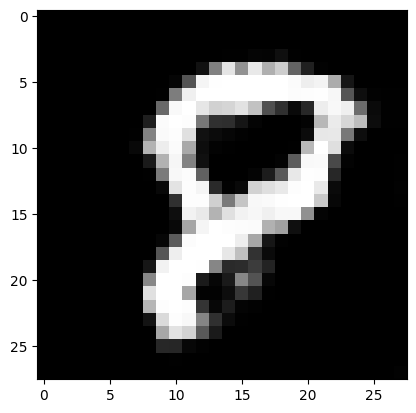

Client 8


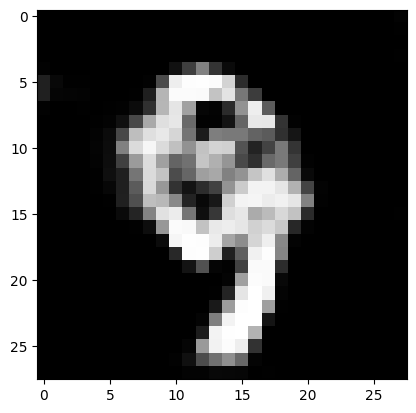

Client 9
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
training client 0 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - d_loss: 0.2869 - g_loss: 2.2212
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 25ms/step - d_loss: 0.5547 - g_loss: 1.2746
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6099 - g_loss: 1.0957
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.6164 - g_loss: 1.0706
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6033 - g_loss: 1.0796
training client 1 's CNN
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 36ms/step - d_loss: 0.2923 - g_loss: 2.0874
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.5235 - g_loss: 1.3390
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.5745 - g_loss: 1.1917
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.6434 - g_loss: 0.9896
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.640

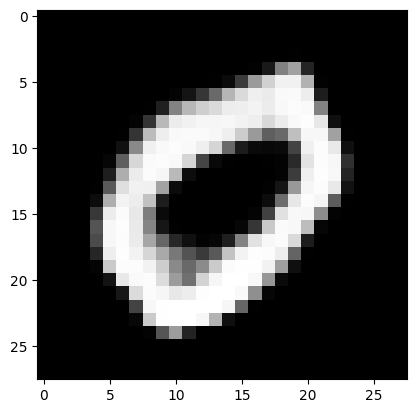

Global 0


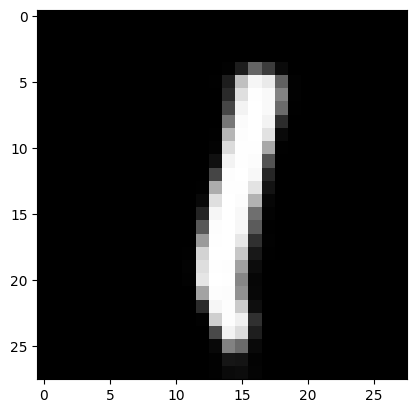

Global 1


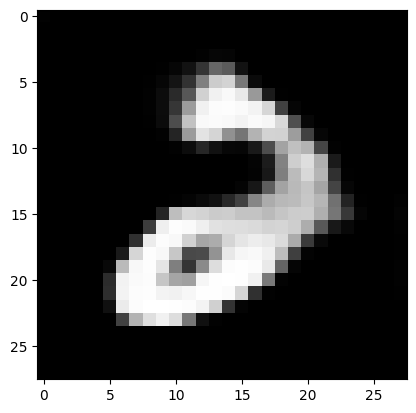

Global 2


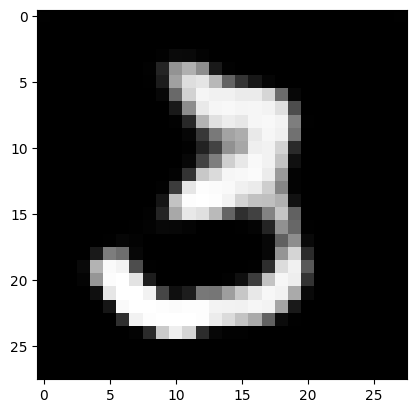

Global 3


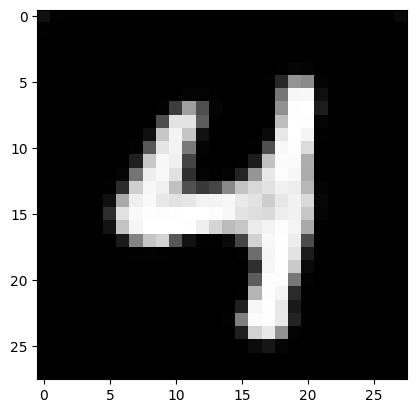

Global 4


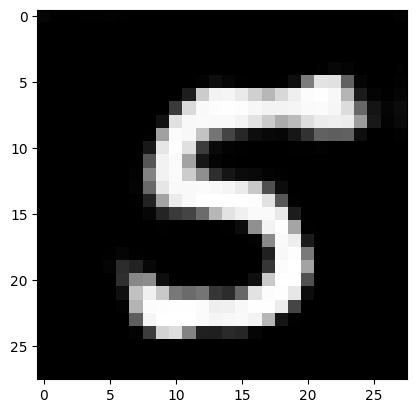

Global 5


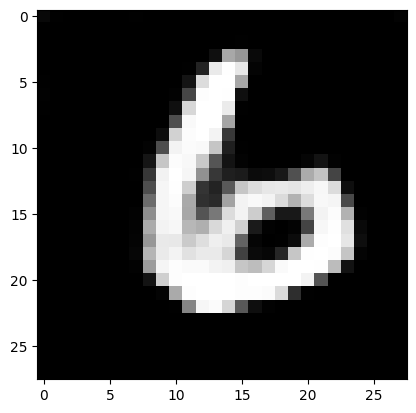

Global 6


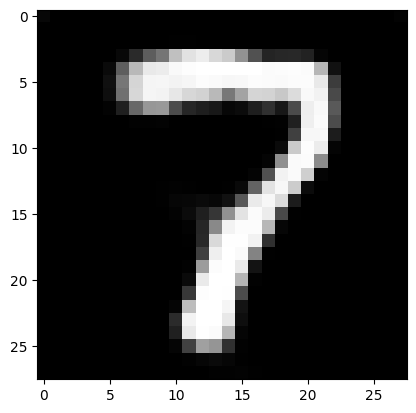

Global 7


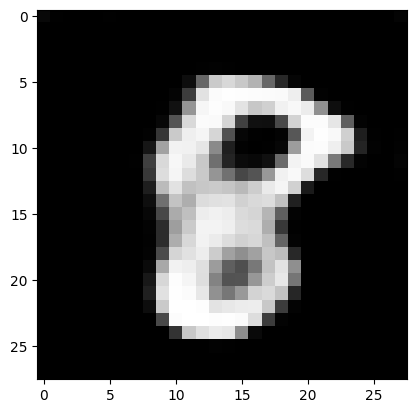

Global 8


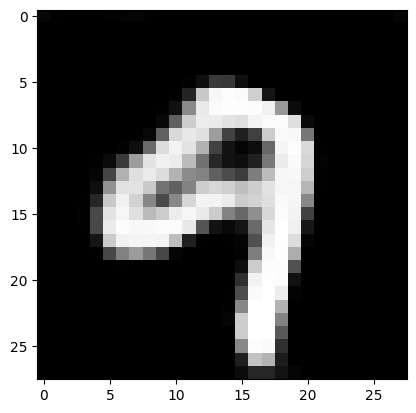

Global 9


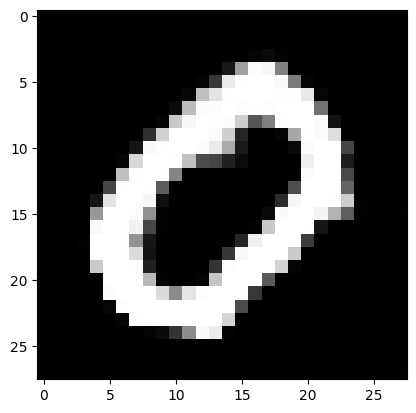

Client 0


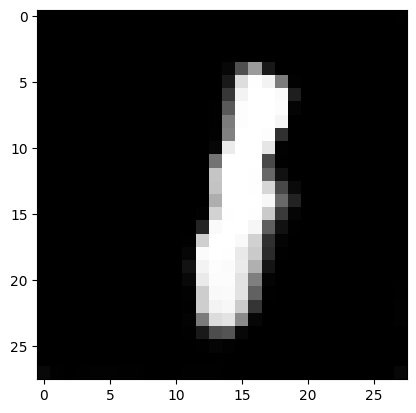

Client 1


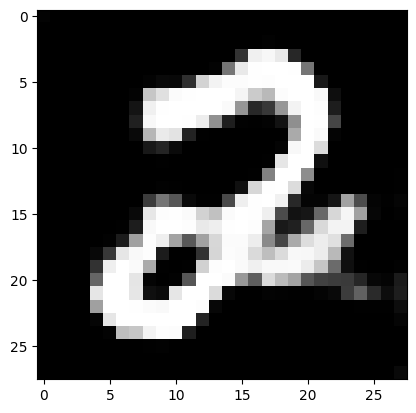

Client 2


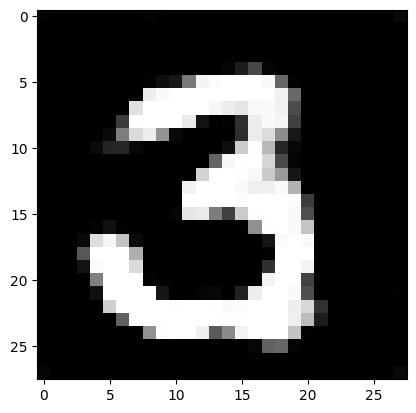

Client 3


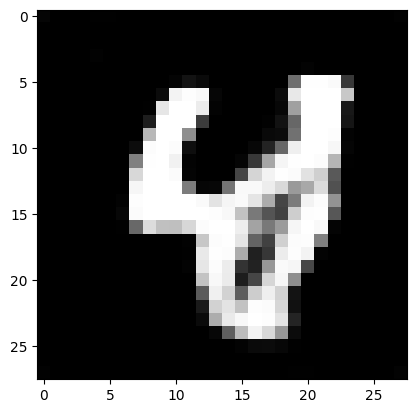

Client 4


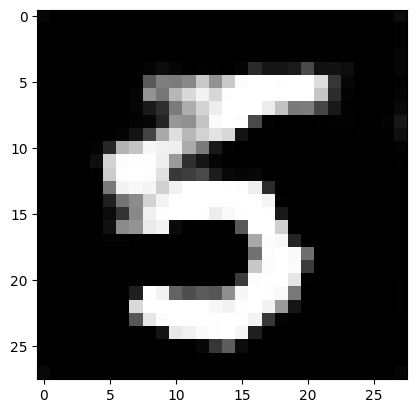

Client 5


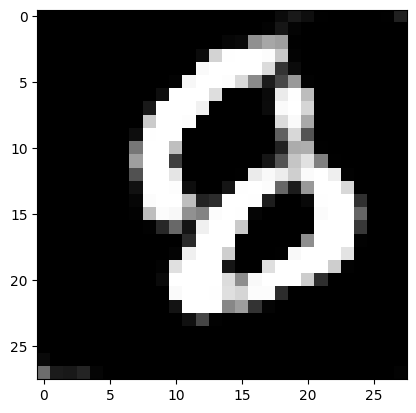

Client 6


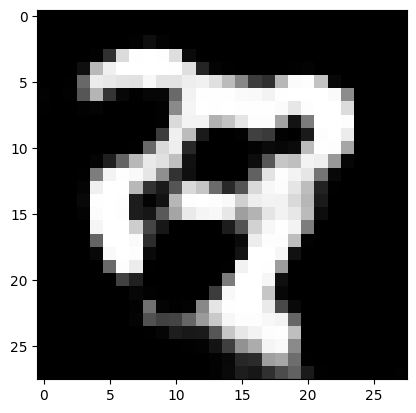

Client 7


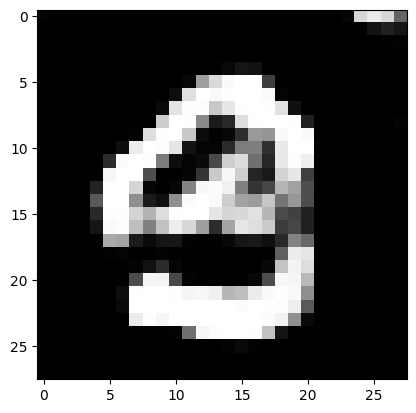

Client 8


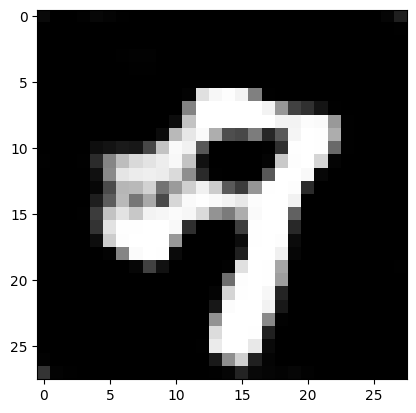

Client 9


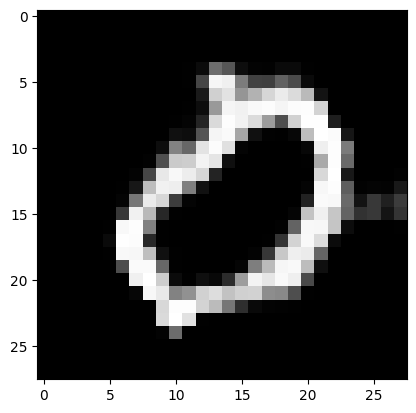

Client 0


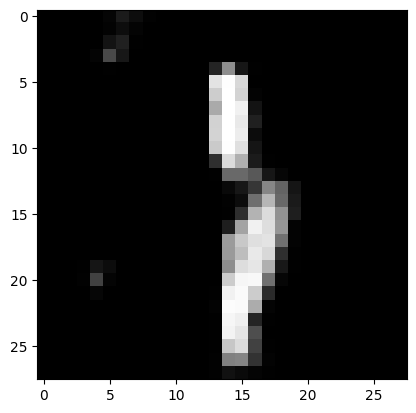

Client 1


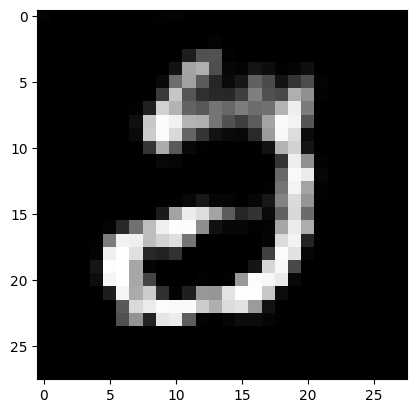

Client 2


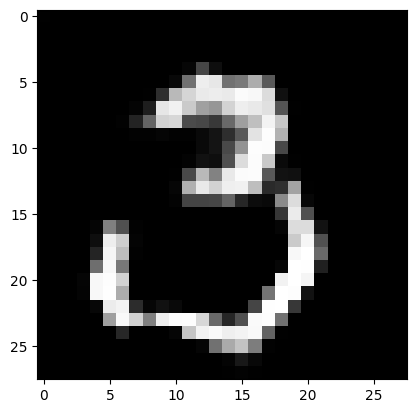

Client 3


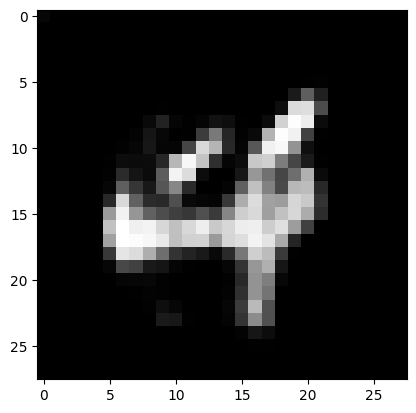

Client 4


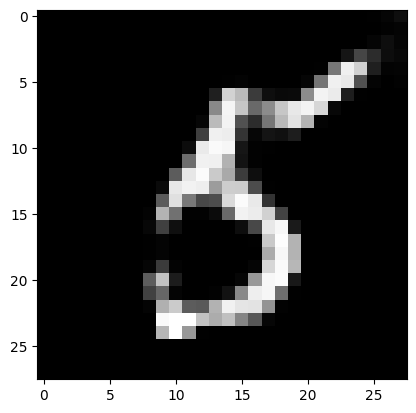

Client 5


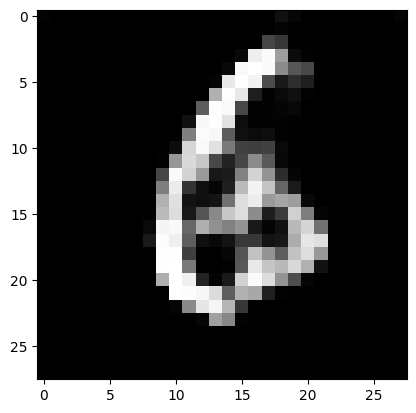

Client 6


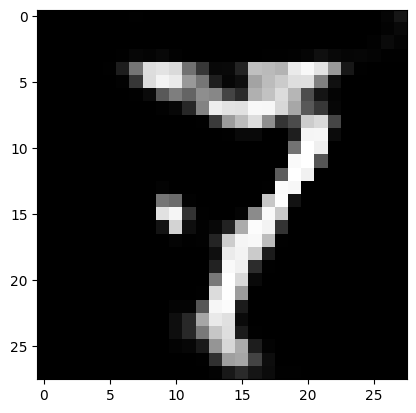

Client 7


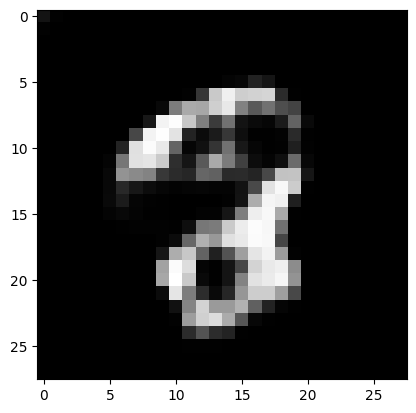

Client 8


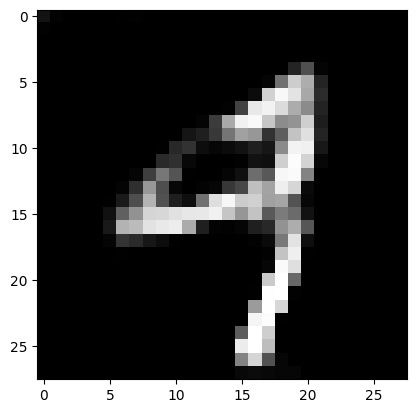

Client 9


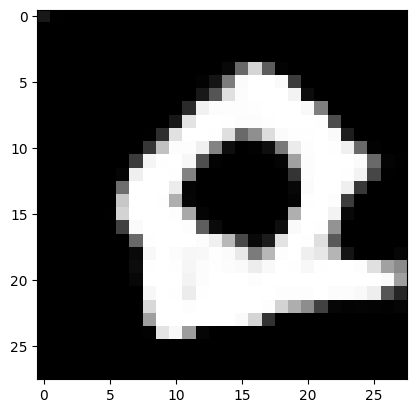

Client 0


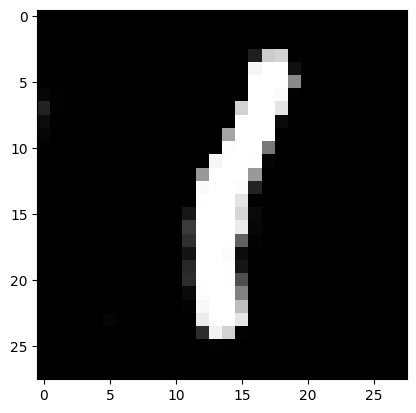

Client 1


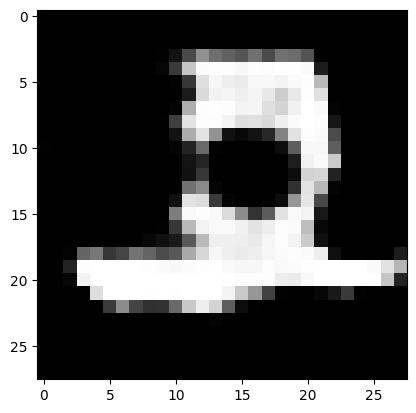

Client 2


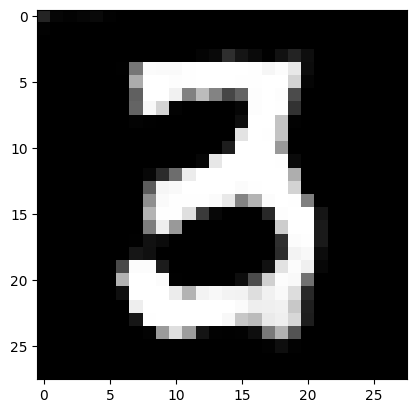

Client 3


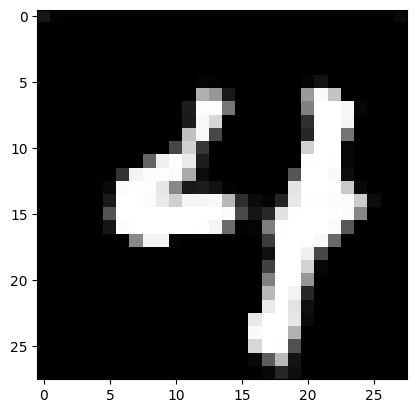

Client 4


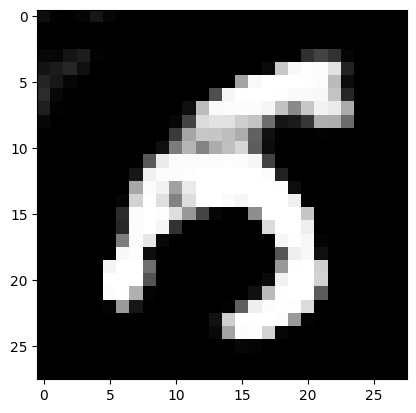

Client 5


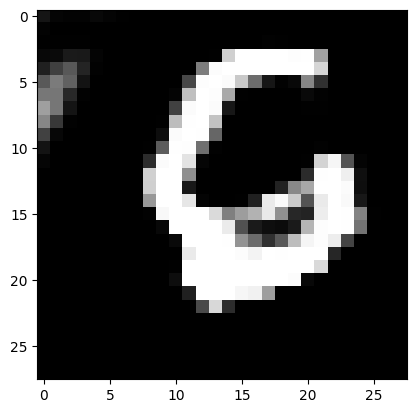

Client 6


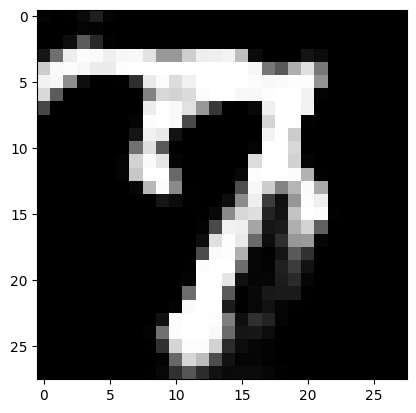

Client 7


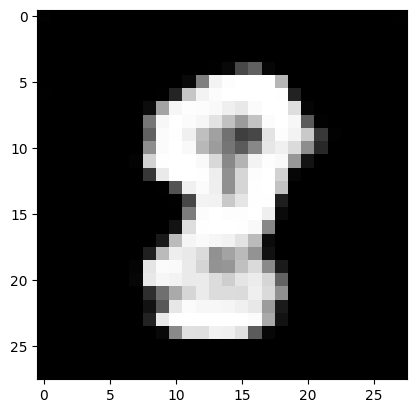

Client 8


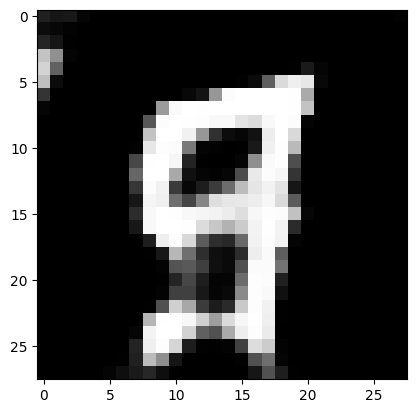

Client 9
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
training client 0 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.6962 - g_loss: 0.8969
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 13s 24ms/step - d_loss: 0.6391 - g_loss: 0.9866
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.6625 - g_loss: 1.0271
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6749 - g_loss: 0.8806
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.6550 - g_loss: 0.8771
training client 1 's CNN
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 36ms/step - d_loss: 0.7302 - g_loss: 0.8535
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.6669 - g_loss: 0.8900
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6677 - g_loss: 0.8553
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 26ms/step - d_loss: 0.6532 - g_loss: 0.8404
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.63

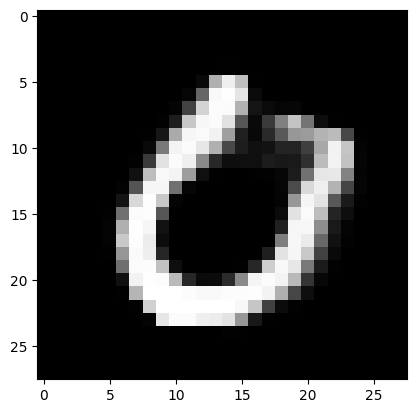

Global 0


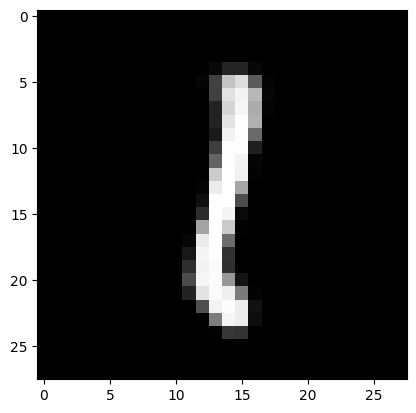

Global 1


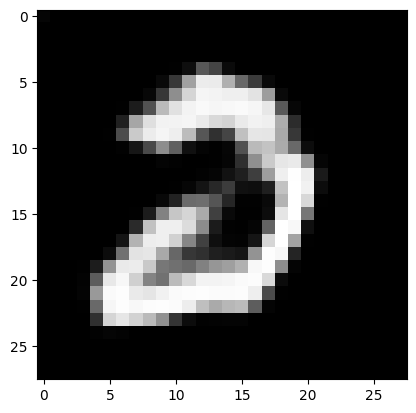

Global 2


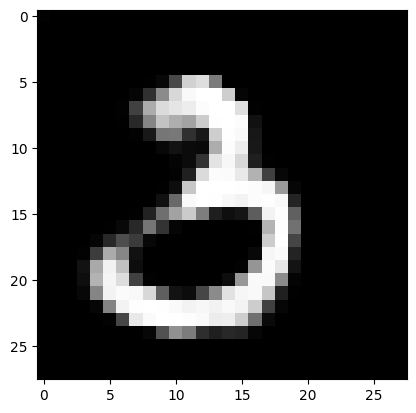

Global 3


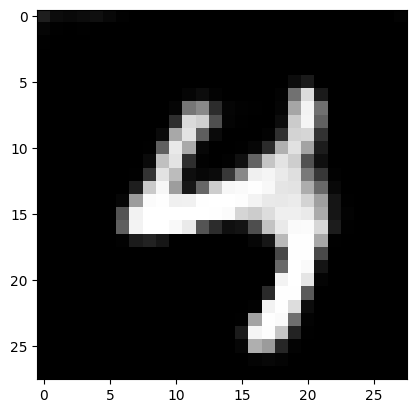

Global 4


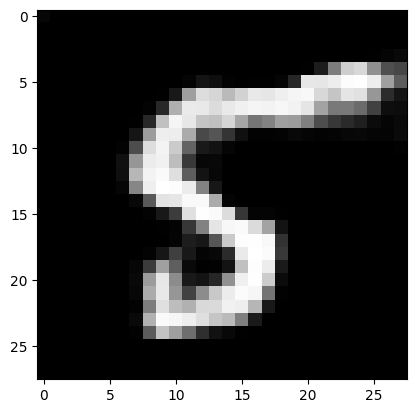

Global 5


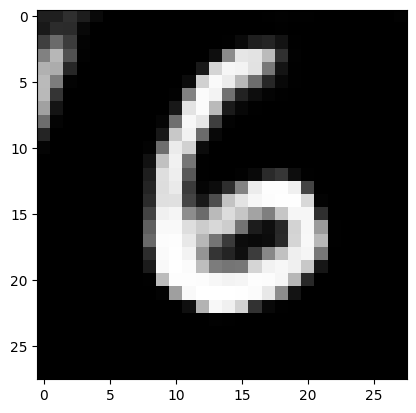

Global 6


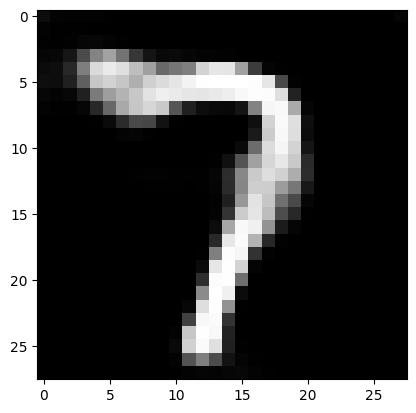

Global 7


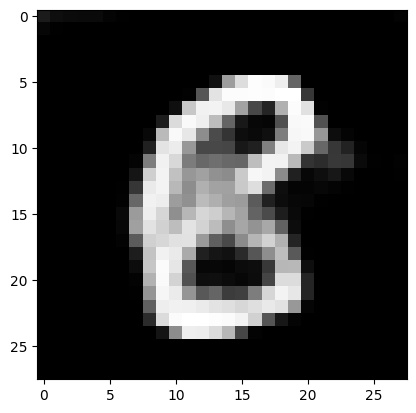

Global 8


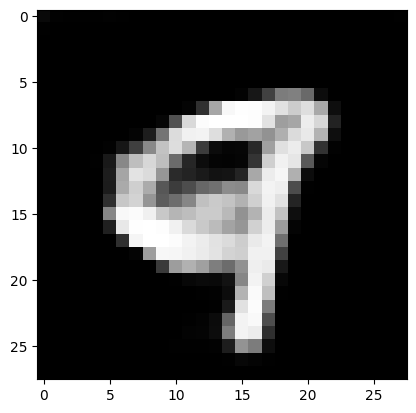

Global 9


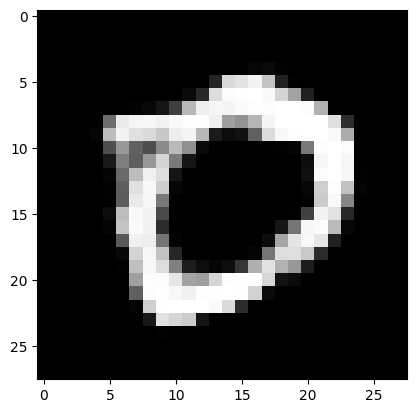

Client 0


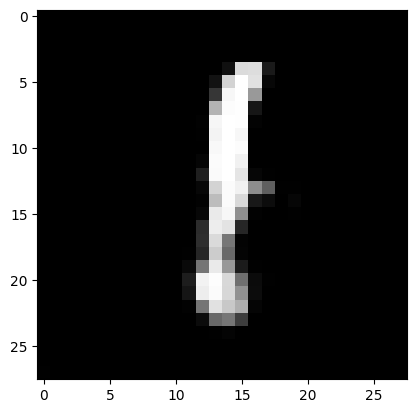

Client 1


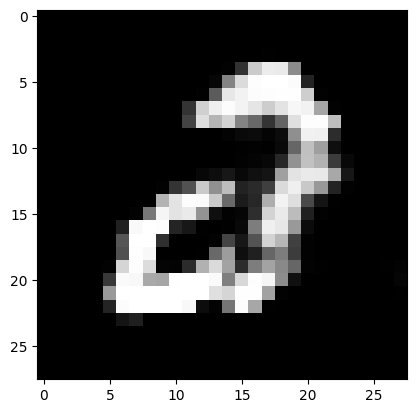

Client 2


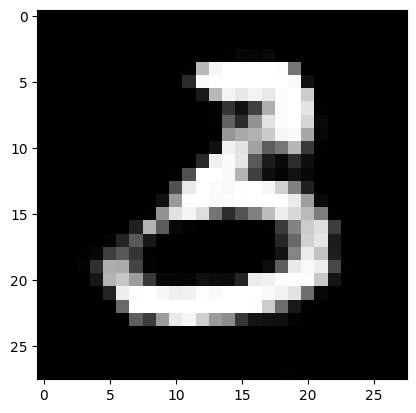

Client 3


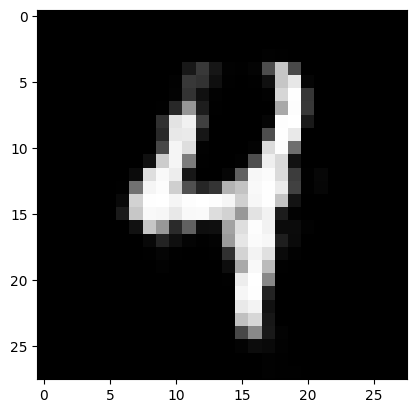

Client 4


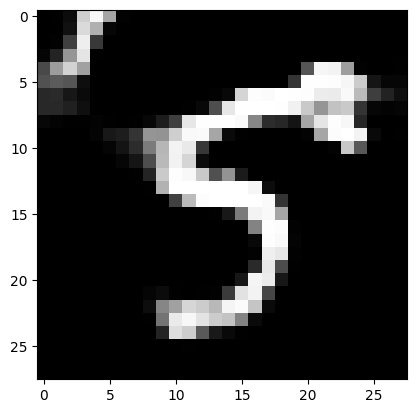

Client 5


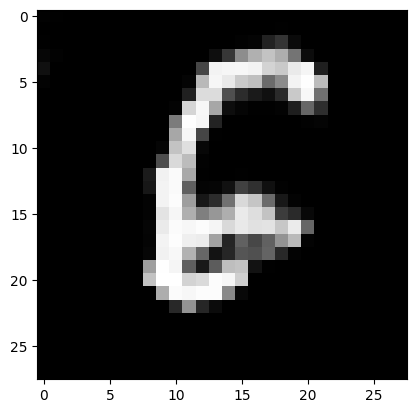

Client 6


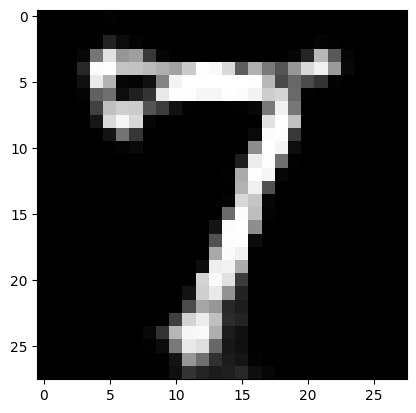

Client 7


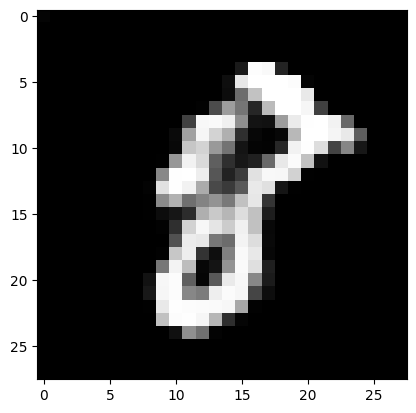

Client 8


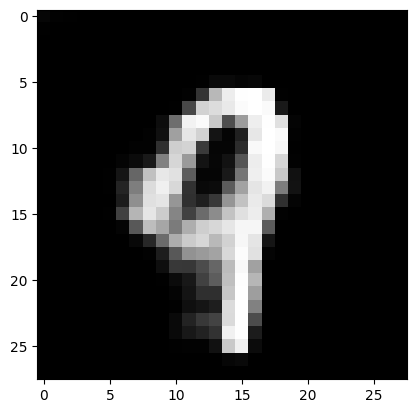

Client 9


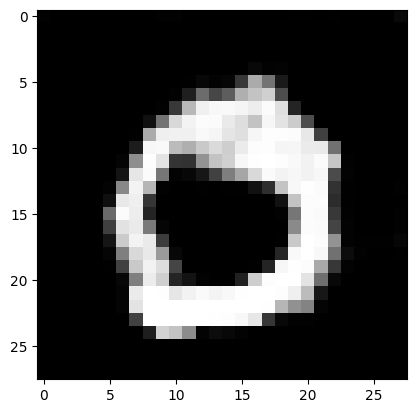

Client 0


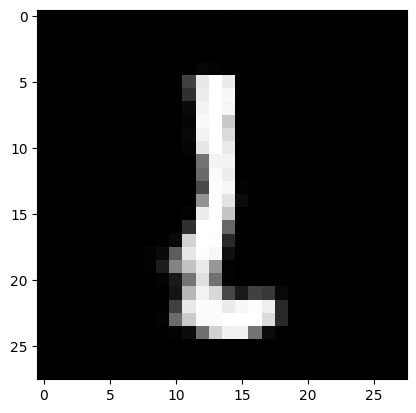

Client 1


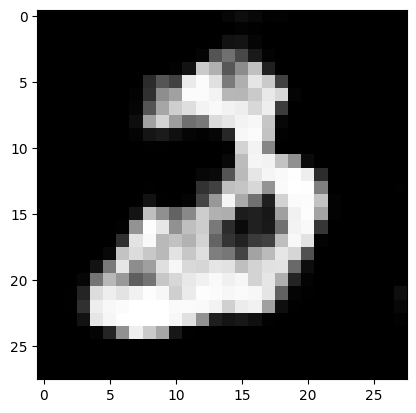

Client 2


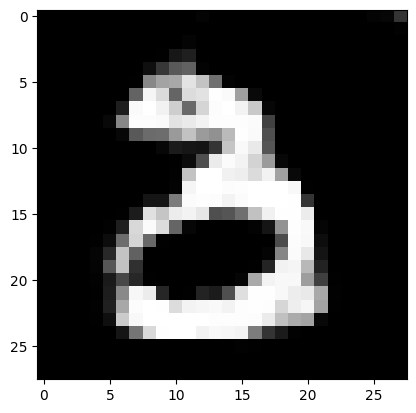

Client 3


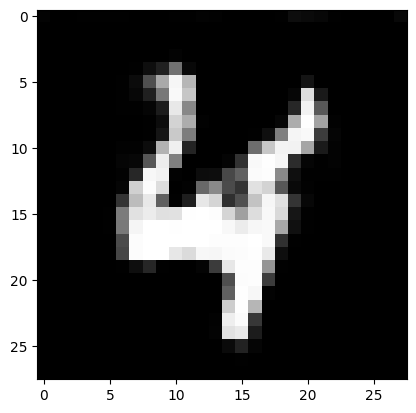

Client 4


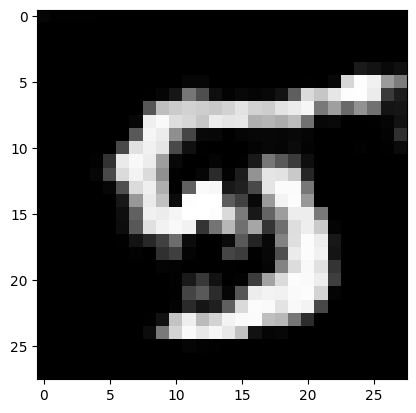

Client 5


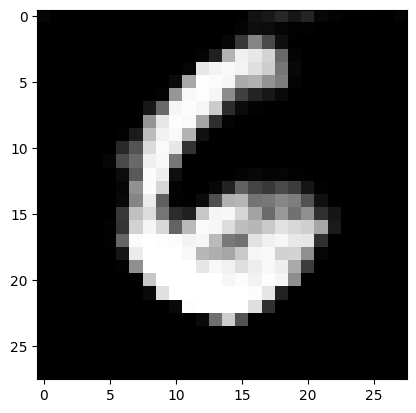

Client 6


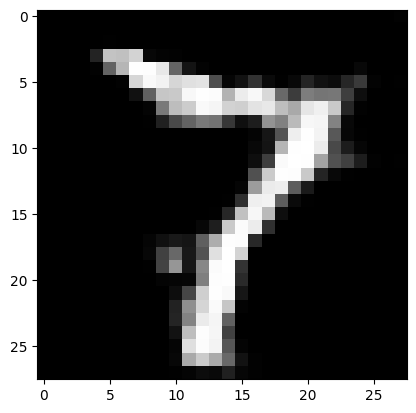

Client 7


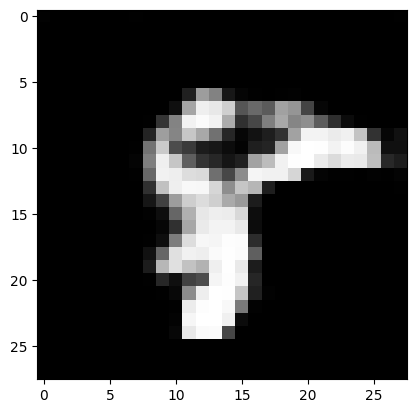

Client 8


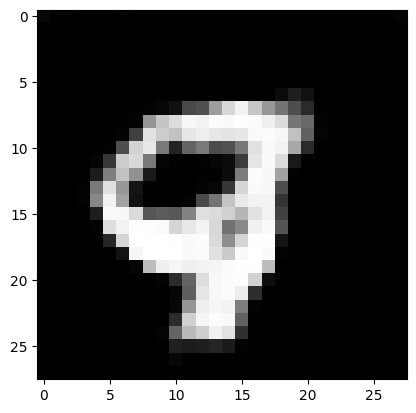

Client 9


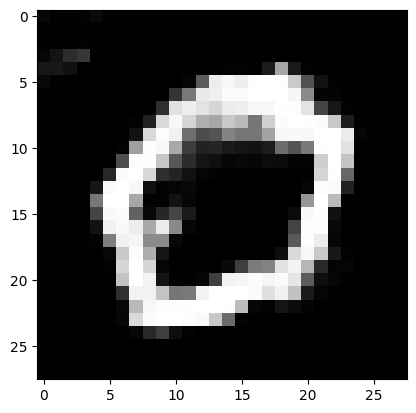

Client 0


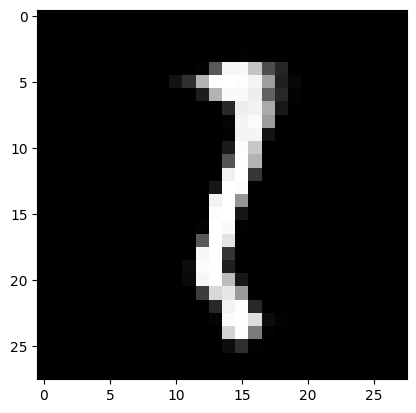

Client 1


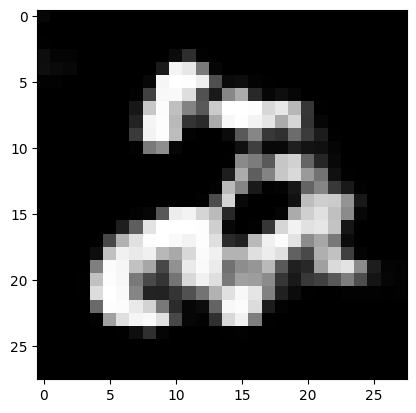

Client 2


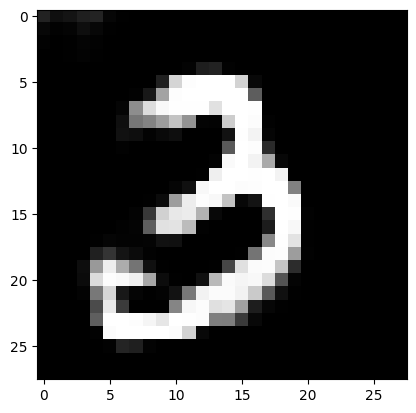

Client 3


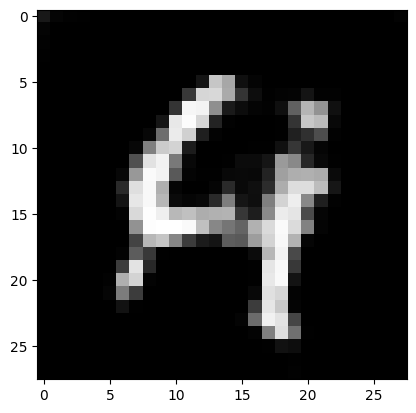

Client 4


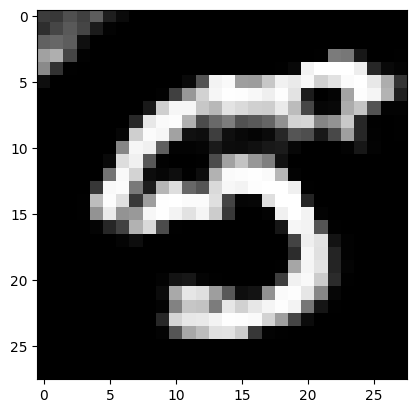

Client 5


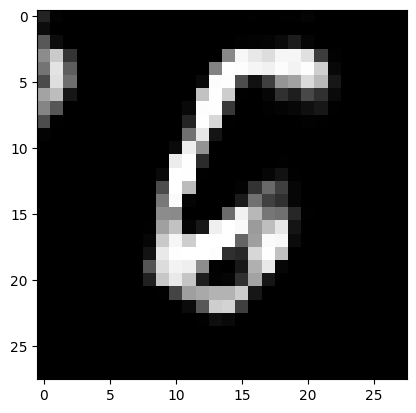

Client 6


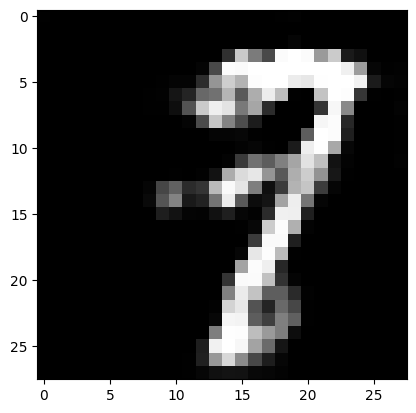

Client 7


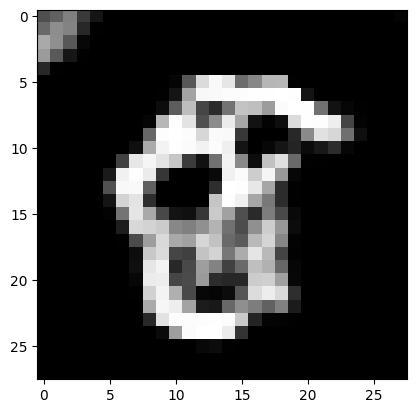

Client 8


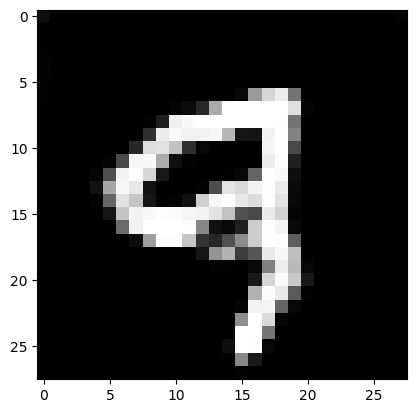

Client 9
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
training client 0 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_loss: 0.6668 - g_loss: 0.8647
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6252 - g_loss: 1.0936
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6633 - g_loss: 0.8461
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 25ms/step - d_loss: 0.6529 - g_loss: 0.8734
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6730 - g_loss: 0.8043
training client 1 's CNN
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - d_loss: 0.7199 - g_loss: 0.7607
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 12s 24ms/step - d_loss: 0.6954 - g_loss: 0.7573
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - d_loss: 0.7017 - g_loss: 0.7681
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6786 - g_loss: 0.7805
Epoch 5/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 24ms/step - d_loss: 0.6924 

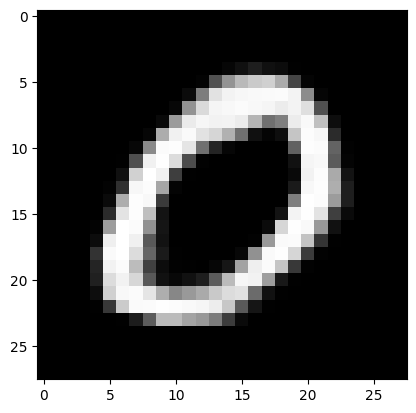

Global 0


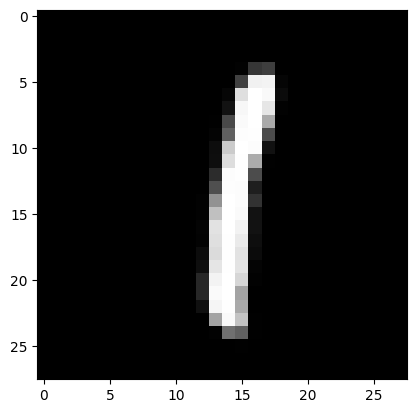

Global 1


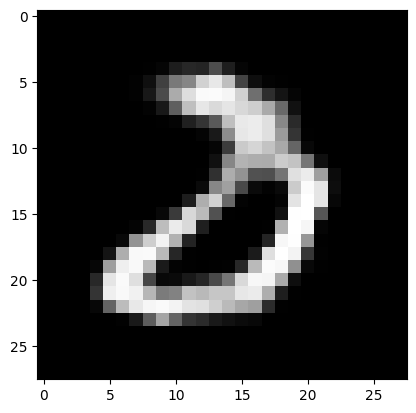

Global 2


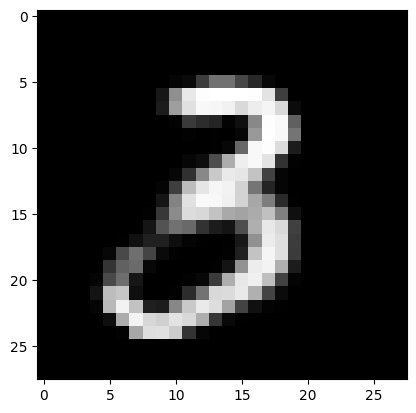

Global 3


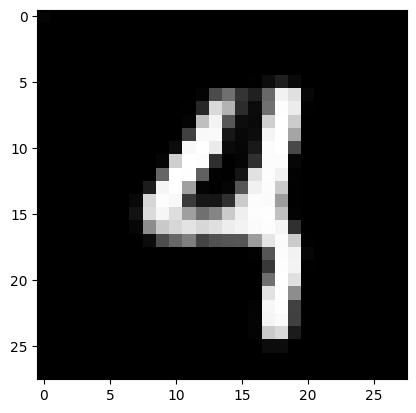

Global 4


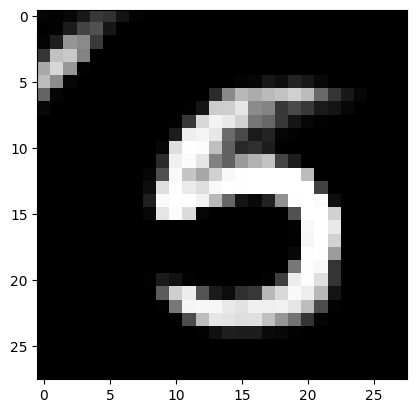

Global 5


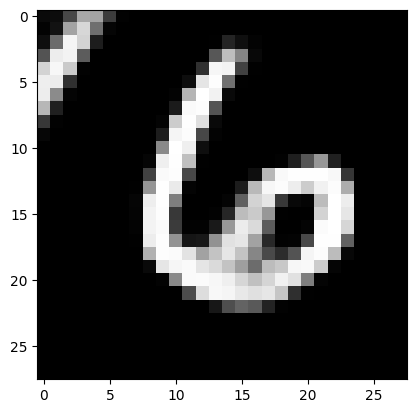

Global 6


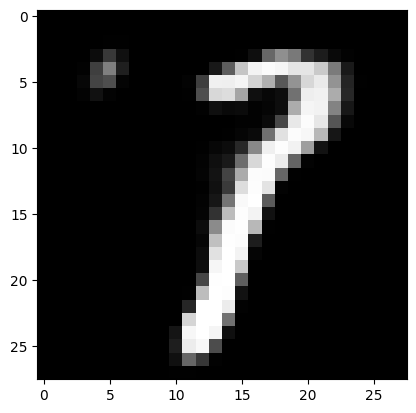

Global 7


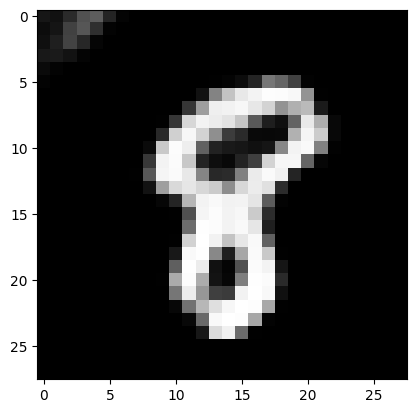

Global 8


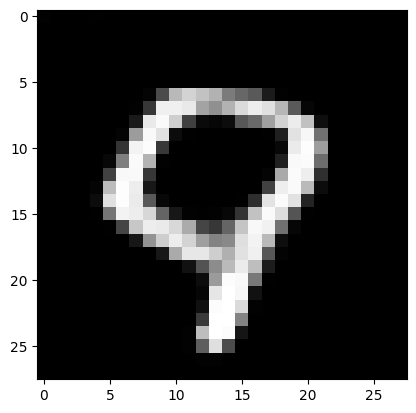

Global 9


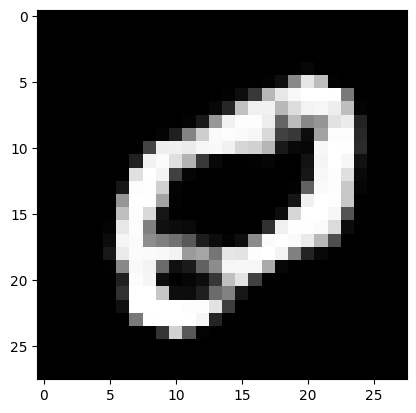

Client 0


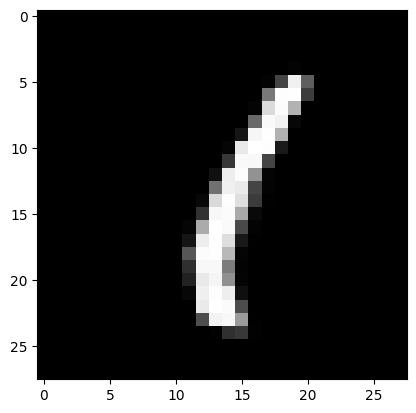

Client 1


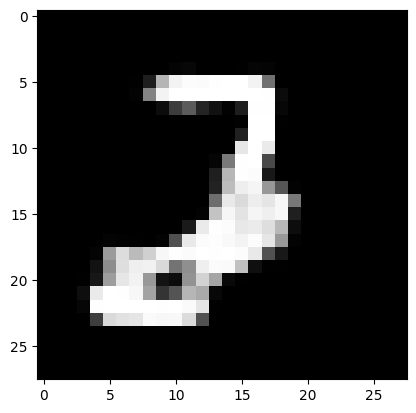

Client 2


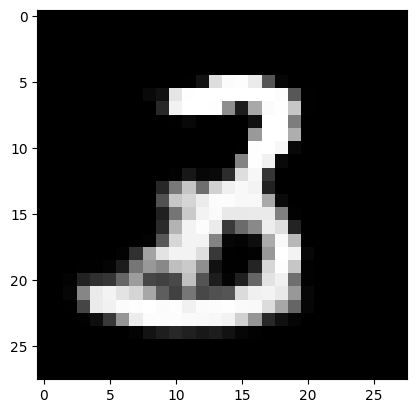

Client 3


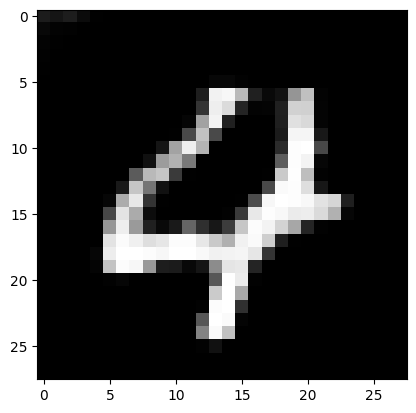

Client 4


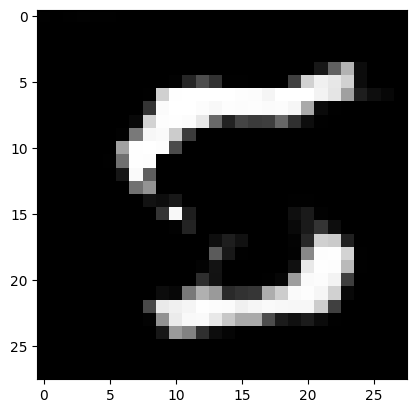

Client 5


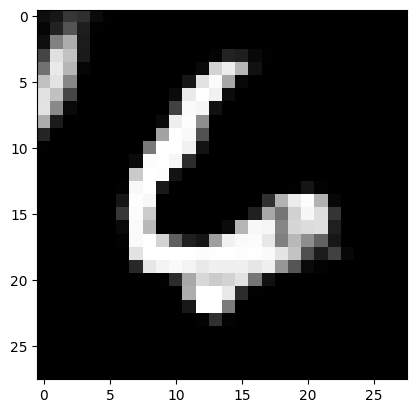

Client 6


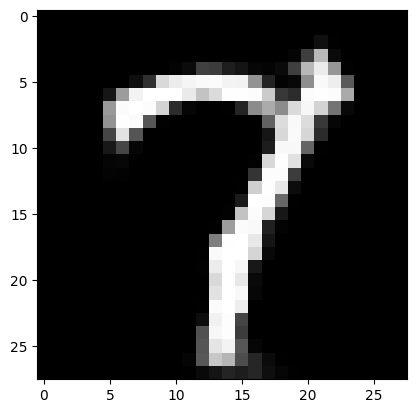

Client 7


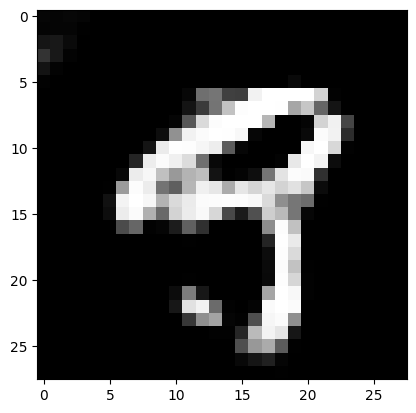

Client 8


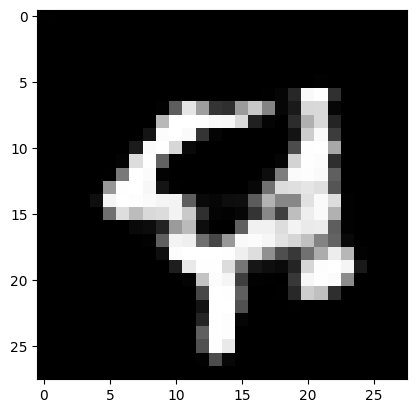

Client 9


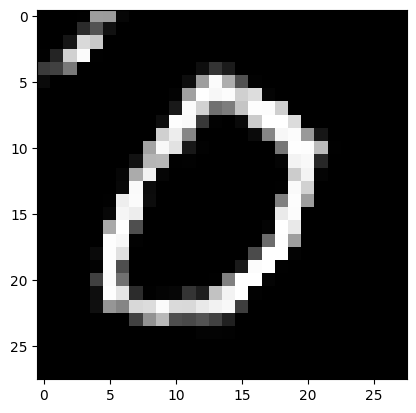

Client 0


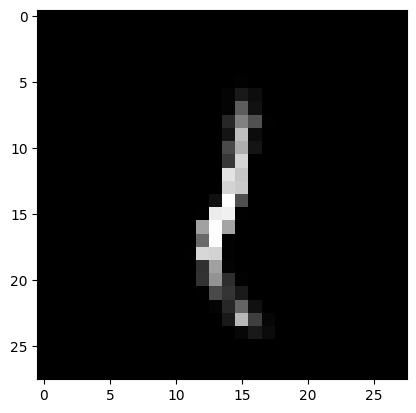

Client 1


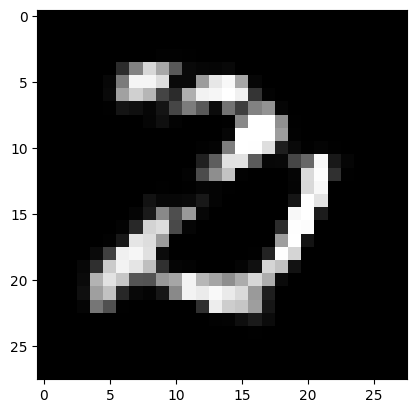

Client 2


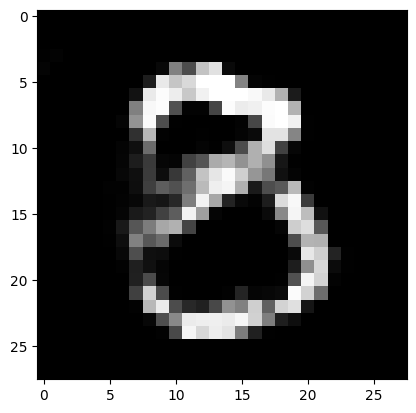

Client 3


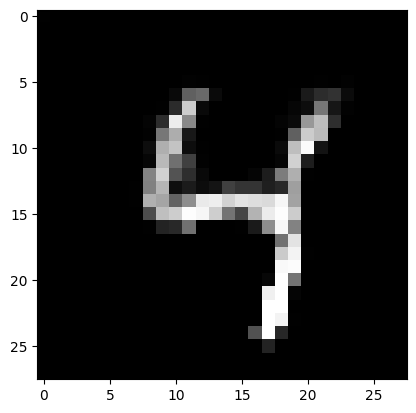

Client 4


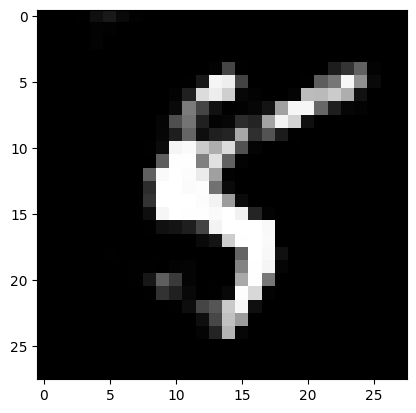

Client 5


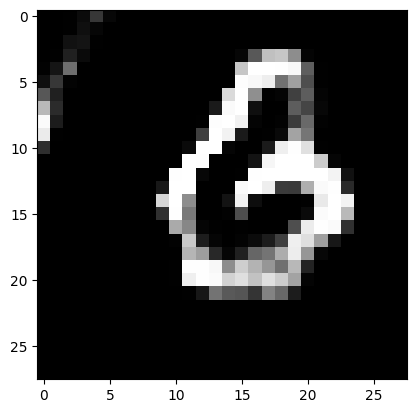

Client 6


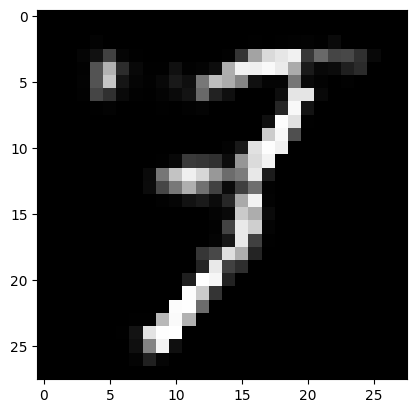

Client 7


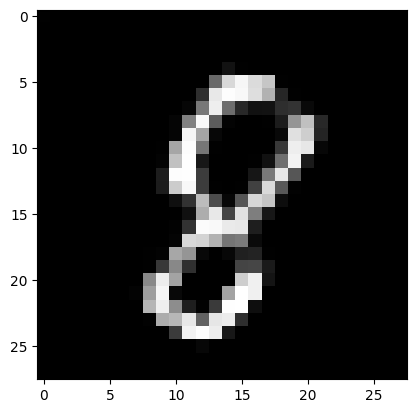

Client 8


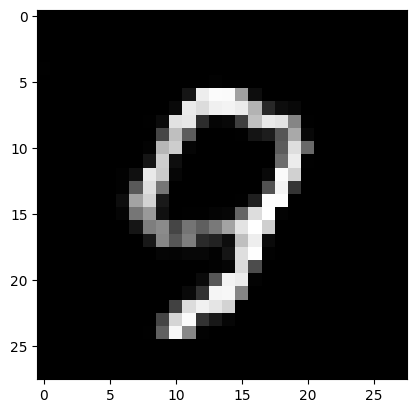

Client 9


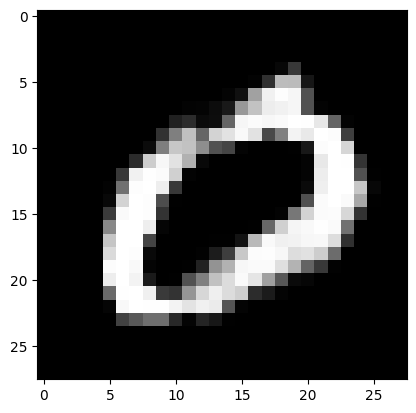

Client 0


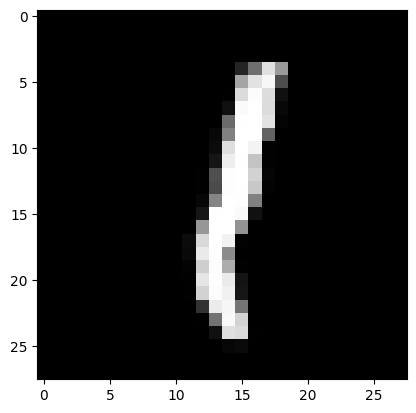

Client 1


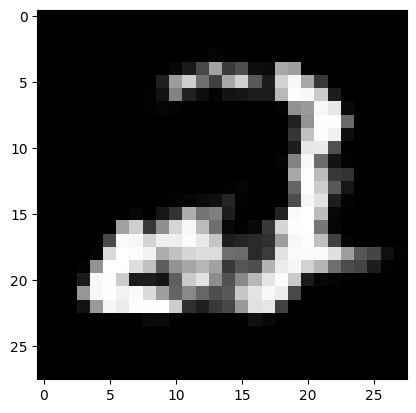

Client 2


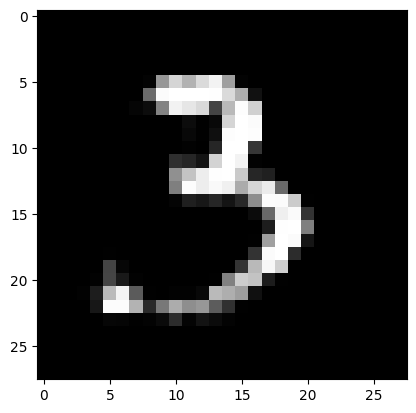

Client 3


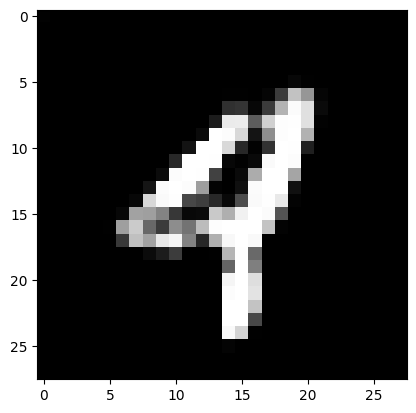

Client 4


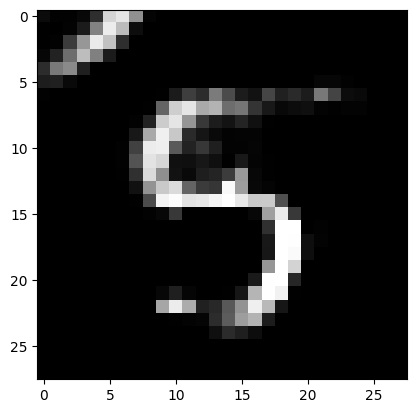

Client 5


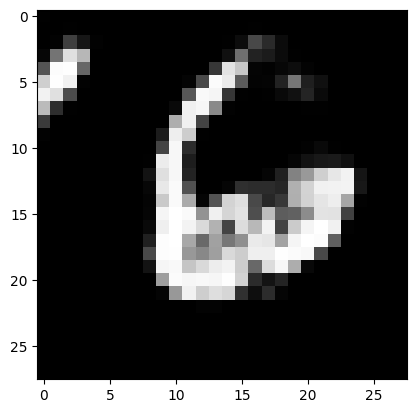

Client 6


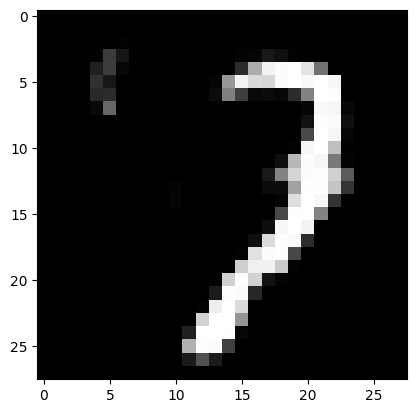

Client 7


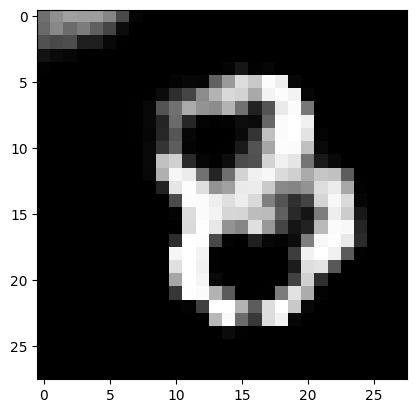

Client 8


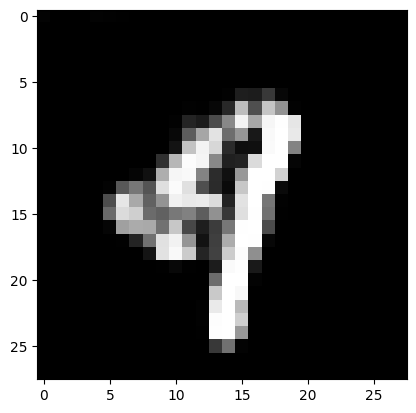

Client 9
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
training client 0 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 39ms/step - d_loss: 0.6851 - g_loss: 0.8109
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6701 - g_loss: 0.8409
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6710 - g_loss: 0.8377
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - d_loss: 0.6506 - g_loss: 0.9008
Epoch 4: early stopping
training client 1 's CNN
training client 1 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 19s 38ms/step - d_loss: 0.7366 - g_loss: 0.7125
Epoch 2/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6781 - g_loss: 0.7795
Epoch 3/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 24ms/step - d_loss: 0.6881 - g_loss: 0.7522
Epoch 4/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 8s 25ms/step - d_loss: 0.6908 - g_loss: 0.7523
Epoch 4: early stopping
training client 2 's CNN
training client 2 's GEN
Epoch 1/5
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 37ms/step - d_

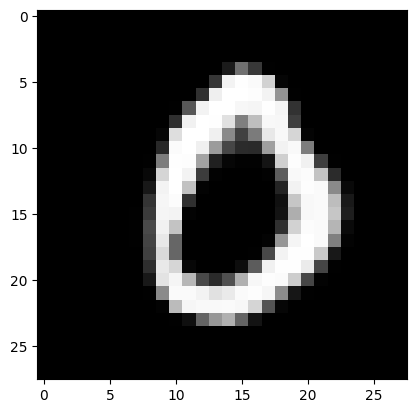

Global 0


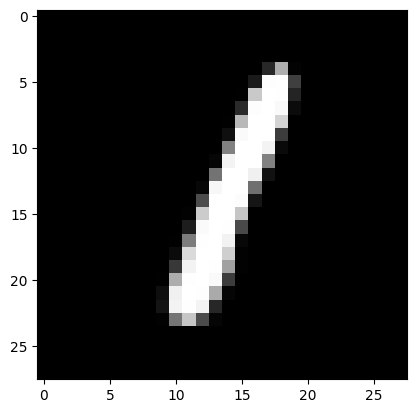

Global 1


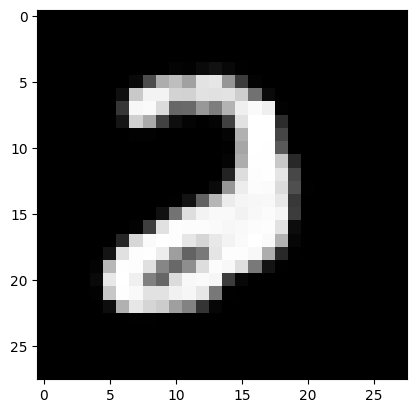

Global 2


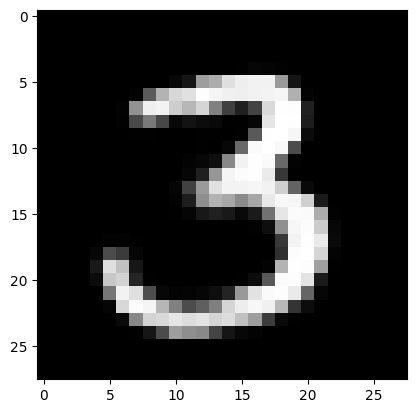

Global 3


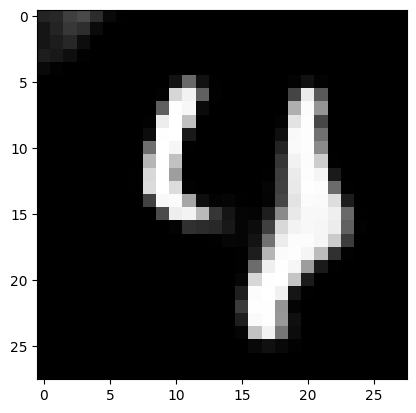

Global 4


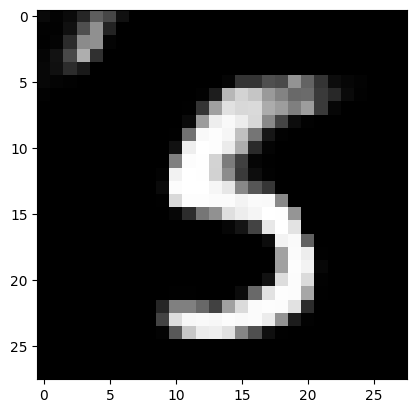

Global 5


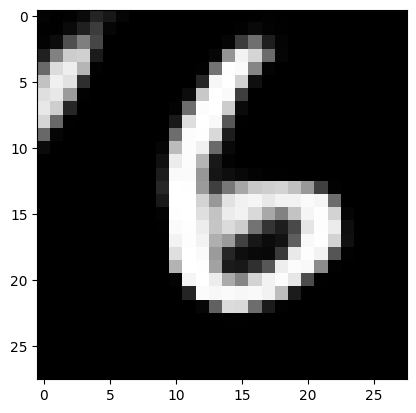

Global 6


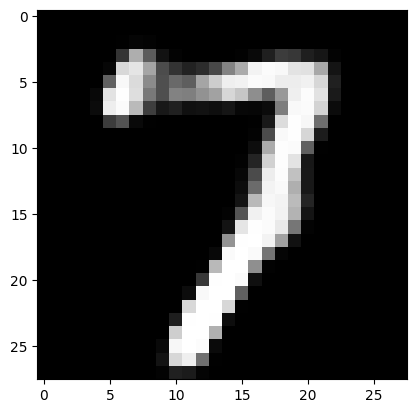

Global 7


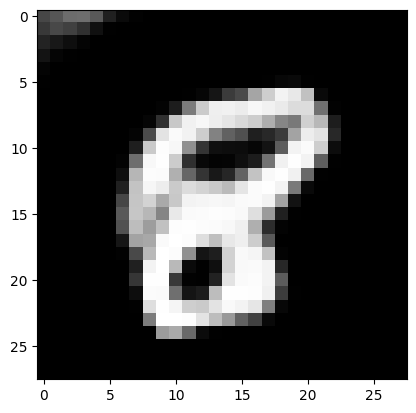

Global 8


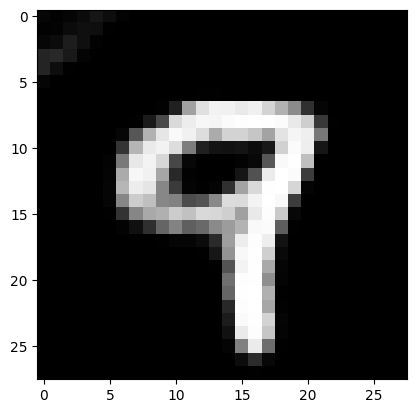

Global 9


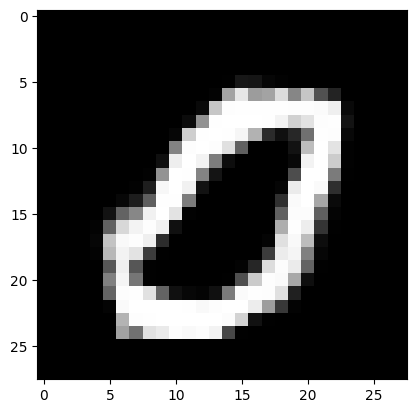

Client 0


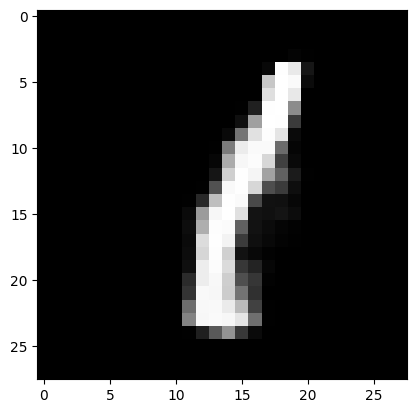

Client 1


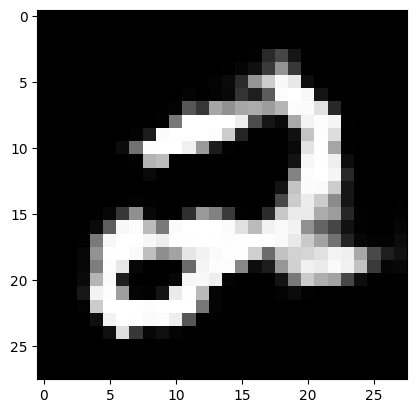

Client 2


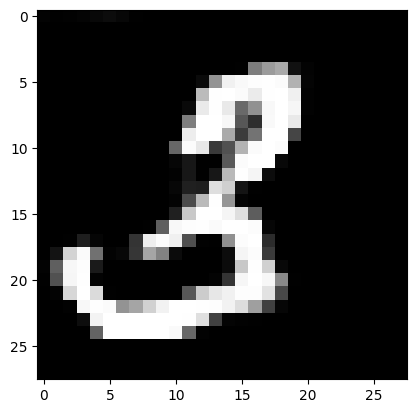

Client 3


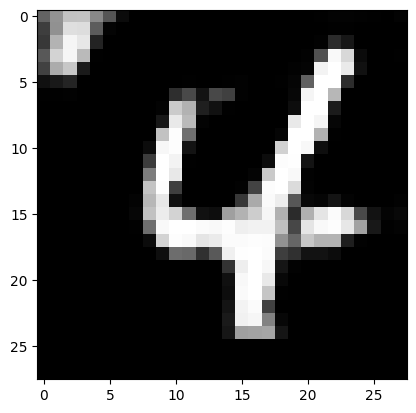

Client 4


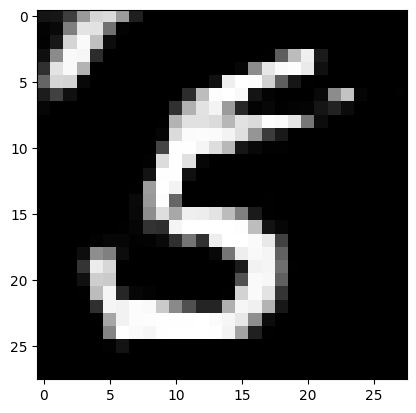

Client 5


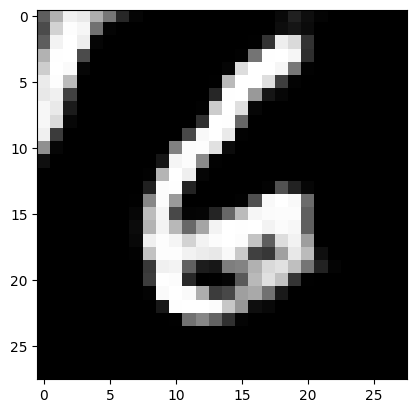

Client 6


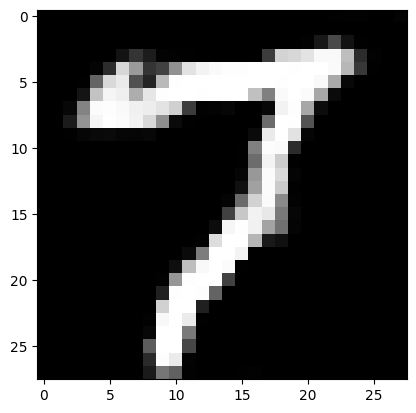

Client 7


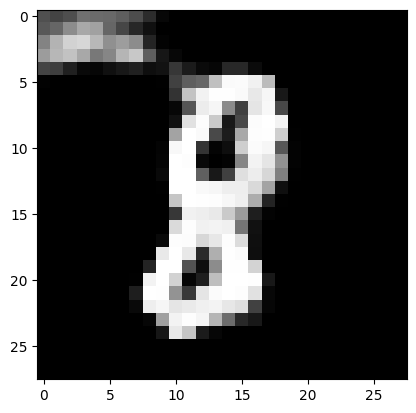

Client 8


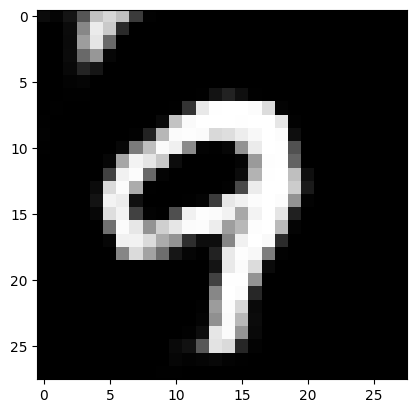

Client 9


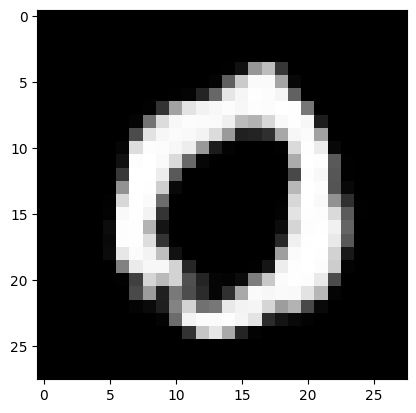

Client 0


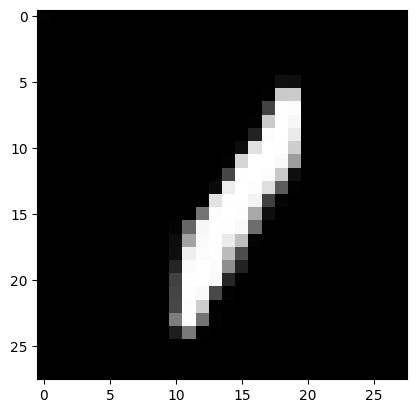

Client 1


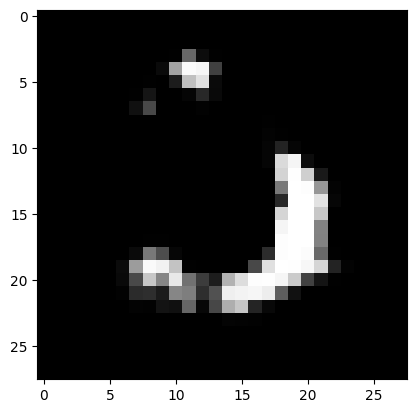

Client 2


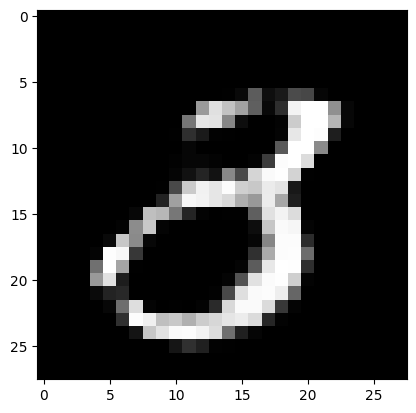

Client 3


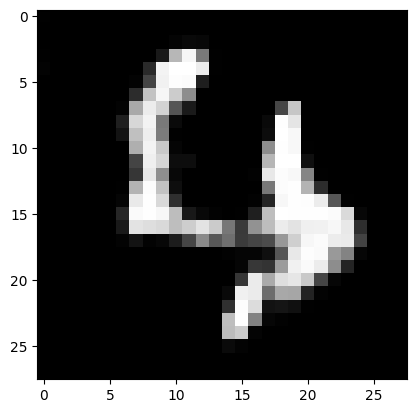

Client 4


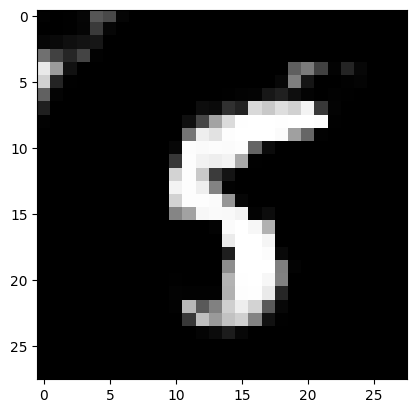

Client 5


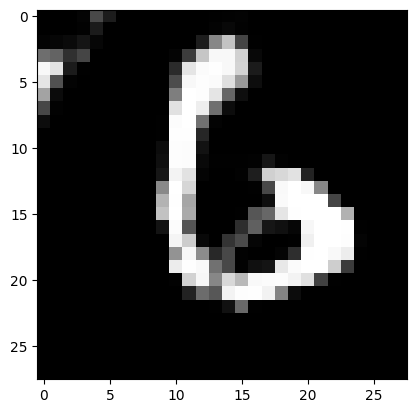

Client 6


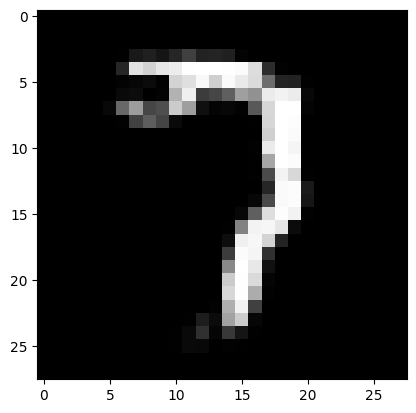

Client 7


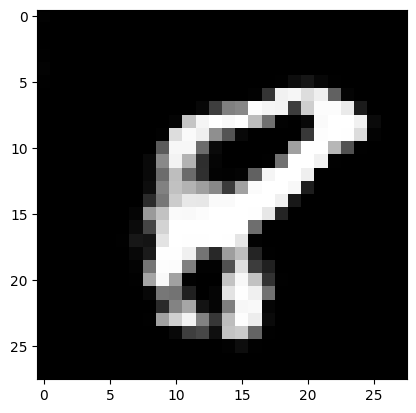

Client 8


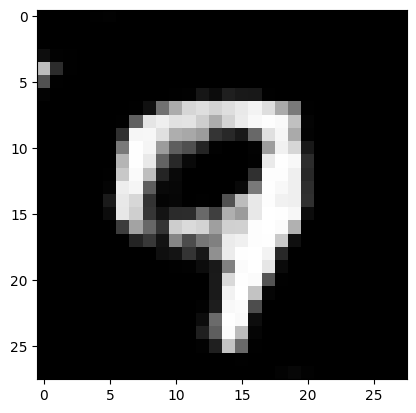

Client 9


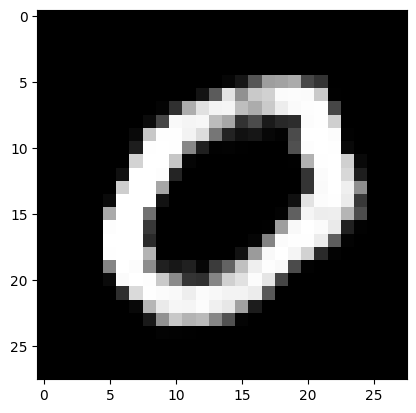

Client 0


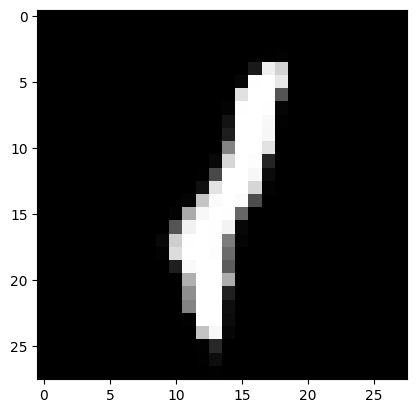

Client 1


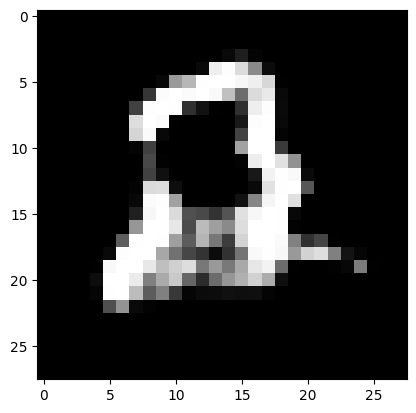

Client 2


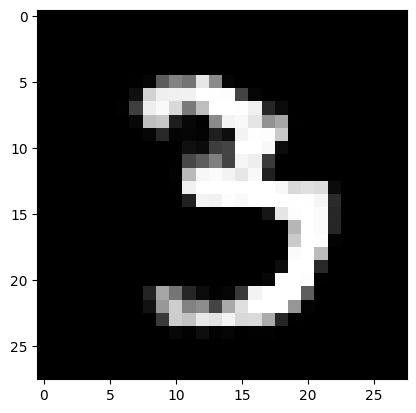

Client 3


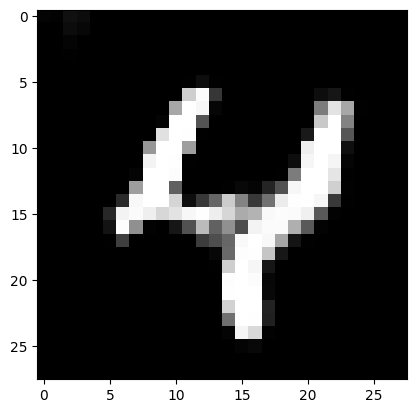

Client 4


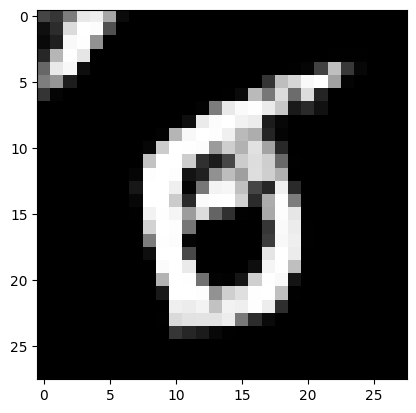

Client 5


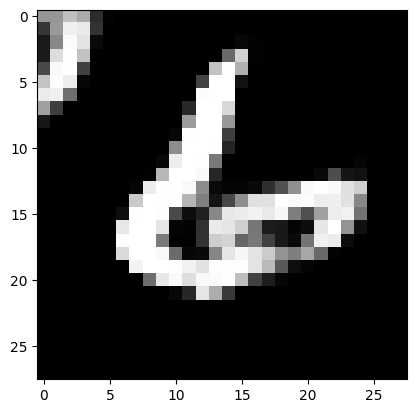

Client 6


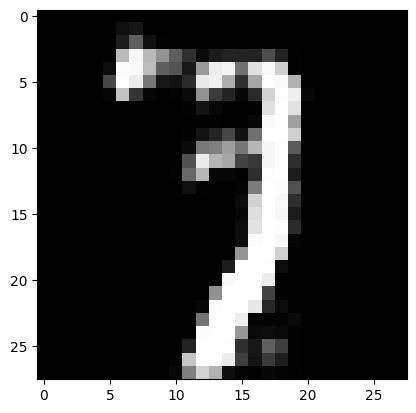

Client 7


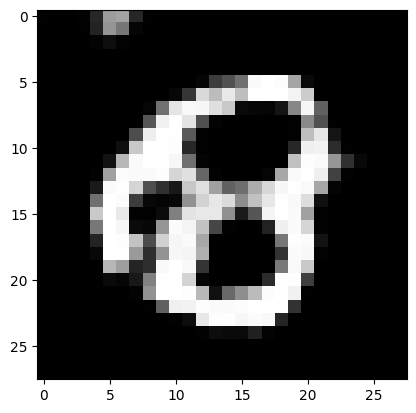

Client 8


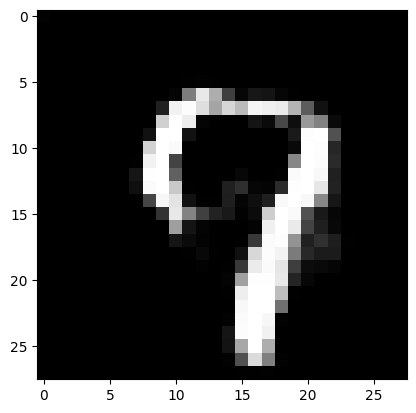

Client 9
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
training client 0 's GEN
Epoch 1/5


KeyboardInterrupt: 

In [31]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 5, algo='FedPKDG')

Server.local_training(cnn_epochs = 0, gen_epochs=20, is_earlystop=False) #don't train cnn
print('>>>>>>>>>trained all clients gen round', _)
Server.agg_gen()
print('>>>>>>>>>Weighted aggregated client generator')
for num in range(10):
  img = generate_image(Server.generator, num, 128)
  plt.imshow(img[0], cmap='gray')
  plt.show()
  print('Global', num)

for client in client_list:
  for num in range(10):
    img = generate_image(client.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Client', num)

total_rounds = 10
for round in range(total_rounds):
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')
  Server.local_training(cnn_epochs = 0) #don't train cnn
  print('>>>>>>>>>trained all clients gen round', round)
  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')
  for num in range(10):
    img = generate_image(Server.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Global', num)

  for client in client_list:
    for num in range(10):
      img = generate_image(client.generator, num, 128)
      plt.imshow(img[0], cmap='gray')
      plt.show()
      print('Client', num)


discovery:

It has shown that the first aggregated generator cannot produce sensible output. After training on the aggregated global generator on clients' local data, the global generator starts to produce better images than client ones. For the first few rounds, the client generator show distinct features about the private dataset shown as the boldness of the handwriting, such distinction gradually fade and generators converge towards later communication rounds.


how it impacts design:
- initialise with training the local generators to convergence (20 epochs), for some reason the earlystopping always stop too early.
- for every communication round train the local generator for less epochs to prevent overfitting -- use earlystopping ~3 epochs
- only start generating public dataset after 1st round of fine-tuning global models on client data.




## Communication Frequency

trial 1. aggregate only after convergence

- 20 on gen
5x
- cnn: 2 fine 3 prune
- gen: 5 with early stop
- 1000 fake, 320 fake later
- distill: 3 epochs of < 50 steps/epoch (too little) -> bad global model performance -> all cnn model accuracies collapses from round 2 and stays to as low as ~0.1

training client 0 's CNN
training client 0 's GEN
Epoch 1/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - d_loss: 0.4715 - g_loss: 1.4363
Epoch 2/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 15s 23ms/step - d_loss: 0.3455 - g_loss: 1.8184
Epoch 3/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4499 - g_loss: 1.4820
Epoch 4/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - d_loss: 0.5186 - g_loss: 1.3291
Epoch 5/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4853 - g_loss: 1.2571
Epoch 6/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4627 - g_loss: 1.3938
Epoch 7/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.4157 - g_loss: 1.5142
Epoch 8/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.4629 - g_loss: 1.3802
Epoch 9/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 7s 23ms/step - d_loss: 0.3820 - g_loss: 1.6843
Epoch 10/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 24ms/step - d_loss: 0.2902 - g_loss: 1.8753
Epoch 11/20
313/313 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - d_loss: 0.2480 

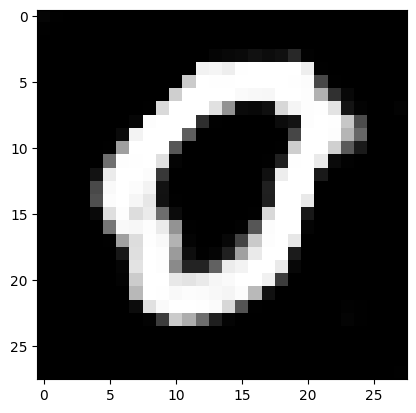

Client 0


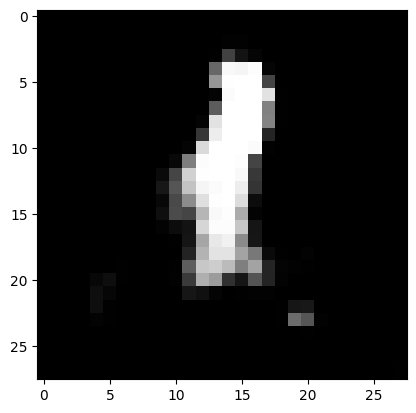

Client 1


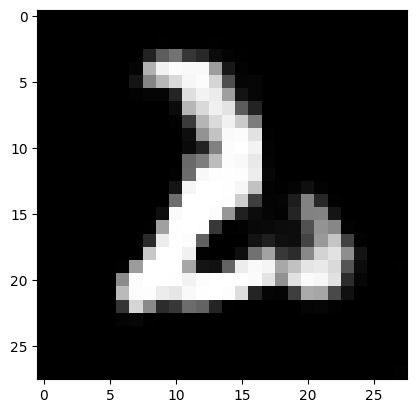

Client 2


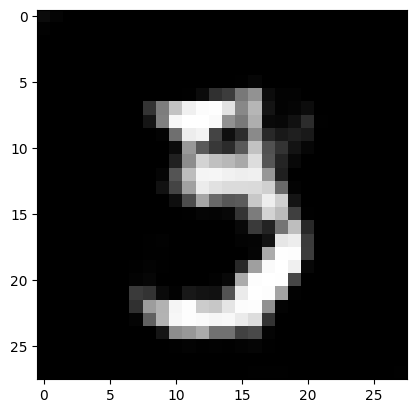

Client 3


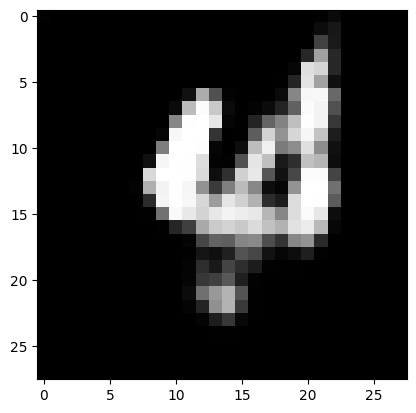

Client 4


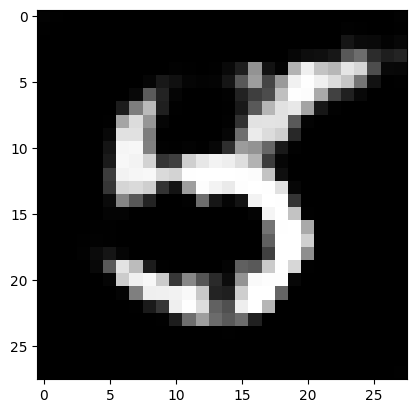

Client 5


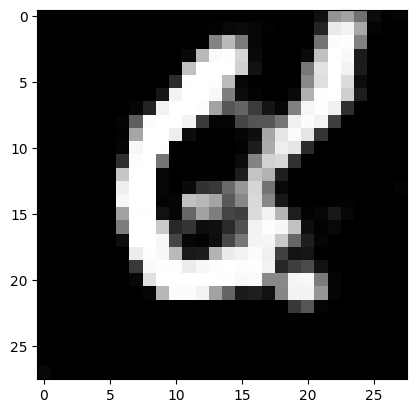

Client 6


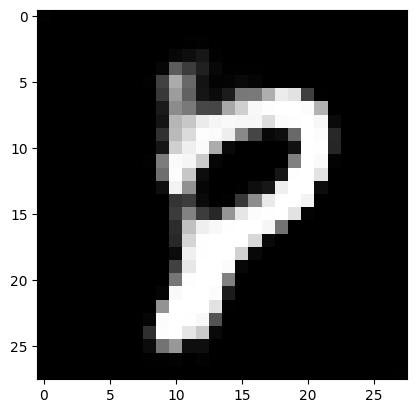

Client 7


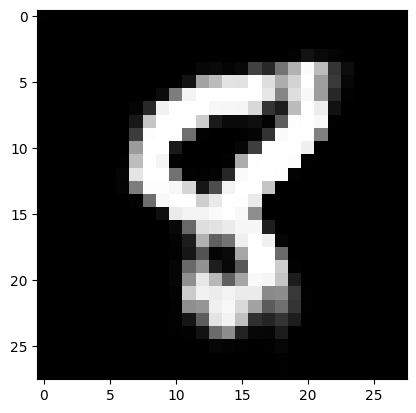

Client 8


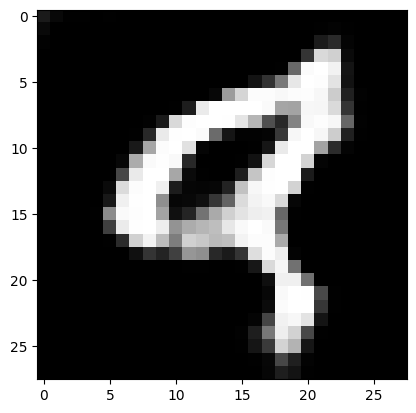

Client 9


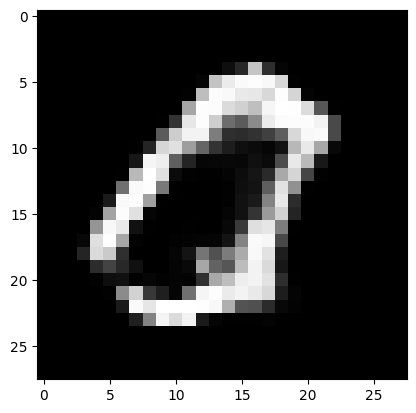

Client 0


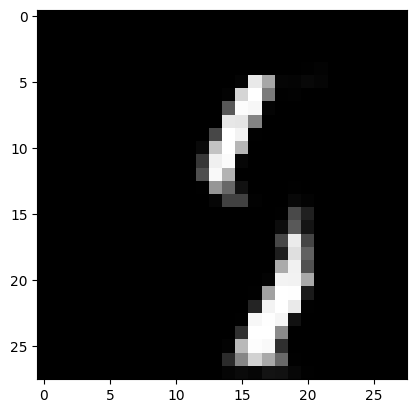

Client 1


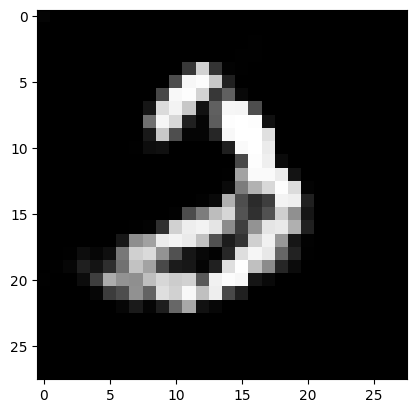

Client 2


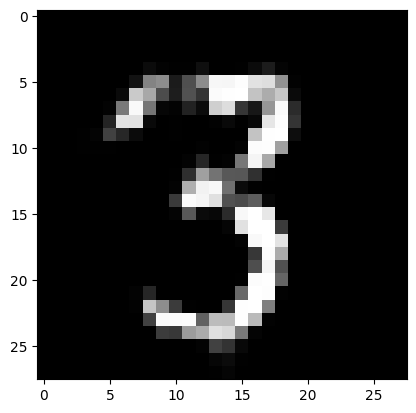

Client 3


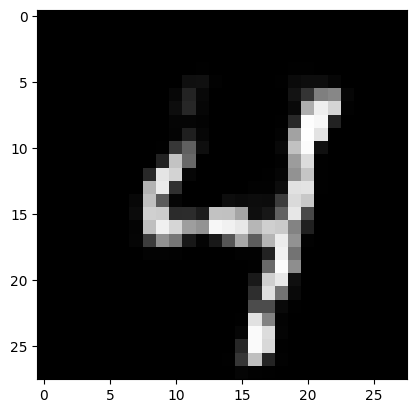

Client 4


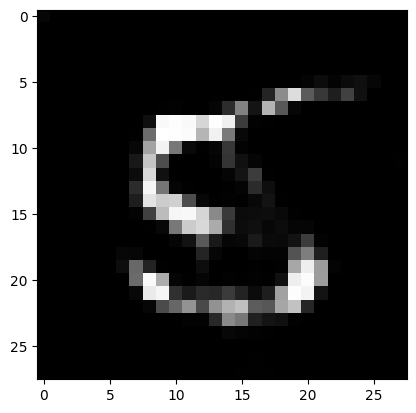

Client 5


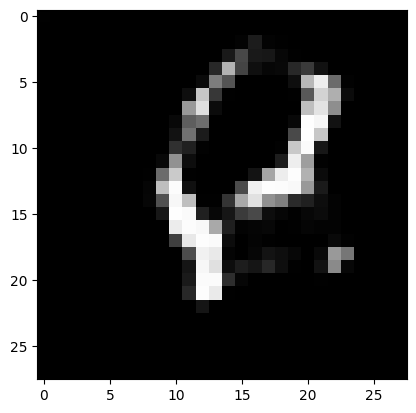

Client 6


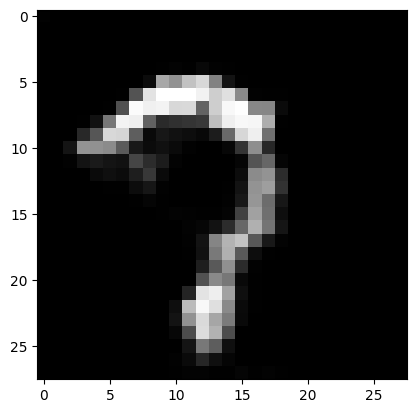

Client 7


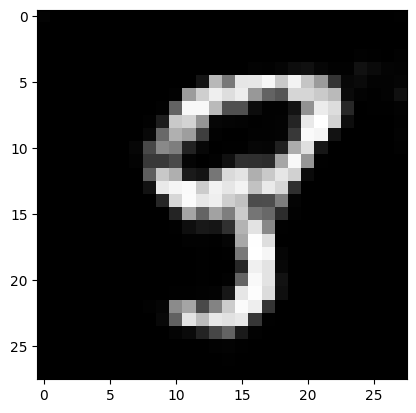

Client 8


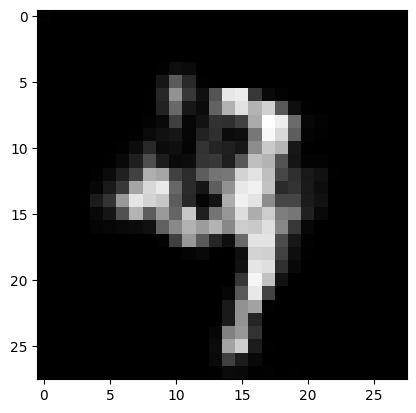

Client 9


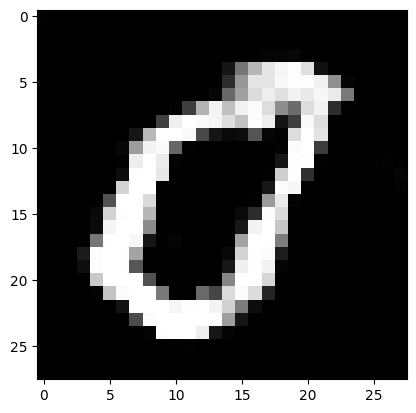

Client 0


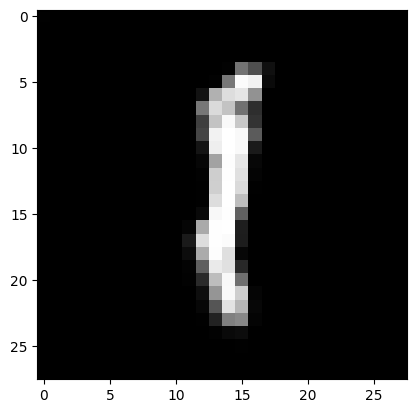

Client 1


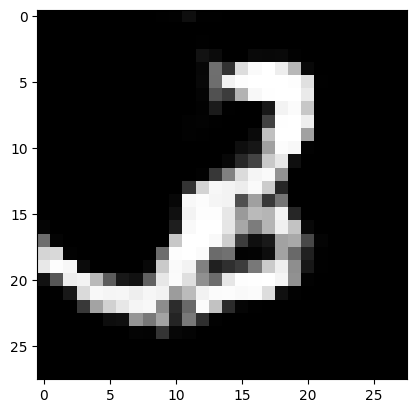

Client 2


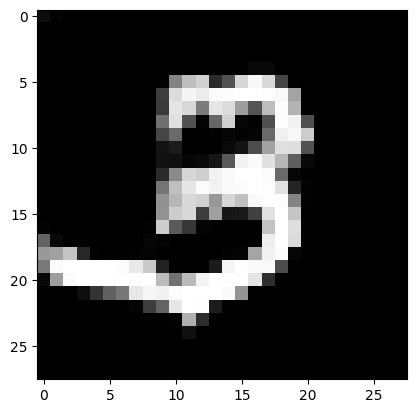

Client 3


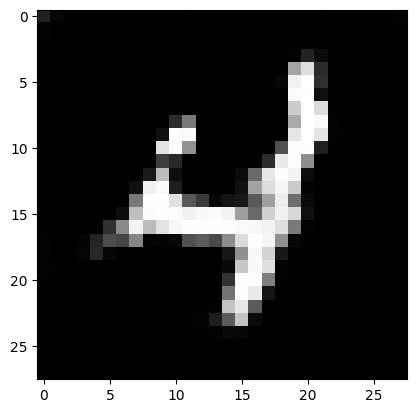

Client 4


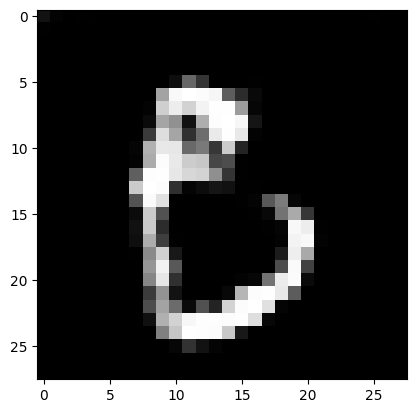

Client 5


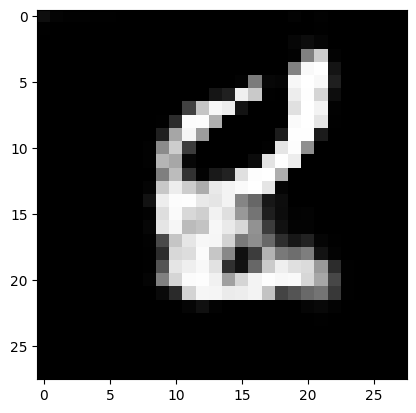

Client 6


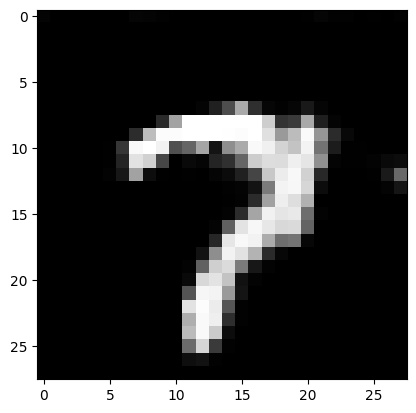

Client 7


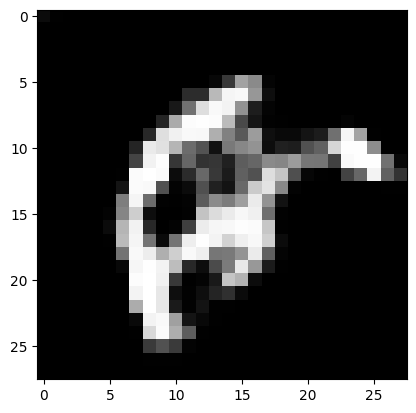

Client 8


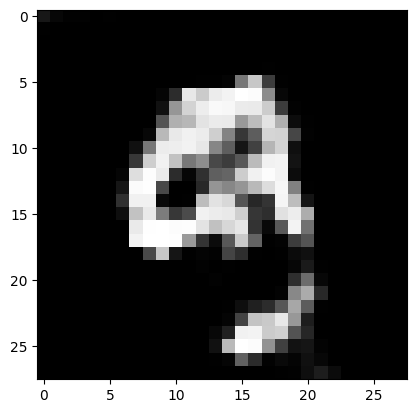

Client 9
----getting weighted avg of clients' gen
>>>>>>>>>Weighted aggregated client generator
********* ROUND 0 *********
>>>>>>>>>Broadcasted weights to all clients
training client 0 's CNN
from gloabl - before pruning client has sparsity 0.0056595559425337396
begin_step= 562 end_step= 1406
Epoch 1/5
282/282 [==============================] - 23s 12ms/step - loss: 0.8018 - sparse_categorical_accuracy: 0.7602 - val_loss: 0.3154 - val_sparse_categorical_accuracy: 0.9140
Epoch 2/5
282/282 [==============================] - 3s 10ms/step - loss: 0.3106 - sparse_categorical_accuracy: 0.9061 - val_loss: 0.2335 - val_sparse_categorical_accuracy: 0.9345
Epoch 3/5
282/282 [==============================] - 2s 5ms/step - loss: 0.2368 - sparse_categorical_accuracy: 0.9314 - val_loss: 0.1918 - val_sparse_categorical_accuracy: 0.9470
Epoch 4/5
282/282 [==============================] - 2s 6ms/step - loss: 0.1974 - sparse_categorical_accuracy: 0.9407 - val_loss: 0.1590 - val_sparse_categorical_acc

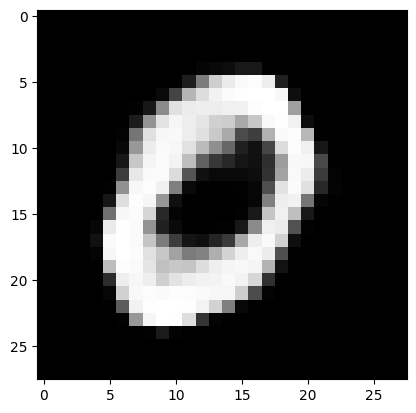

Global 0


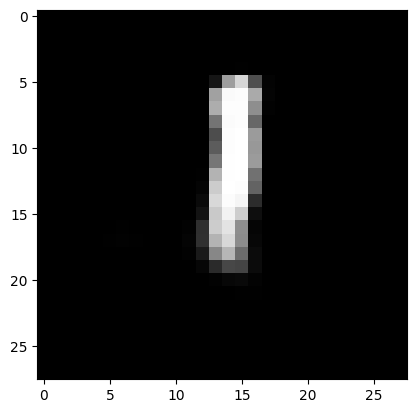

Global 1


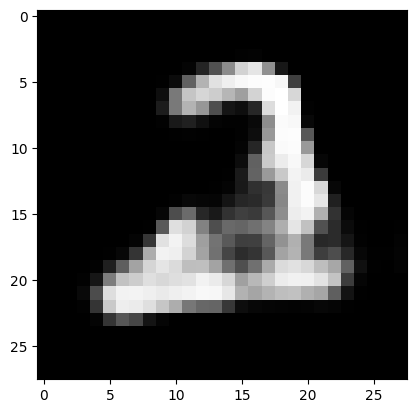

Global 2


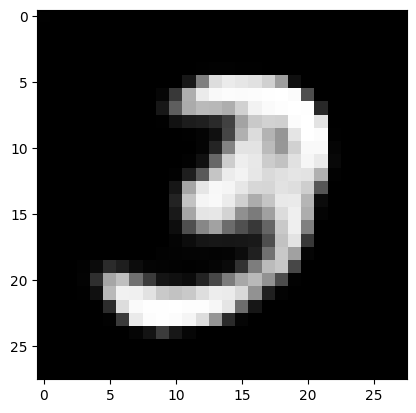

Global 3


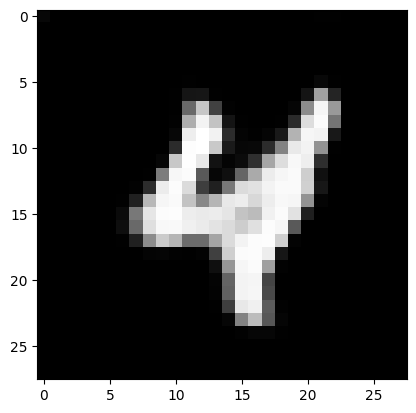

Global 4


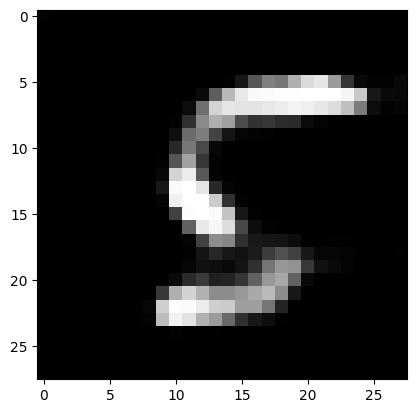

Global 5


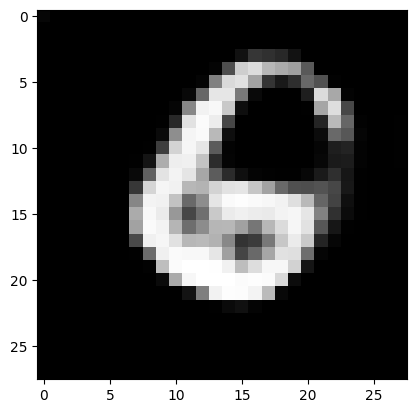

Global 6


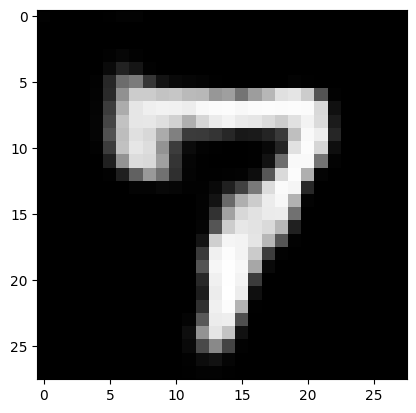

Global 7


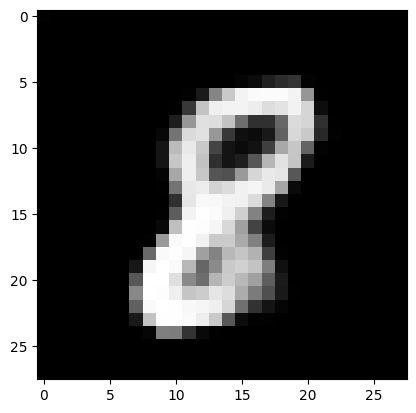

Global 8


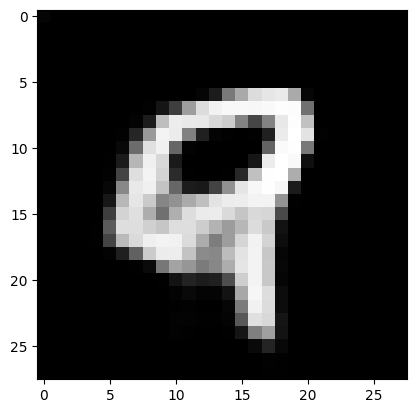

Global 9


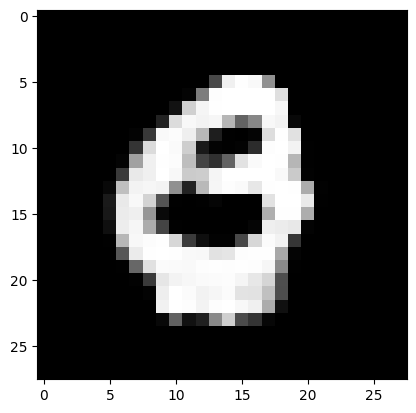

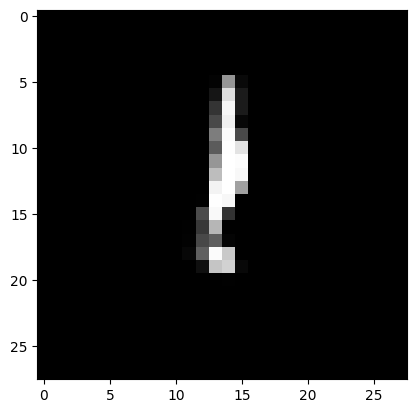

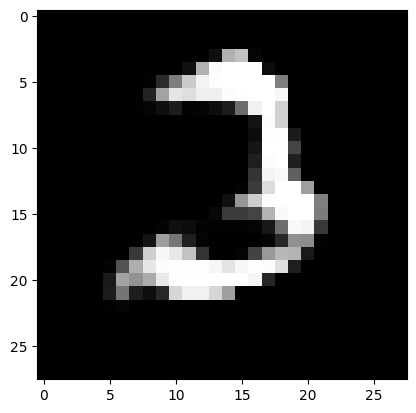

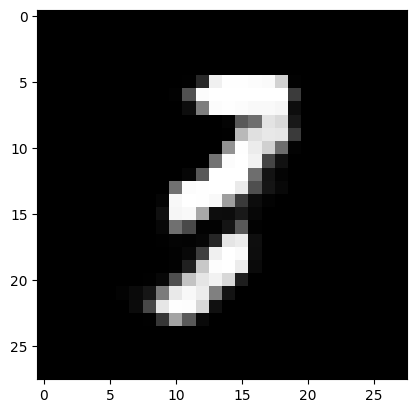

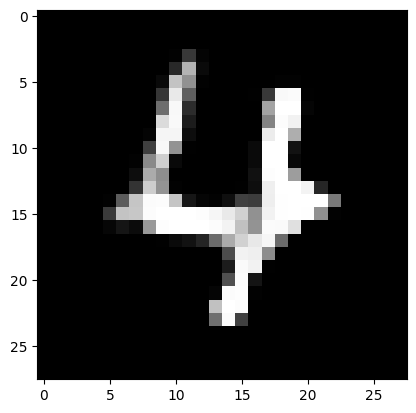

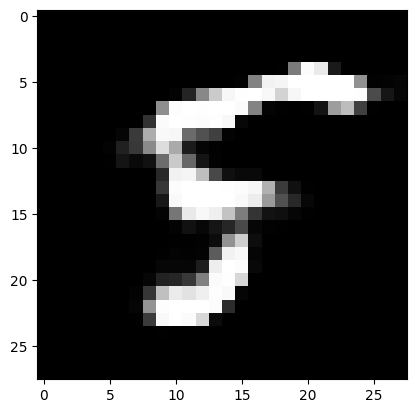

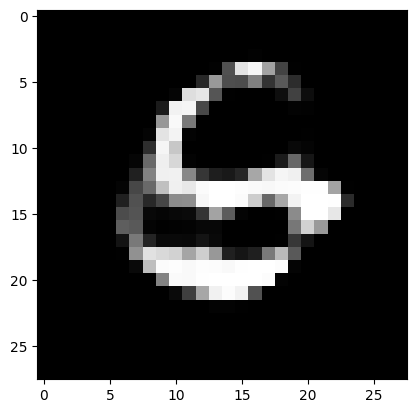

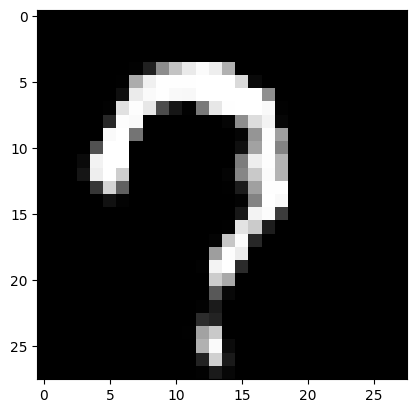

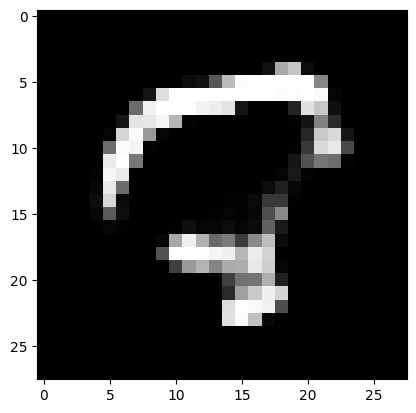

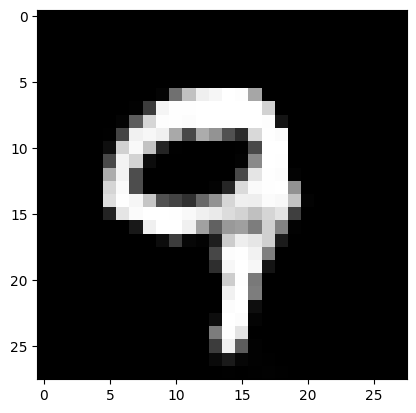

Client 9


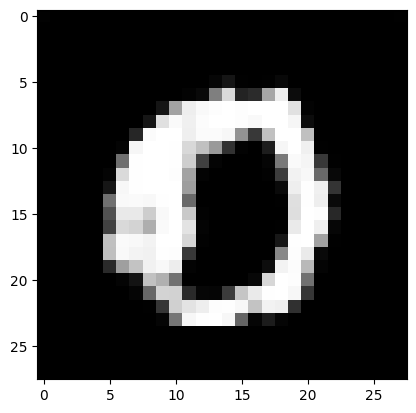

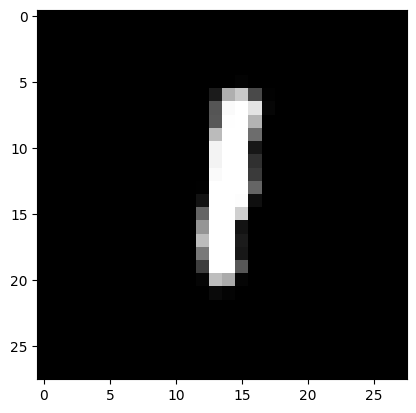

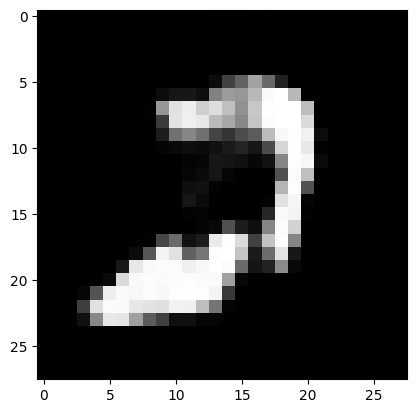

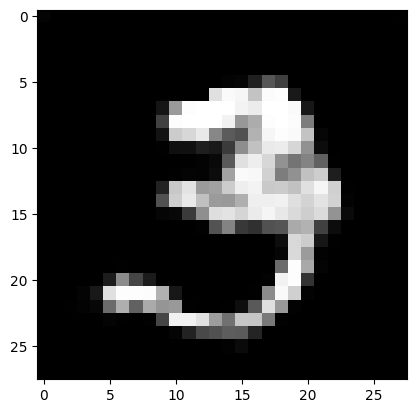

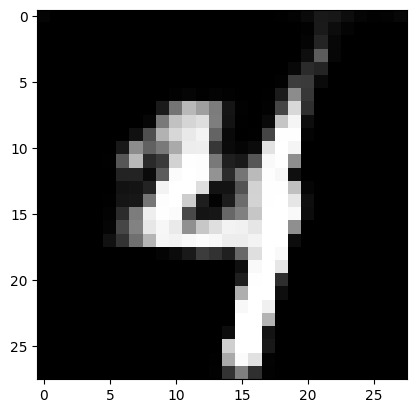

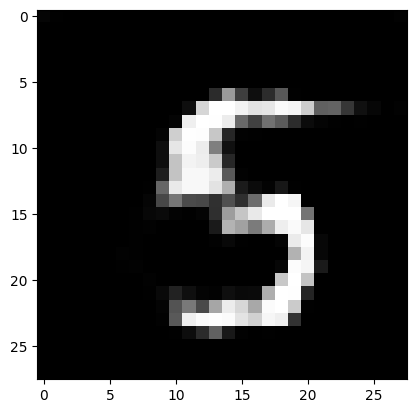

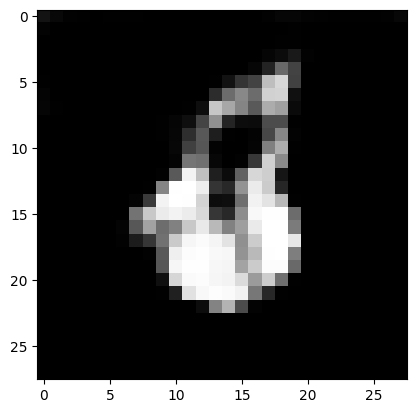

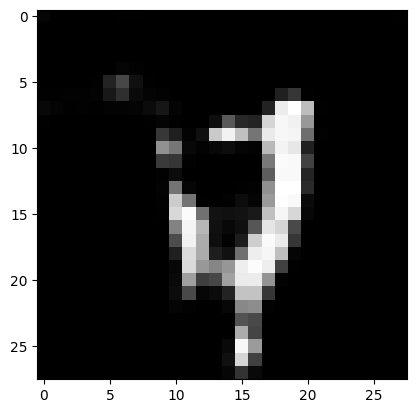

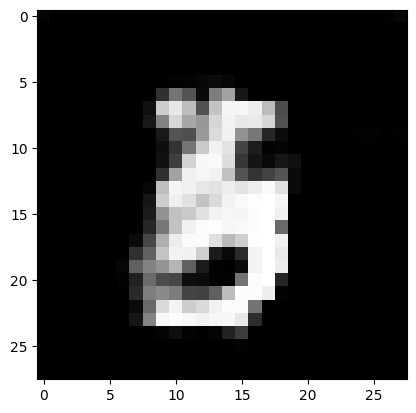

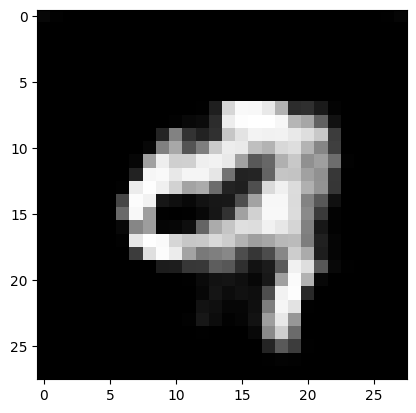

Client 9


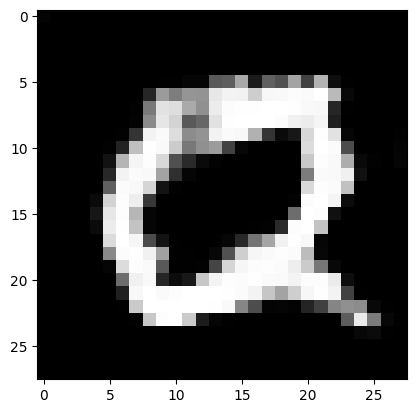

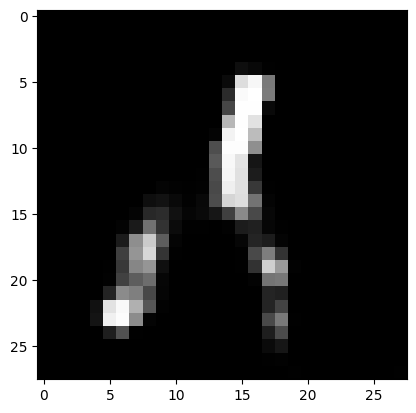

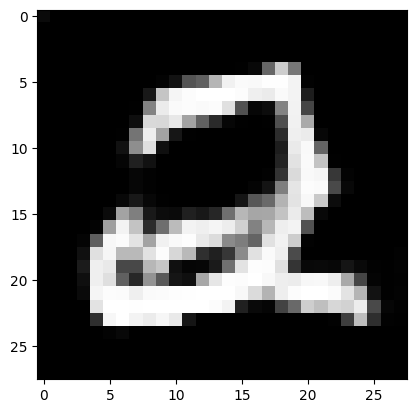

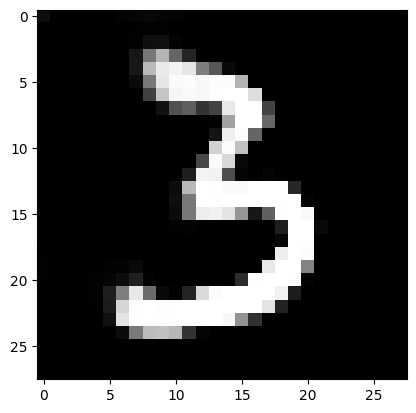

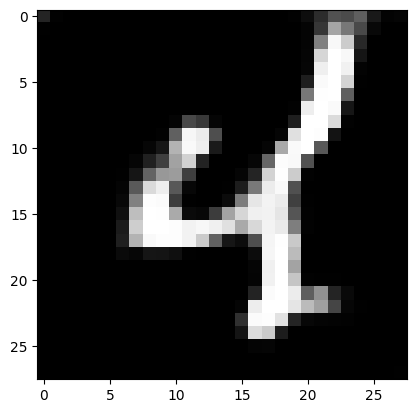

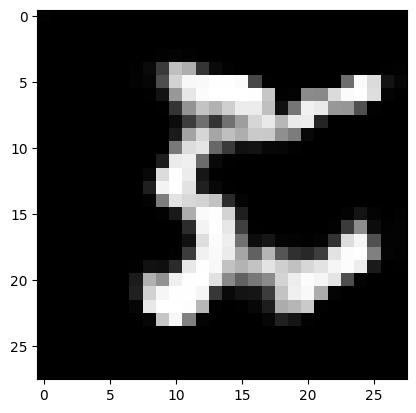

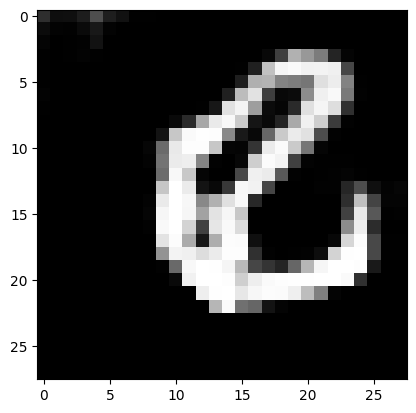

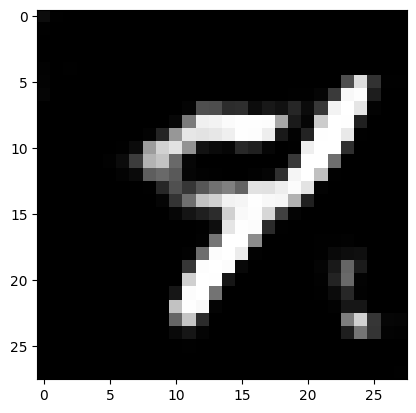

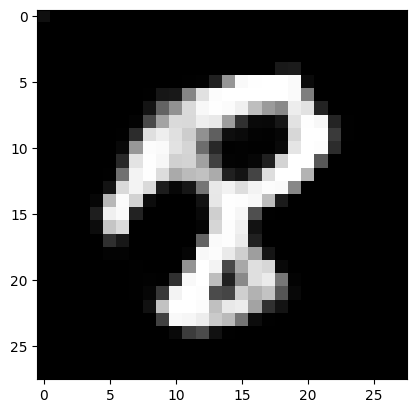

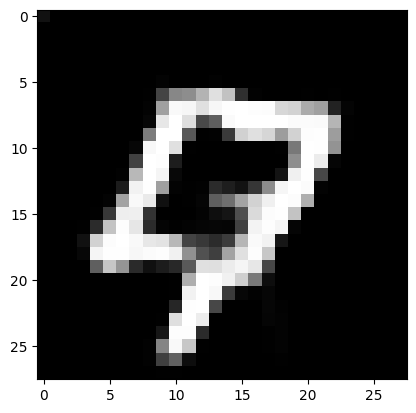

Client 9
Generating 50 fake images of digit 0 ......
Generating 50 fake images of digit 1 ......
Generating 50 fake images of digit 2 ......
Generating 50 fake images of digit 3 ......
Generating 50 fake images of digit 4 ......
Generating 50 fake images of digit 5 ......
Generating 50 fake images of digit 6 ......
Generating 50 fake images of digit 7 ......
Generating 50 fake images of digit 8 ......
Generating 50 fake images of digit 9 ......
Augmented dataset shape: (500, 28, 28, 1), (500,)
Added (1000,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
29/29 [================

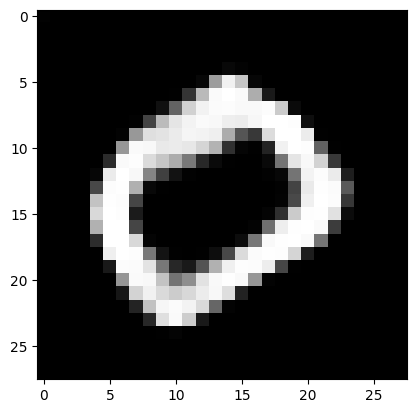

Global 0


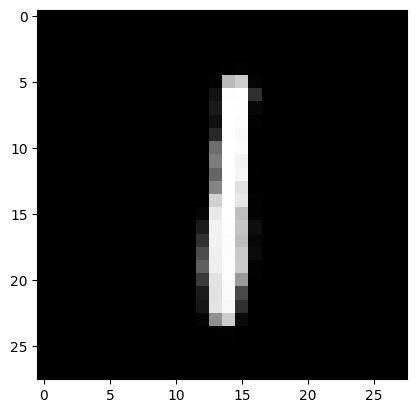

Global 1


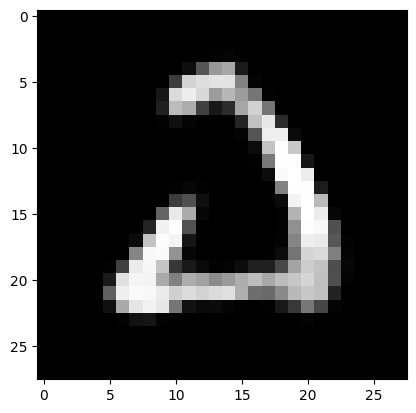

Global 2


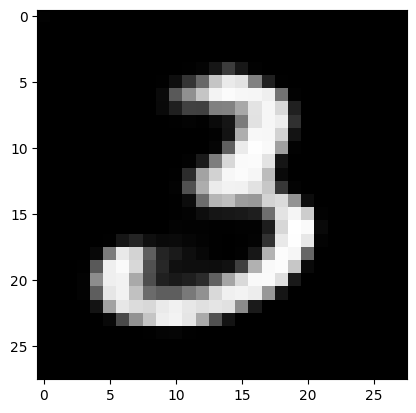

Global 3


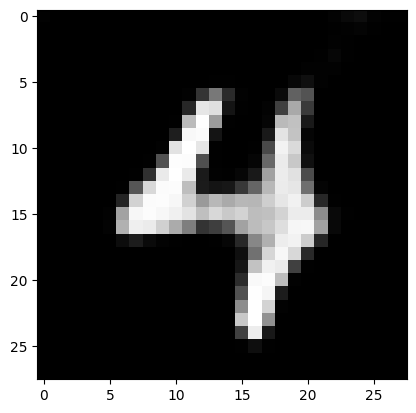

Global 4


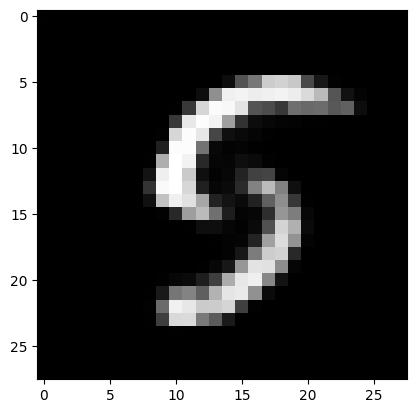

Global 5


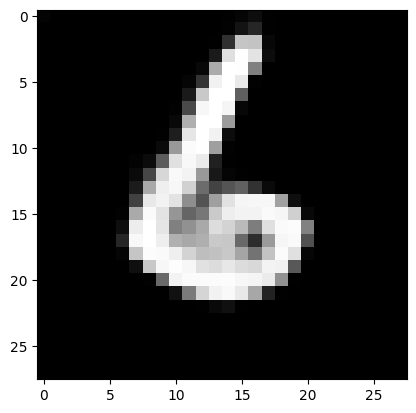

Global 6


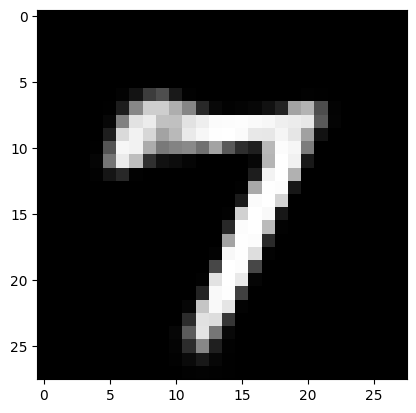

Global 7


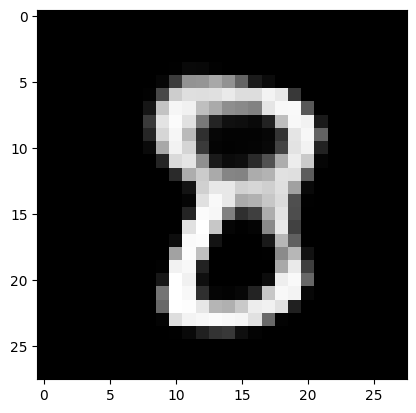

Global 8


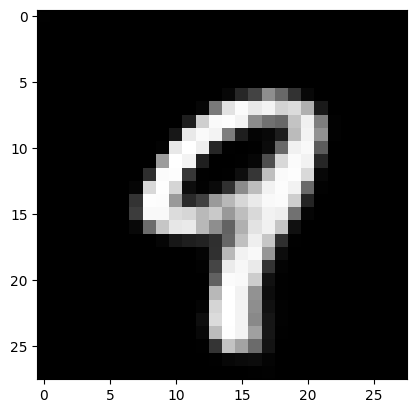

Global 9


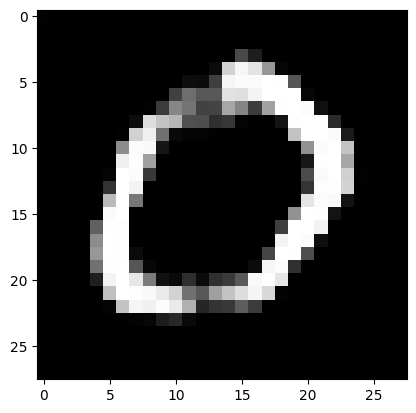

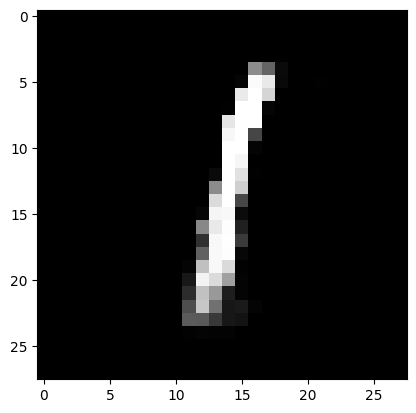

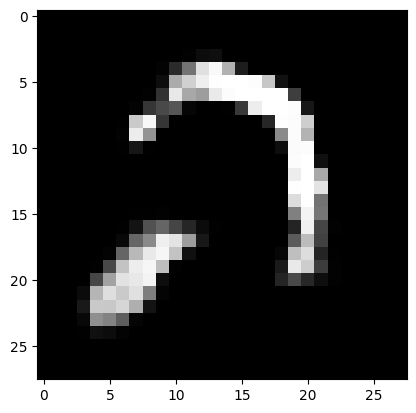

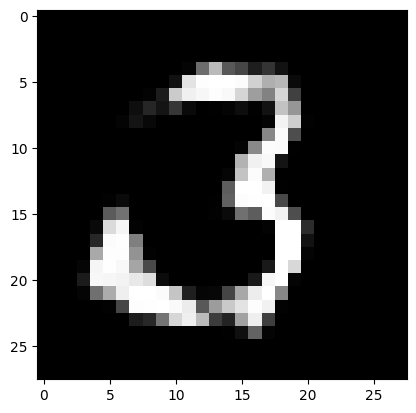

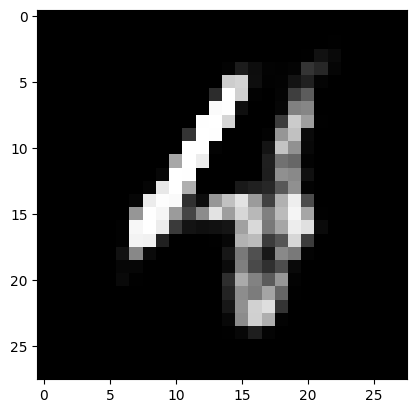

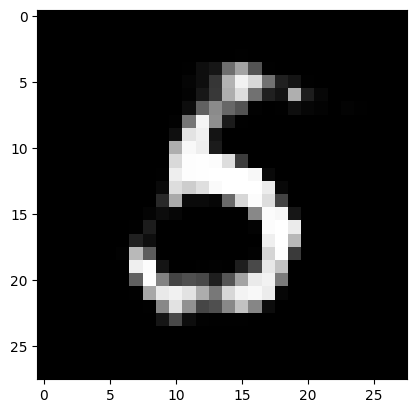

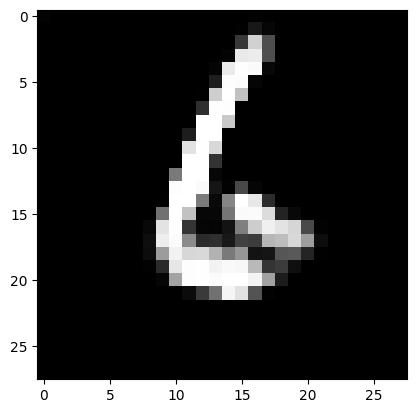

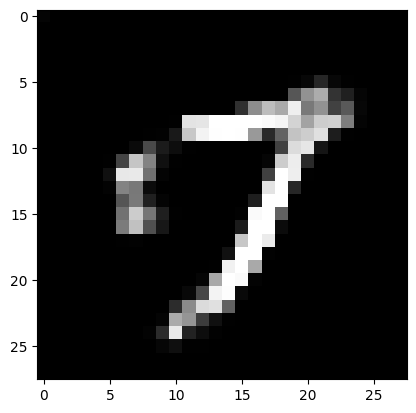

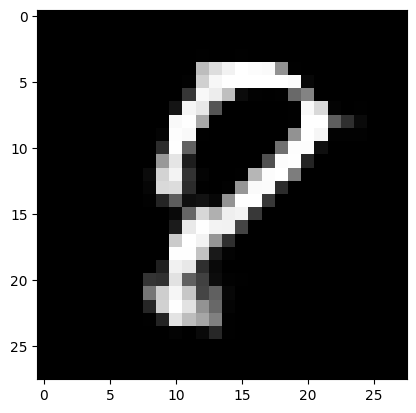

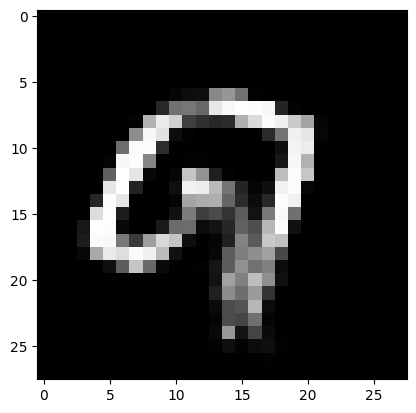

Client 9


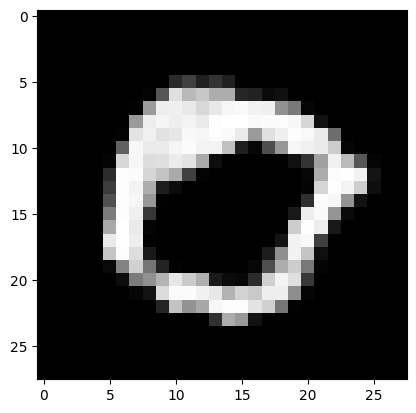

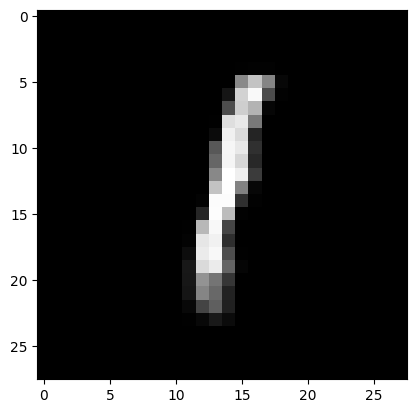

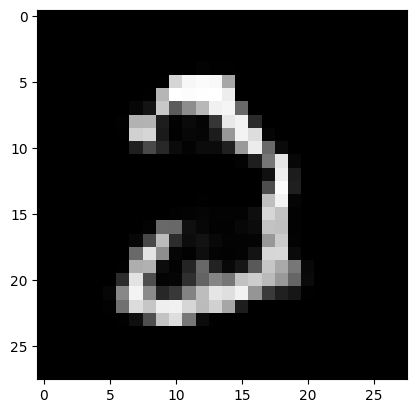

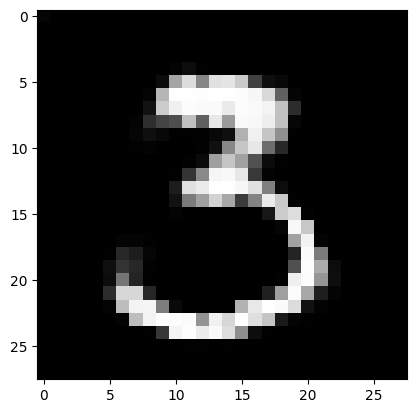

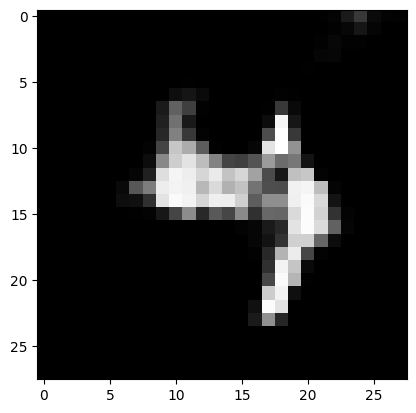

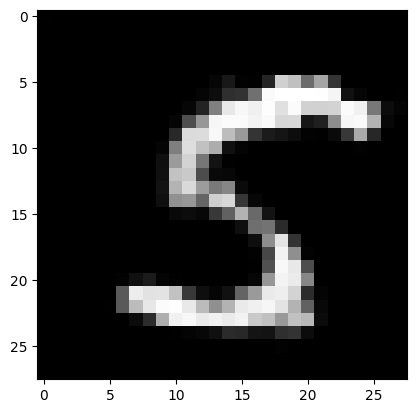

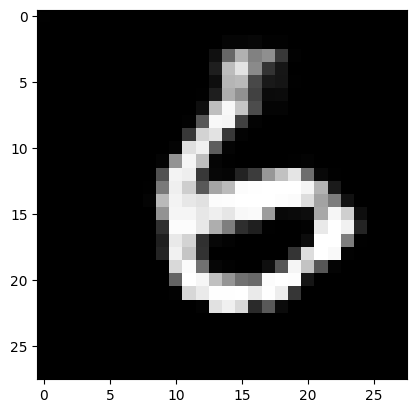

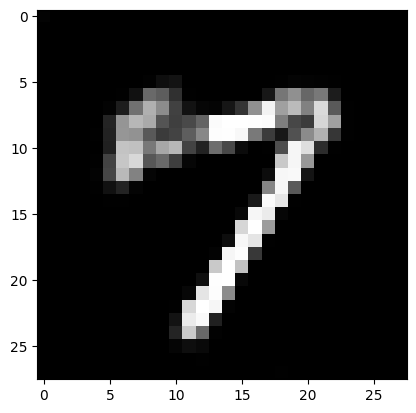

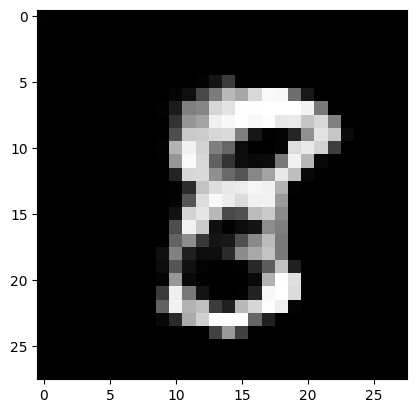

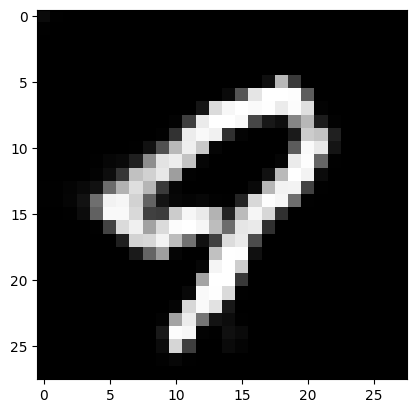

Client 9


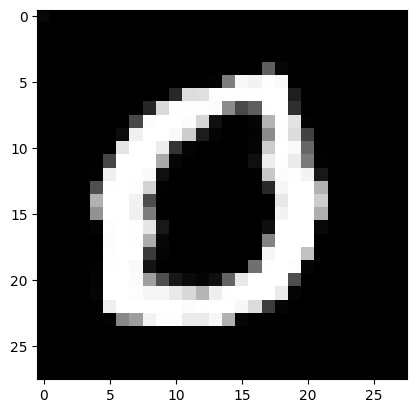

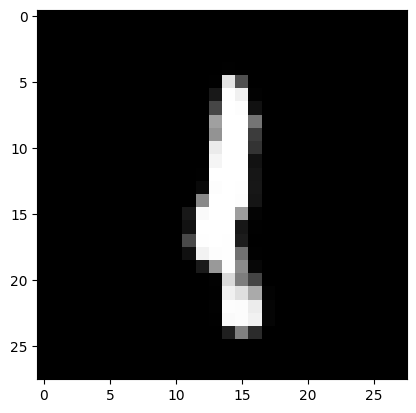

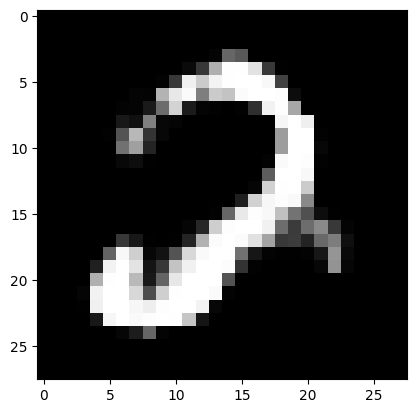

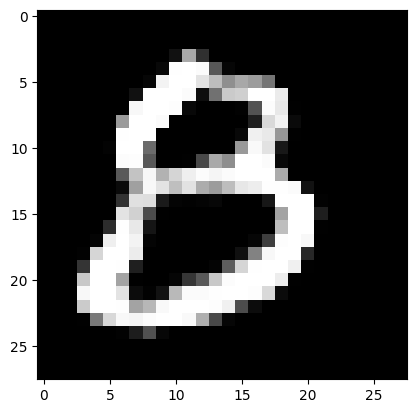

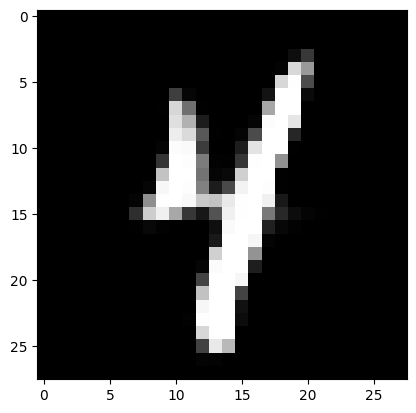

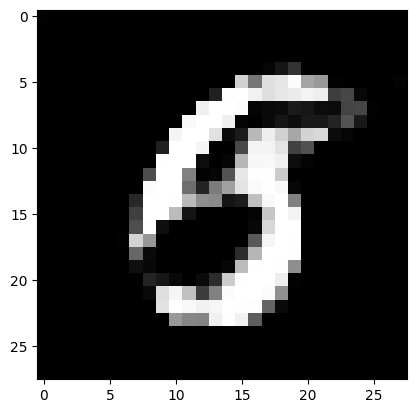

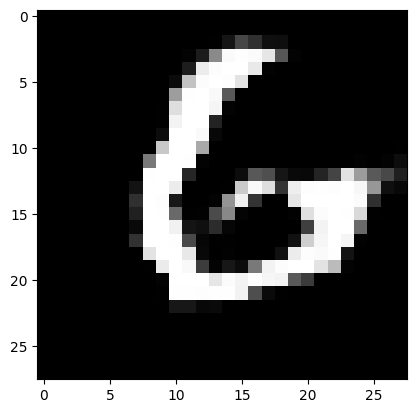

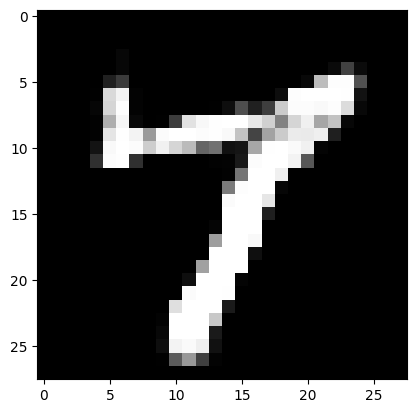

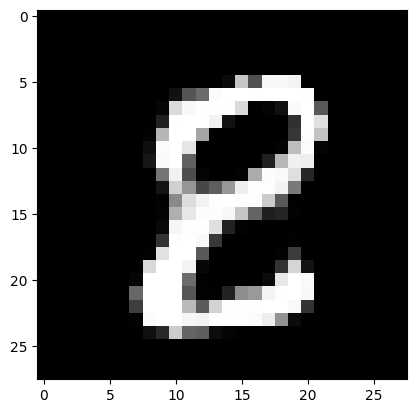

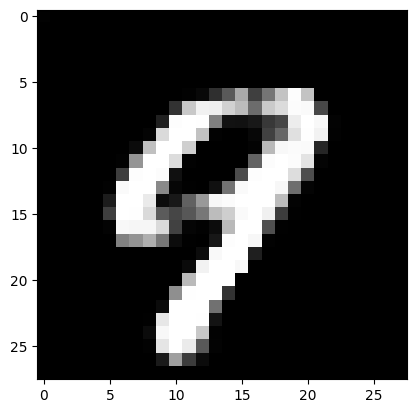

Client 9
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
38/38 [=================

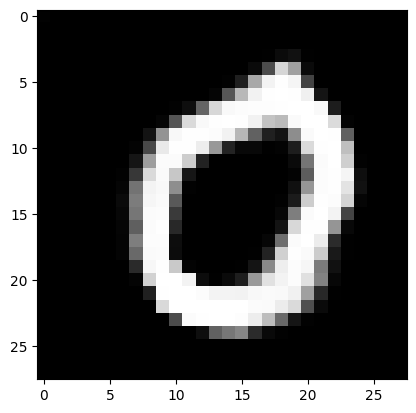

Global 0


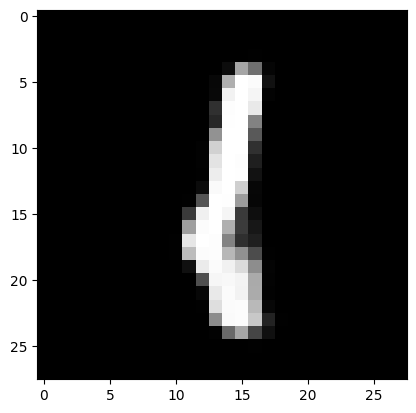

Global 1


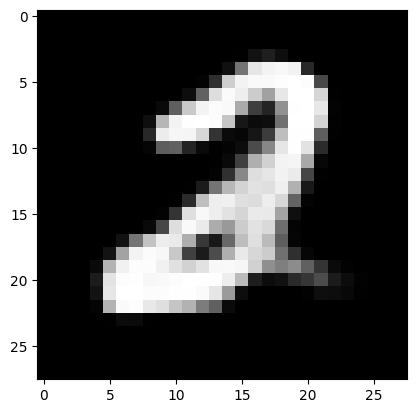

Global 2


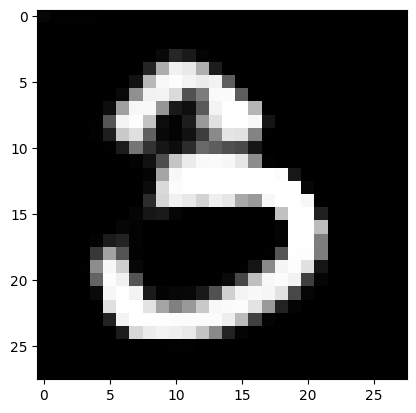

Global 3


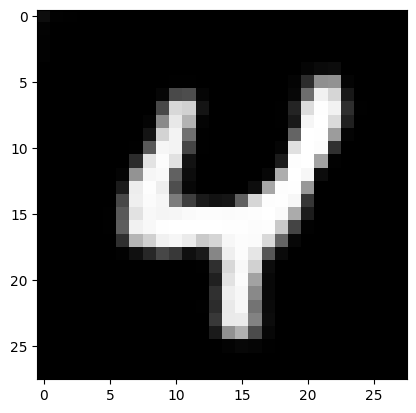

Global 4


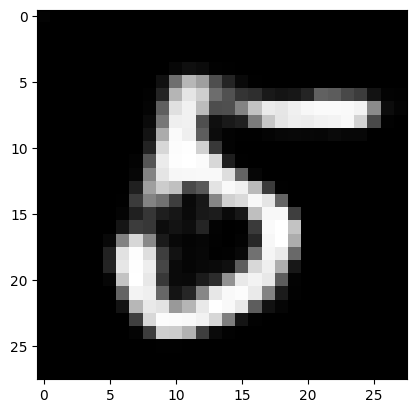

Global 5


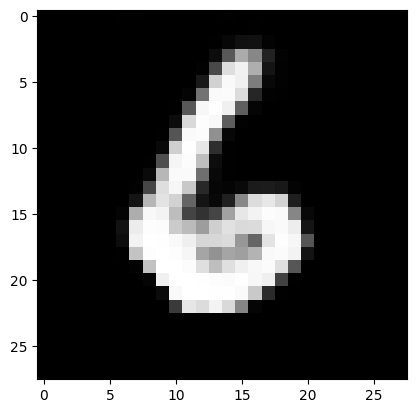

Global 6


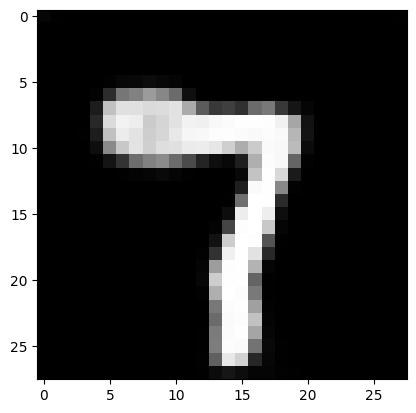

Global 7


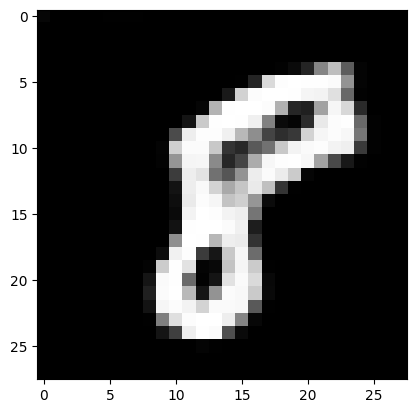

Global 8


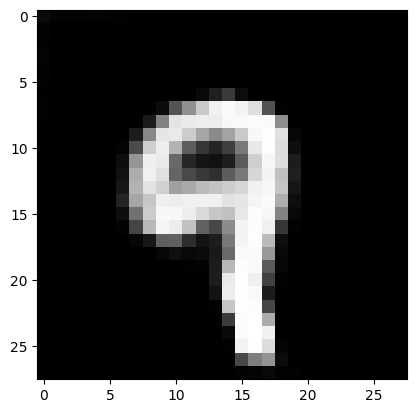

Global 9


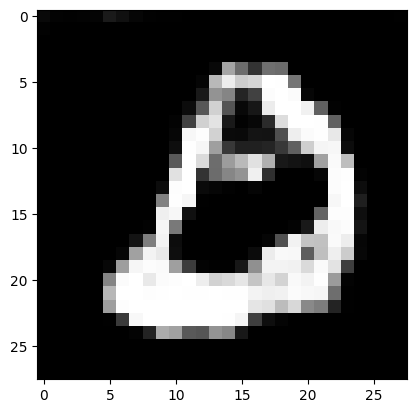

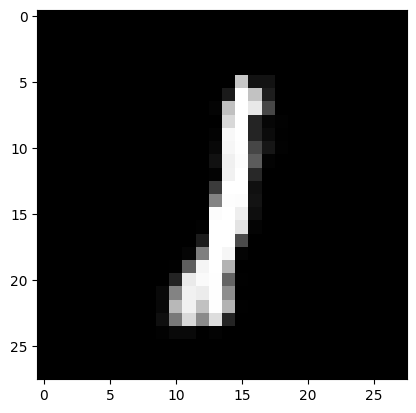

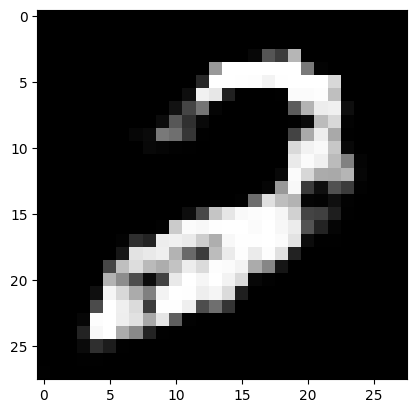

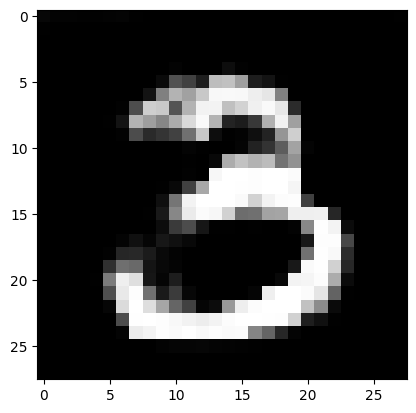

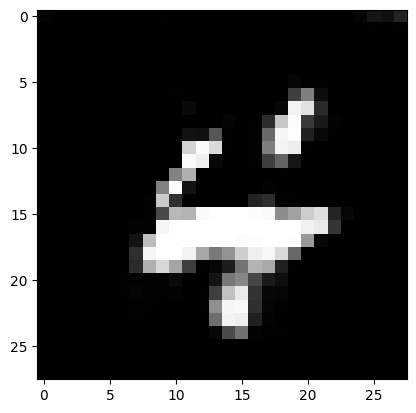

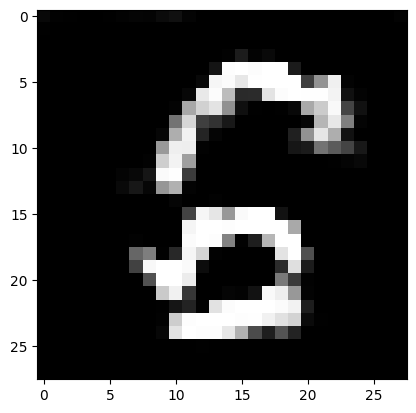

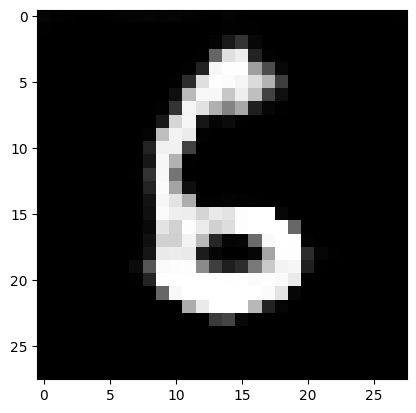

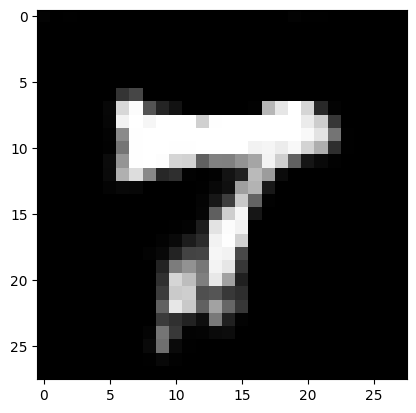

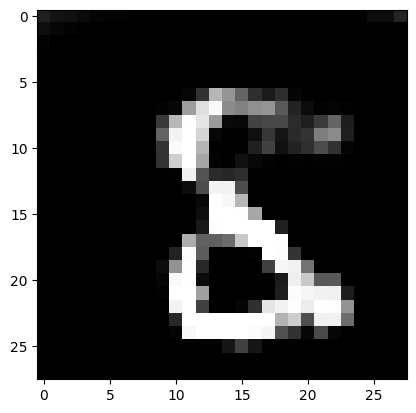

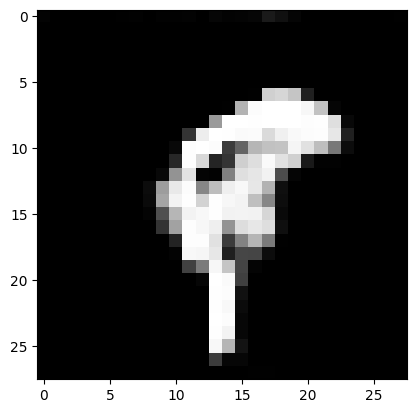

Client 9


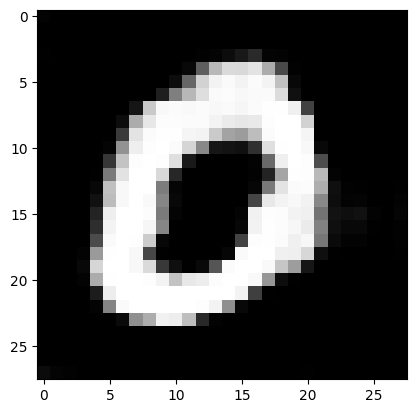

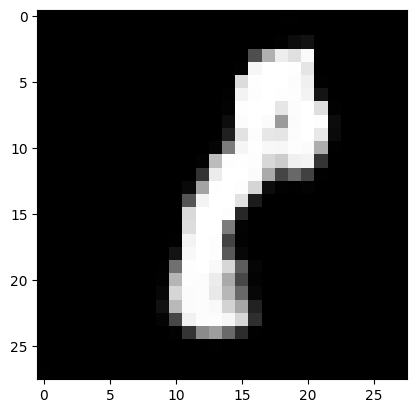

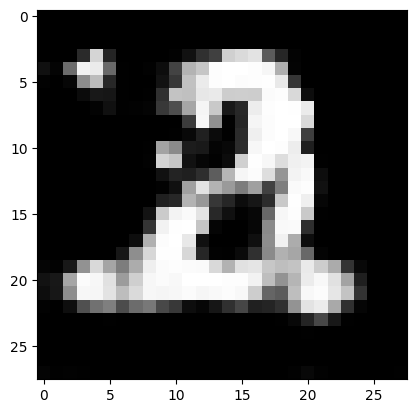

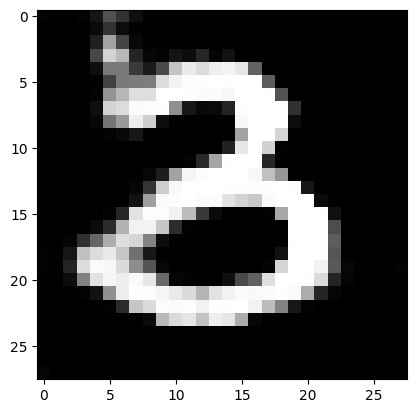

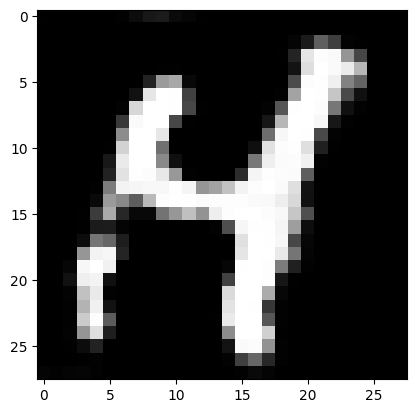

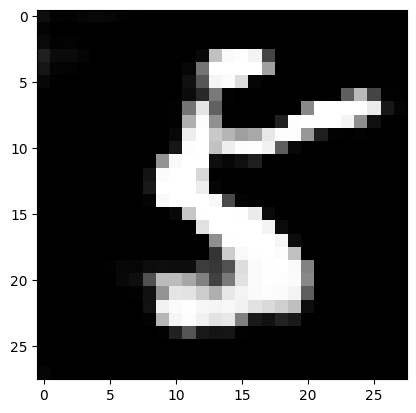

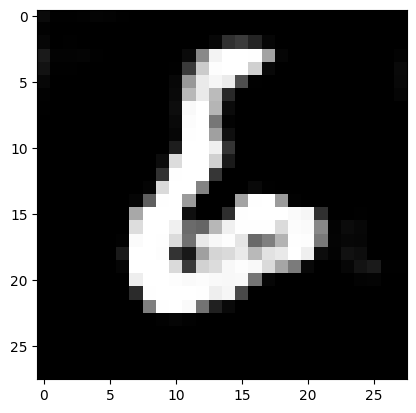

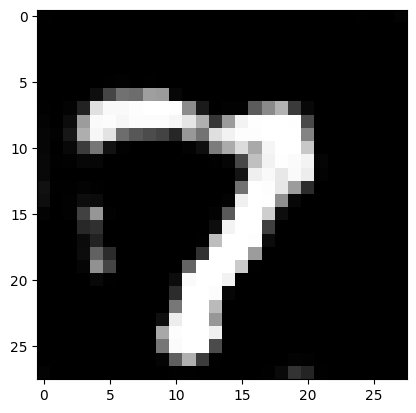

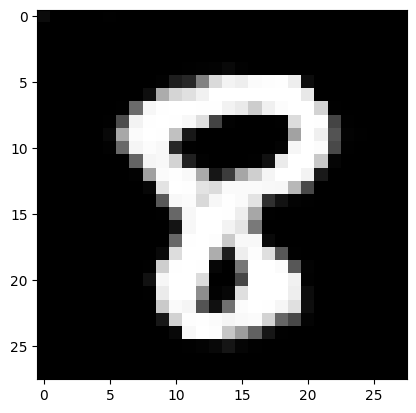

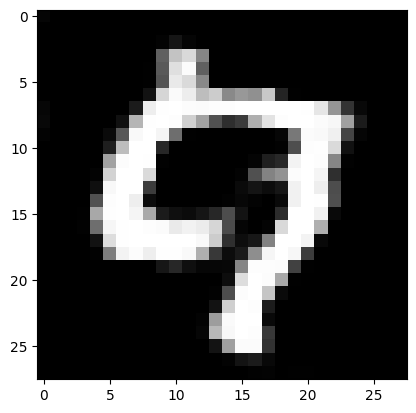

Client 9


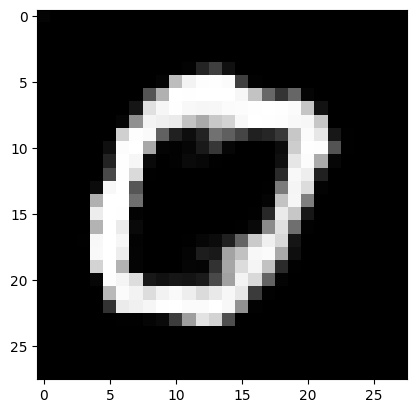

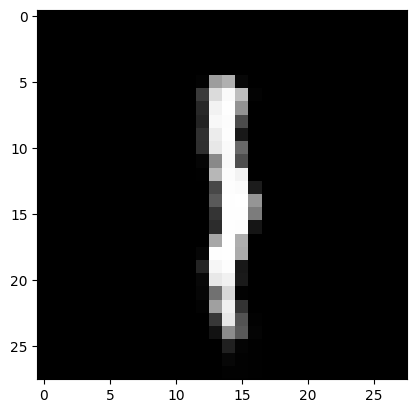

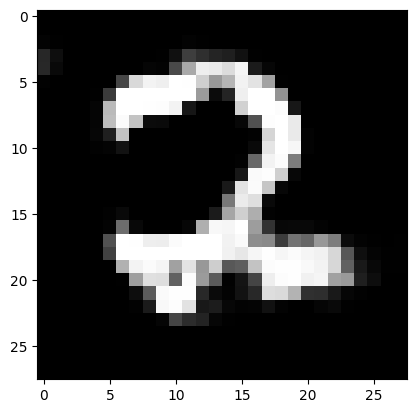

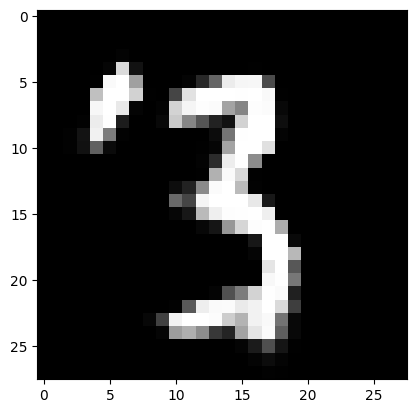

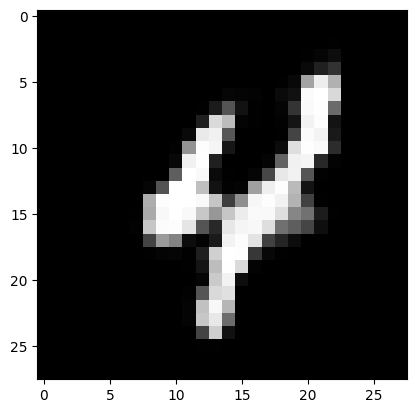

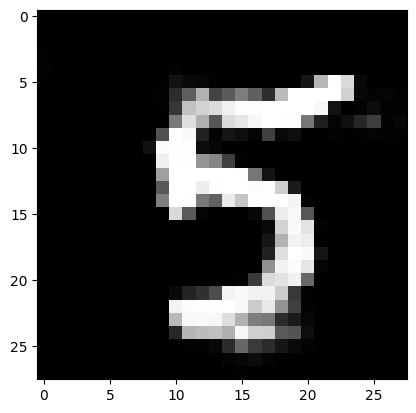

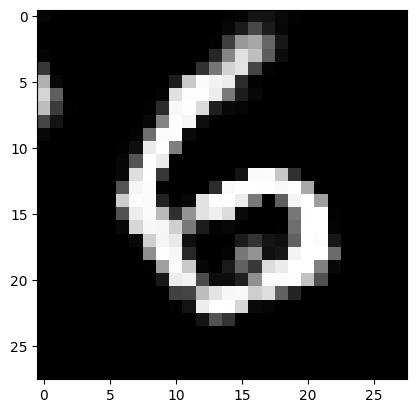

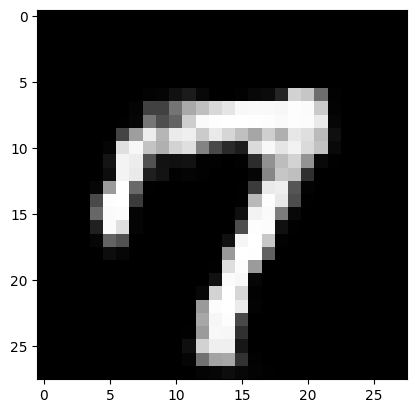

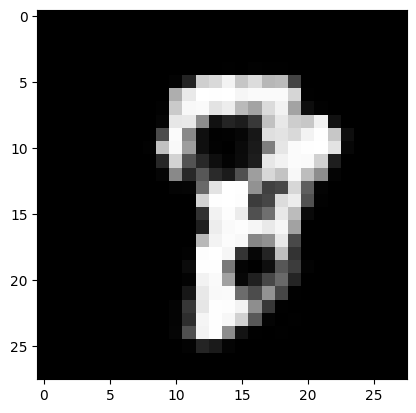

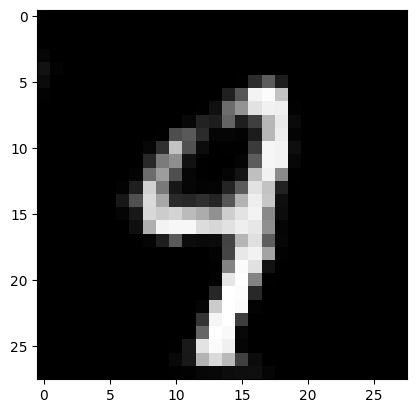

Client 9
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
47/47 [=================

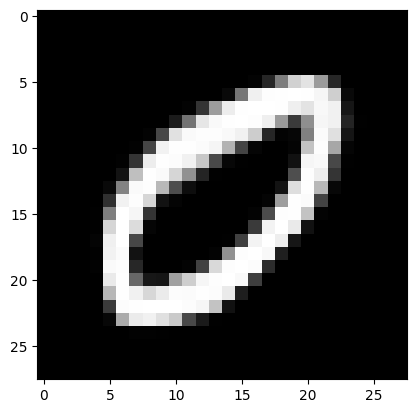

Global 0


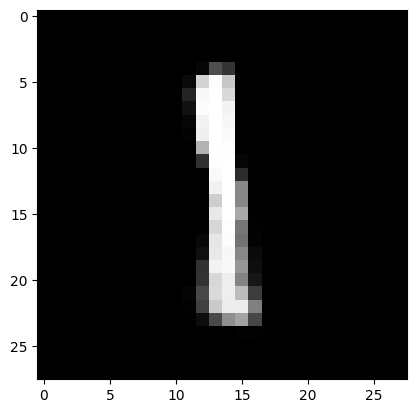

Global 1


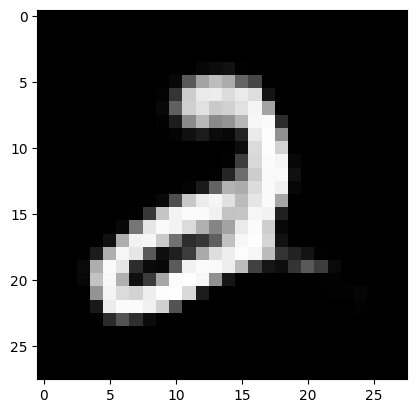

Global 2


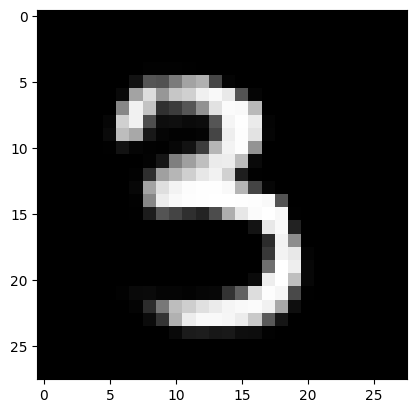

Global 3


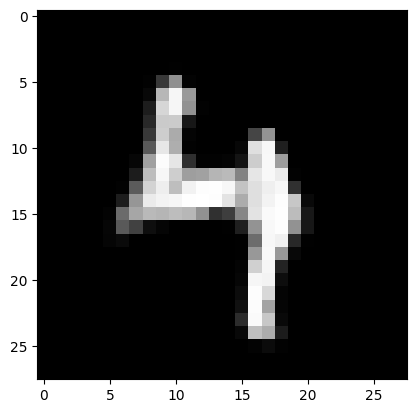

Global 4


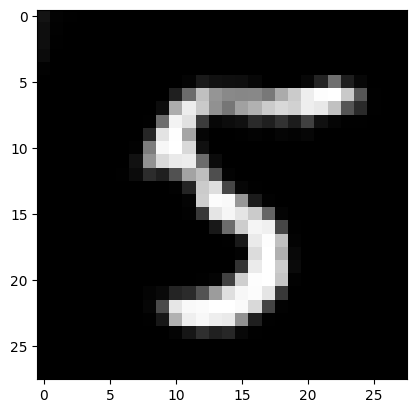

Global 5


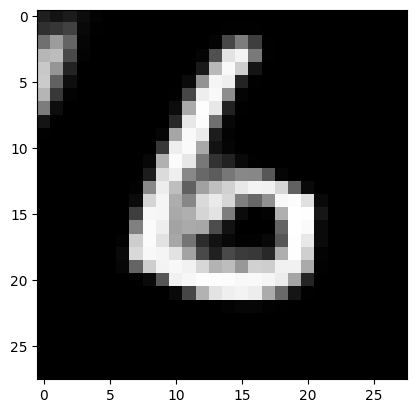

Global 6


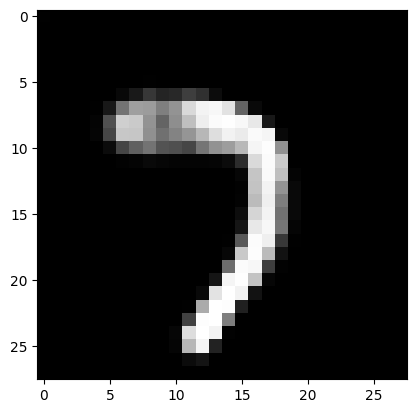

Global 7


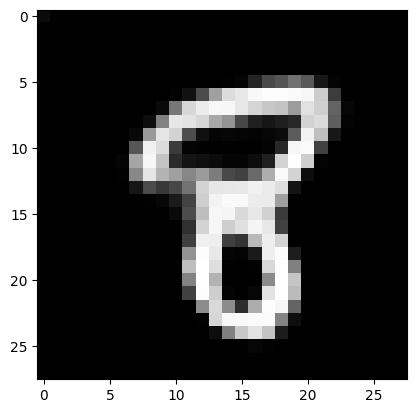

Global 8


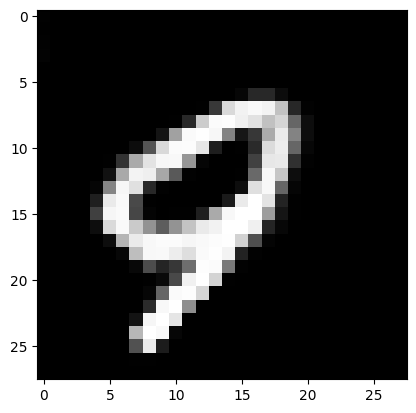

Global 9


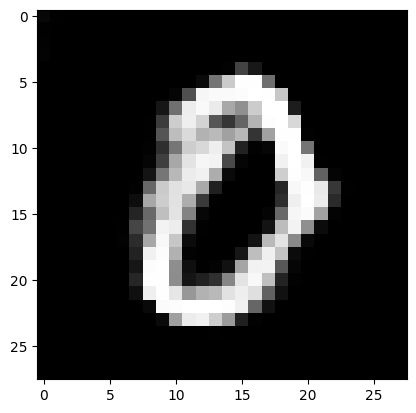

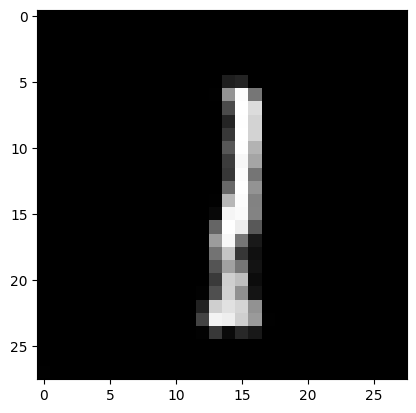

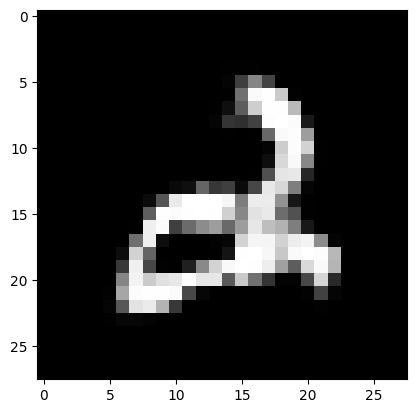

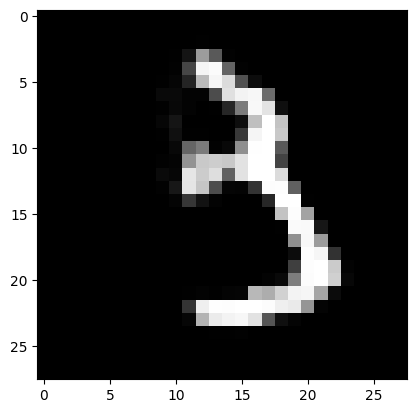

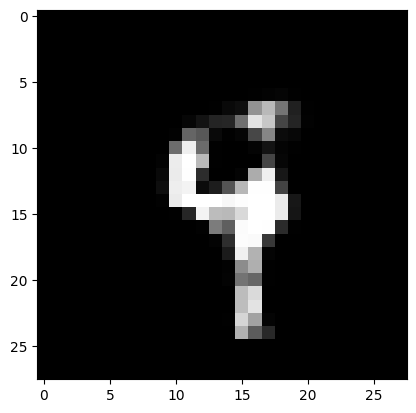

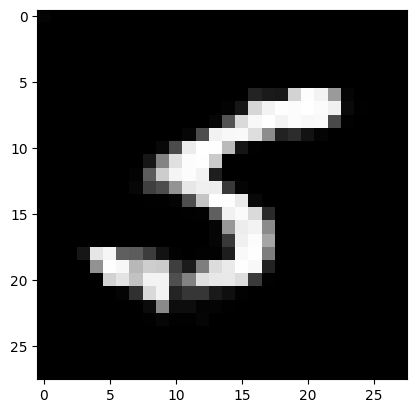

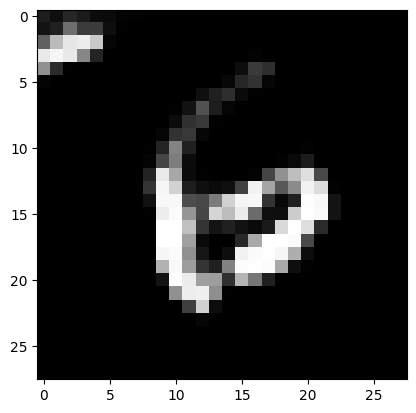

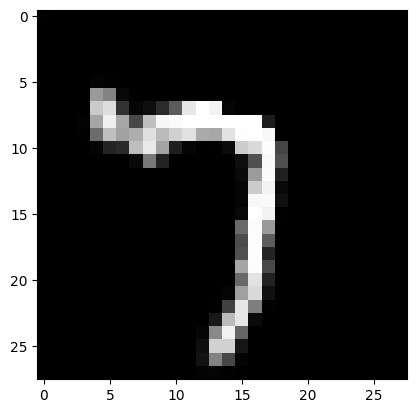

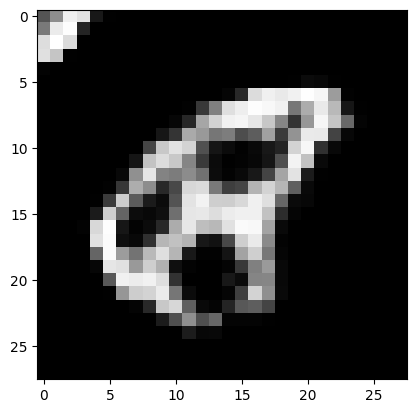

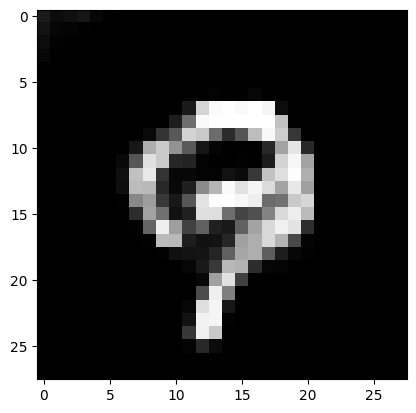

Client 9


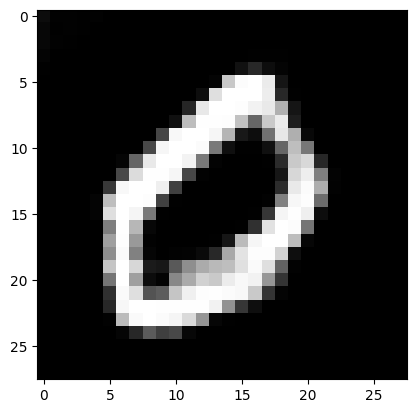

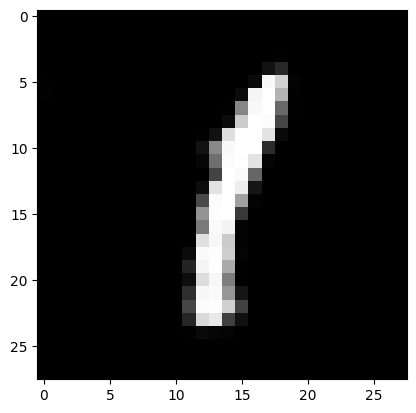

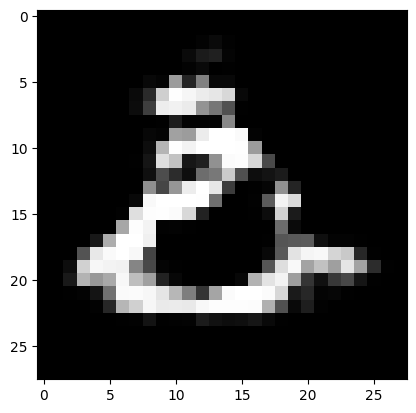

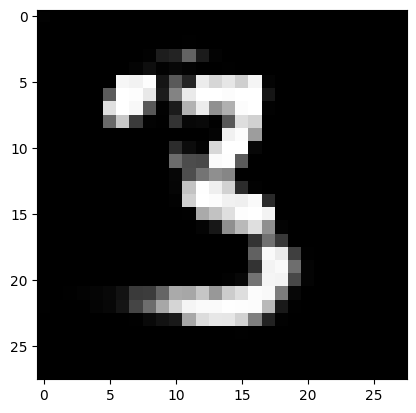

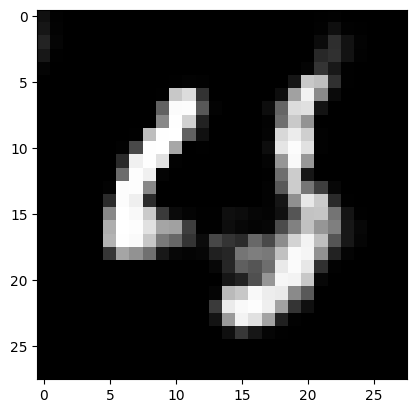

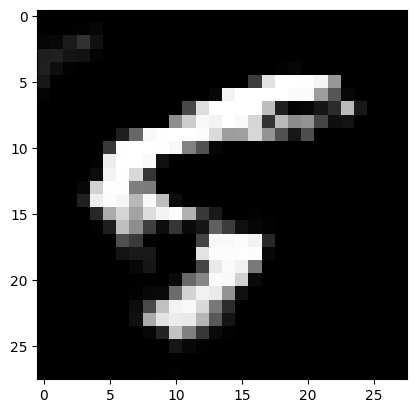

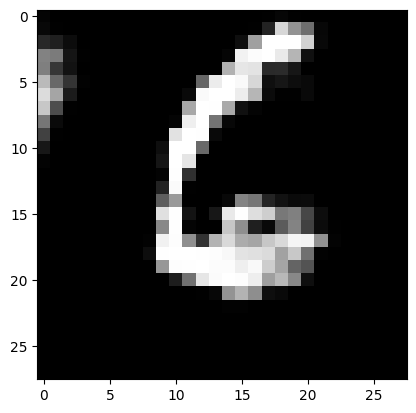

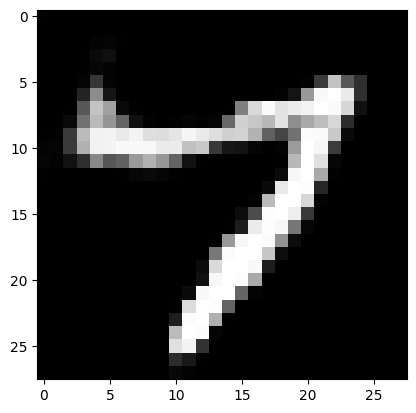

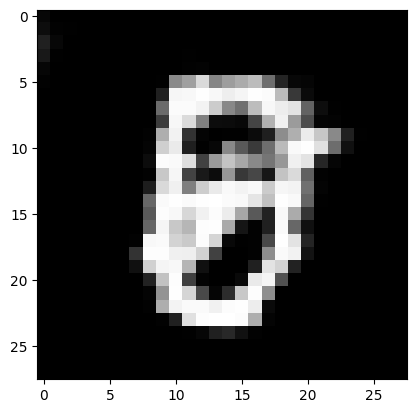

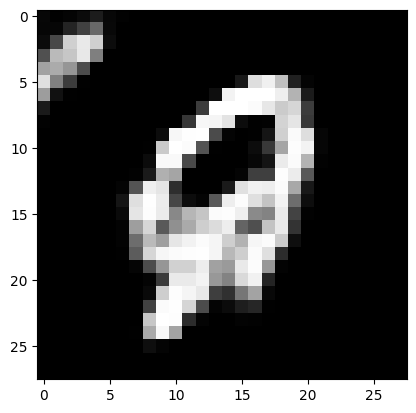

Client 9


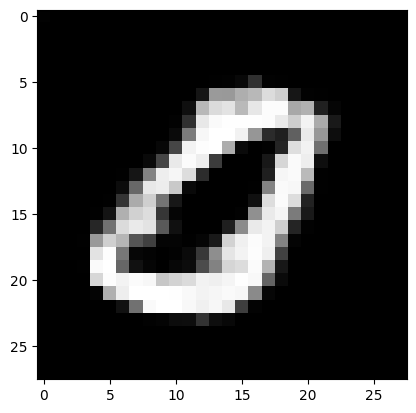

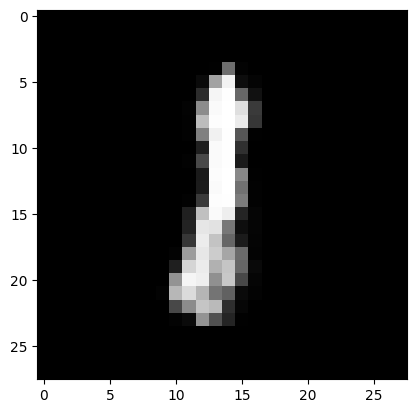

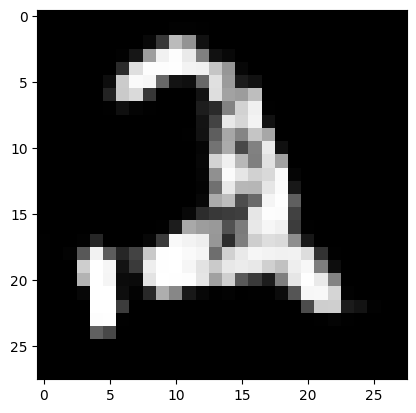

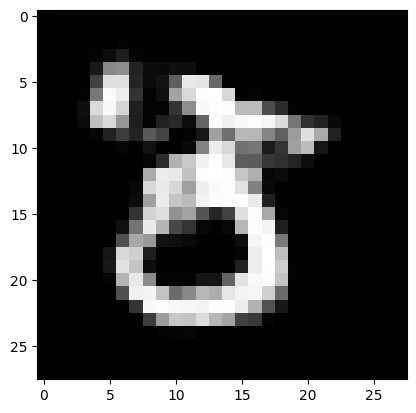

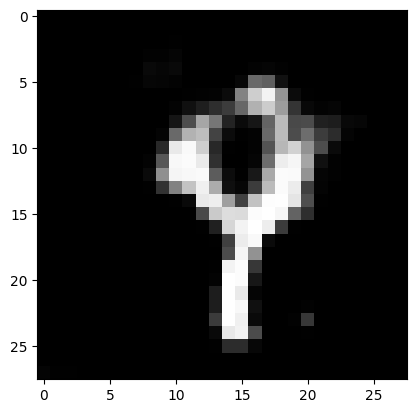

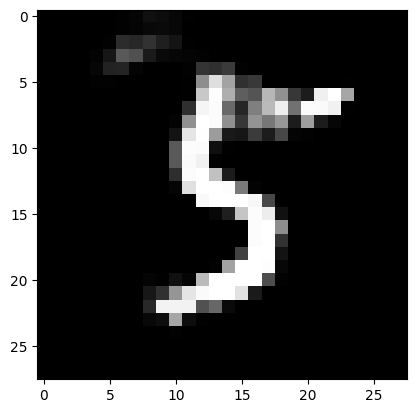

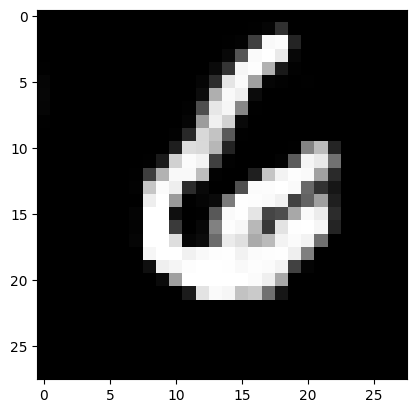

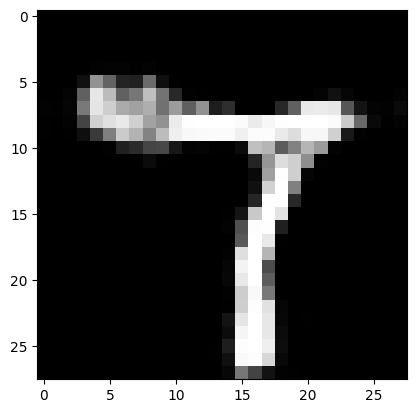

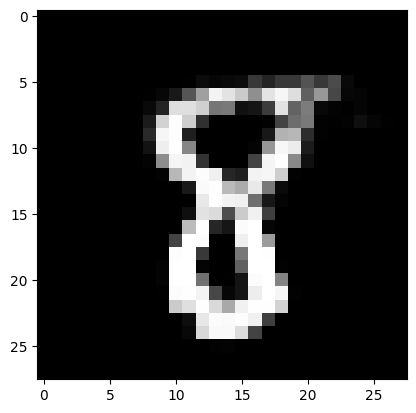

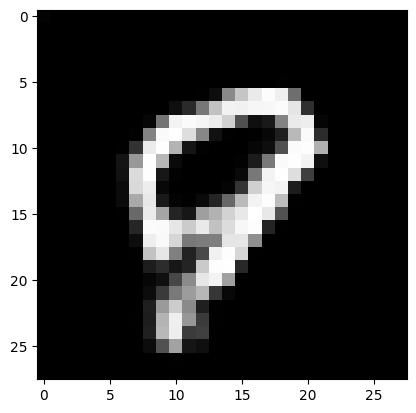

Client 9
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
56/56 [=================

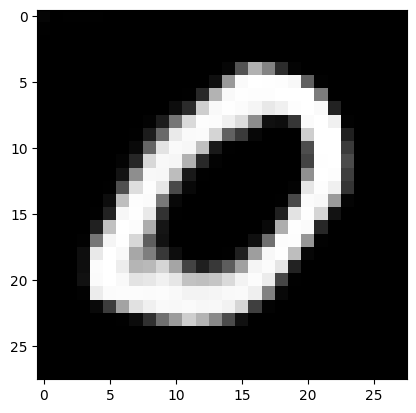

Global 0


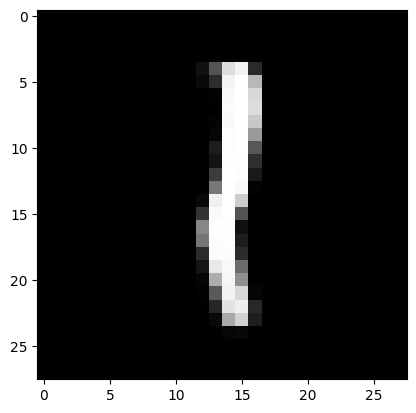

Global 1


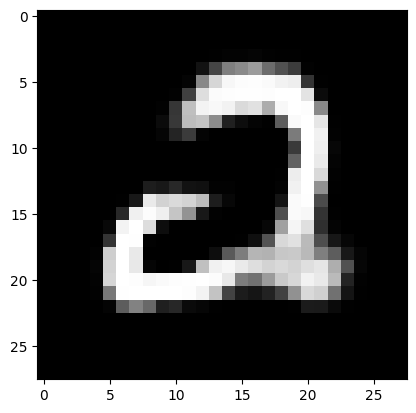

Global 2


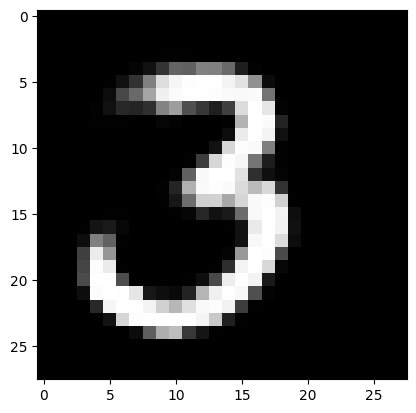

Global 3


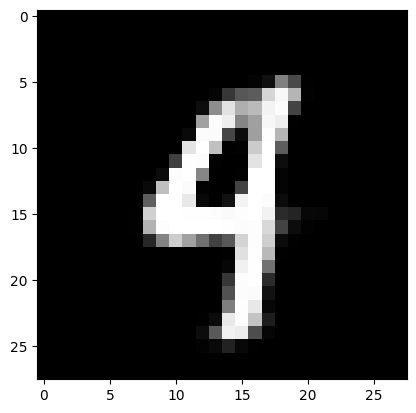

Global 4


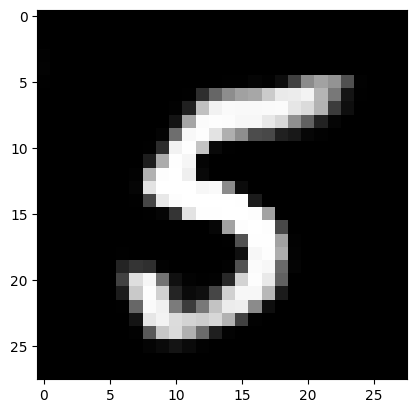

Global 5


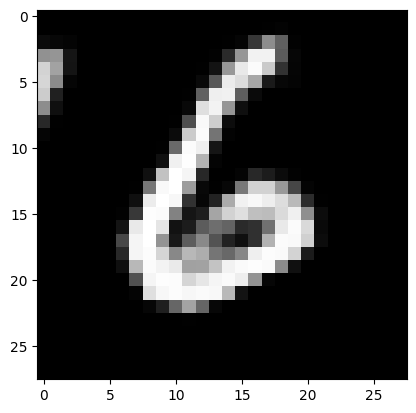

Global 6


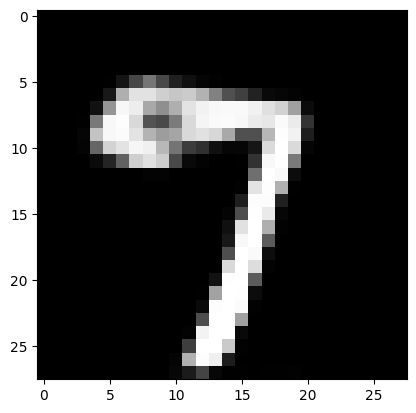

Global 7


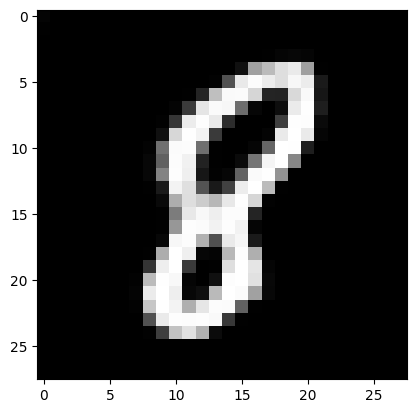

Global 8


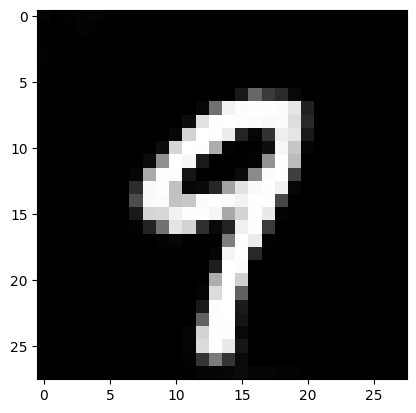

Global 9


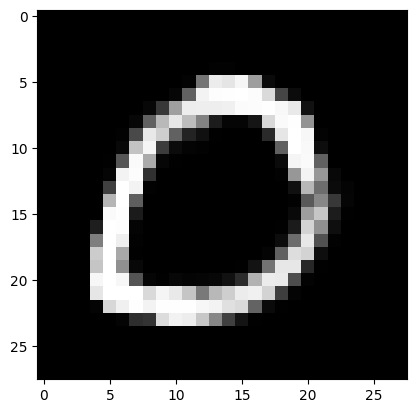

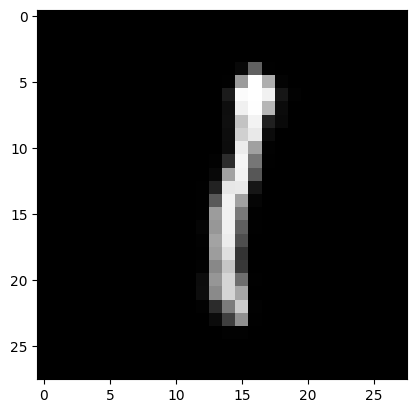

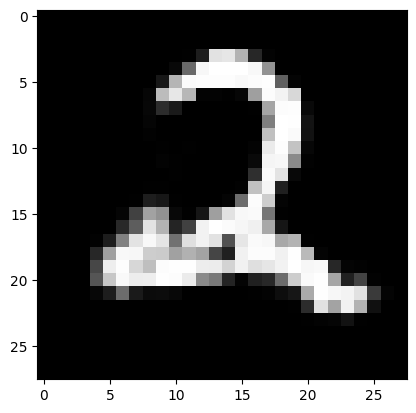

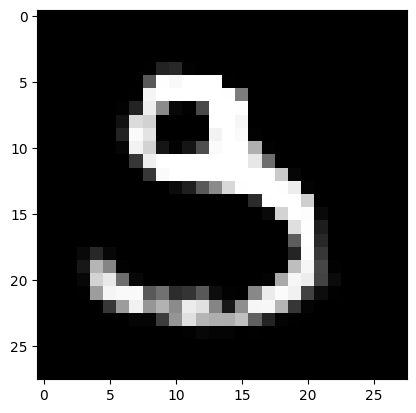

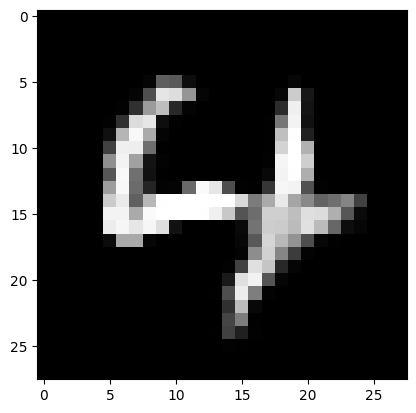

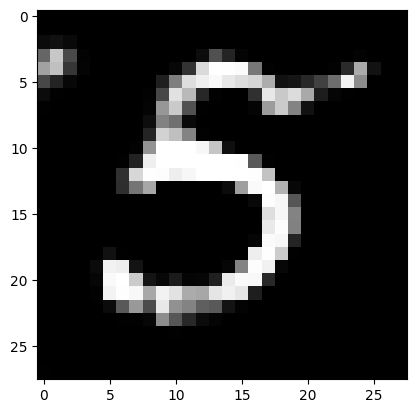

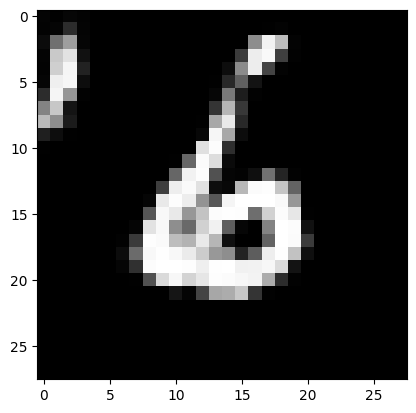

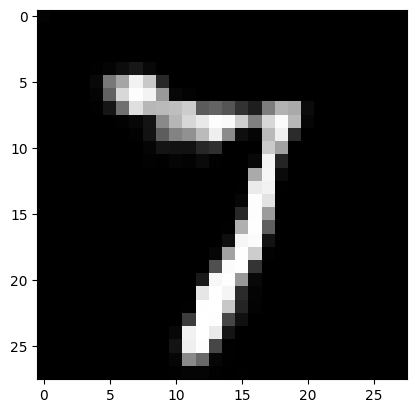

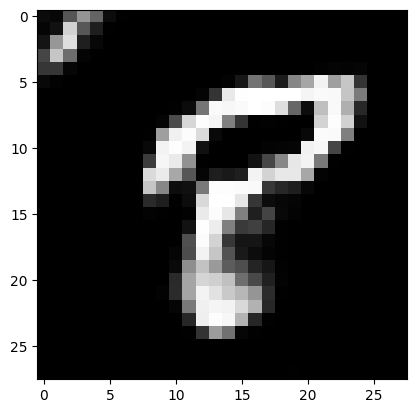

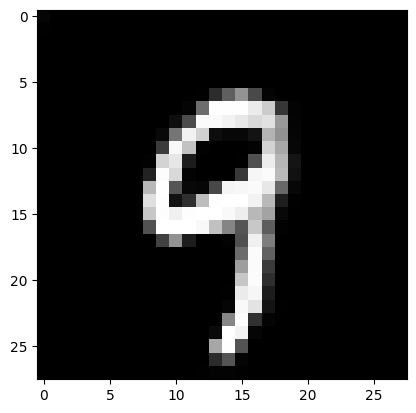

Client 9


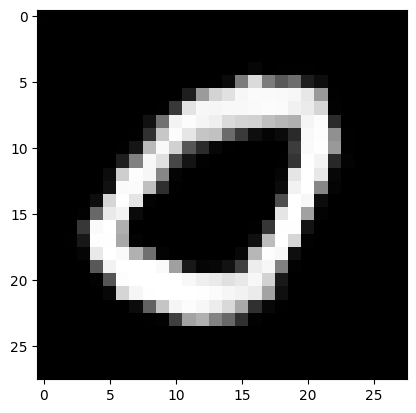

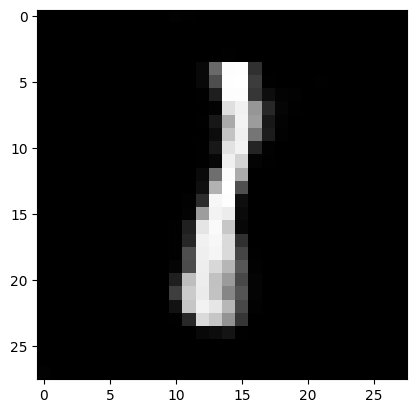

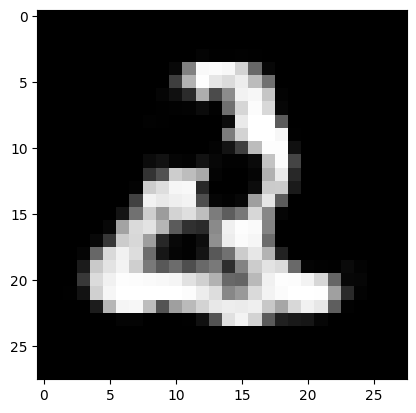

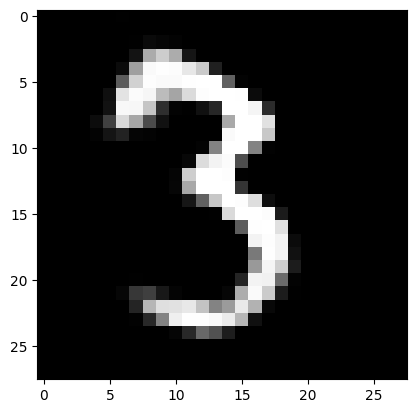

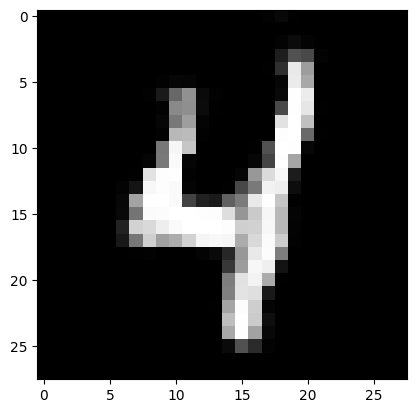

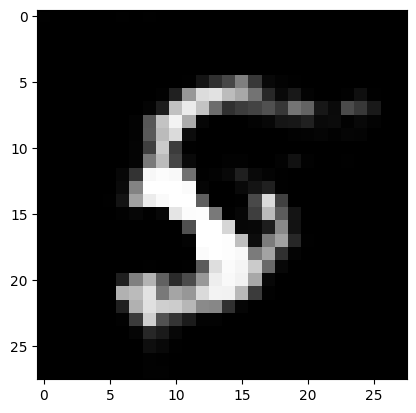

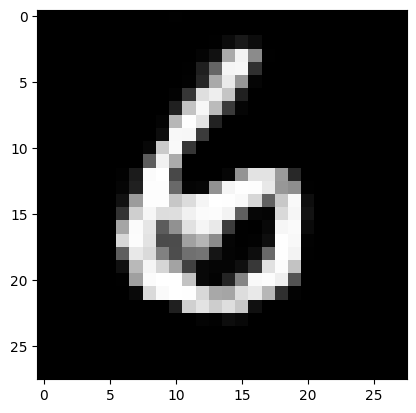

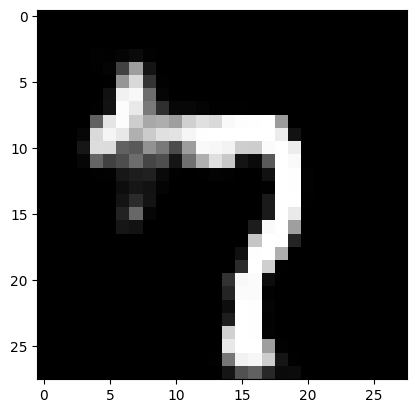

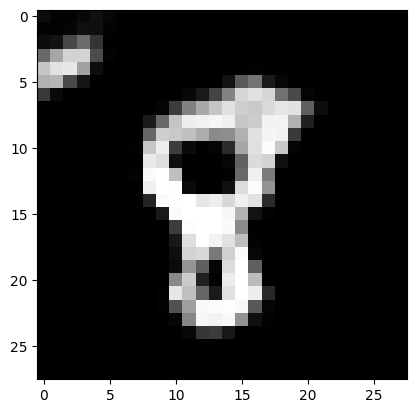

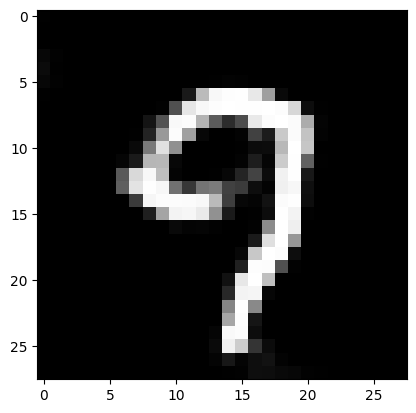

Client 9


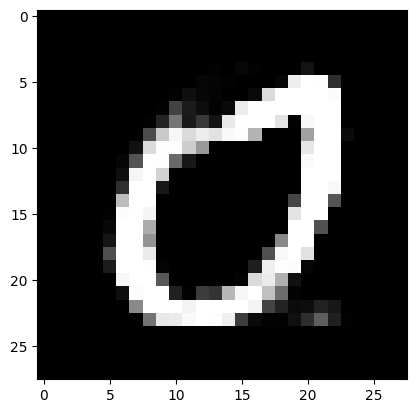

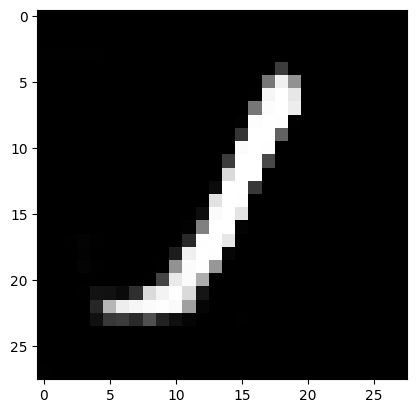

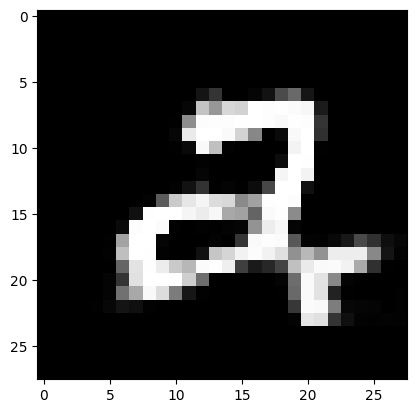

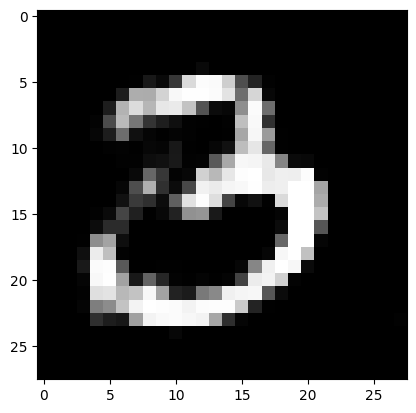

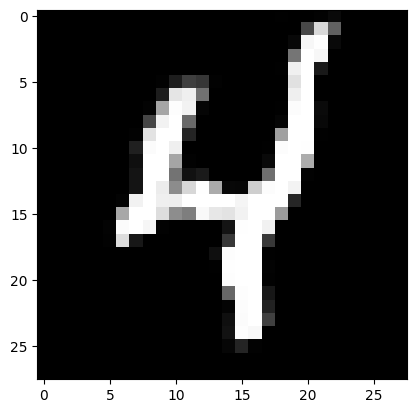

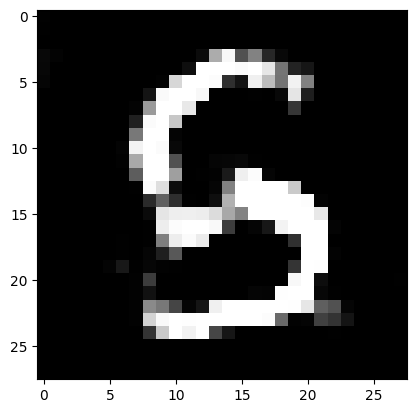

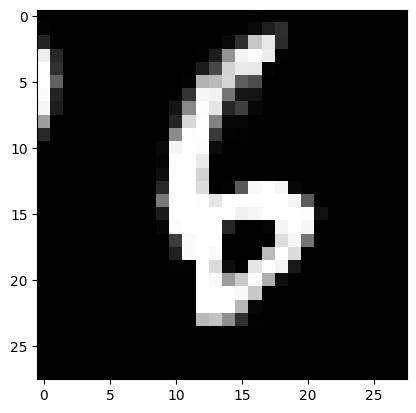

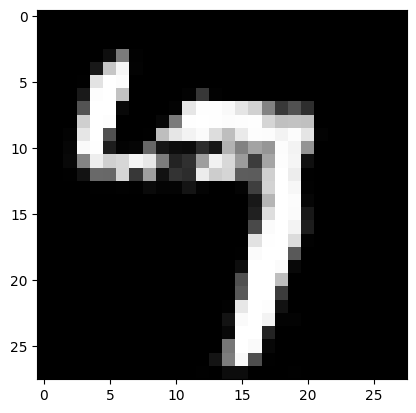

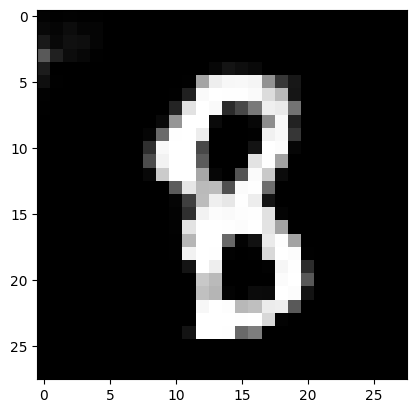

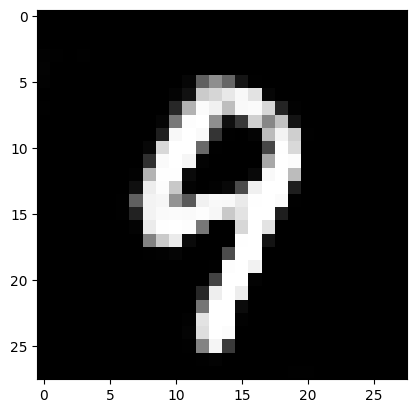

Client 9
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
>>>>>>>>>produced pseudo data
----getting weighted avg of clients' classifier
Epoch 1/3
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
----getting 1 client logits
----getting 1 client logits
----getting 1 client logits
----getting aggregate client logits Tensor("add_1:0", shape=(None, 10), dtype=float32)
65/65 [=================

[nan, 0.09923738986253738]

In [16]:
#initiate 3 clients
no_sample = len(x_train) // 3
client_list = []
for i in range(3):
  #partition dataset to mimic private data
  x_train_k = x_train[no_sample*i:no_sample*(i+1)]
  y_train_k = y_train[no_sample*i:no_sample*(i+1)]
  client_list.append(Client(smallCNN(), x_train_k, y_train_k))

#initiate 1 server
Server = Server(smallCNN(), client_list, comm_freq = 5, algo='FedPKDG')

# Initialisation step
# train all local gan to a good performance (~convergence)
Server.local_training(cnn_epochs = 0, gen_epochs=20, is_earlystop=False)
print('********* ROUND0-initial local generator')
for client in client_list:
  for num in range(10):
    img = generate_image(client.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Client', num)
Server.agg_gen()
print('>>>>>>>>>Weighted aggregated client generator')

total_rounds = 5
for round in range(total_rounds):
  print('********* ROUND',round,'*********')
  target_sparsity = 0.5*(round/total_rounds)
  alpha = 0.9*(1-round/total_rounds)
  Server.broadcast()
  print('>>>>>>>>>Broadcasted weights to all clients')

  Server.local_training(target_sparsity = target_sparsity, fine_tune_epochs=2)
  print('>>>>>>>>>trained all clients cnn round', _)

  Server.agg_gen()
  print('>>>>>>>>>Weighted aggregated client generator')

# to see the quality of generators
  for num in range(10):
    img = generate_image(Server.generator, num, 128)
    plt.imshow(img[0], cmap='gray')
    plt.show()
    print('Global', num)
  for client in client_list:
    for num in range(10):
      img = generate_image(client.generator, num, 128)
      plt.imshow(img[0], cmap='gray')
      plt.show()
    print('Client', num)

  if round==0:
    Server.produce_pseudo_dataset(total_num=1000)
  else:
    Server.produce_pseudo_dataset()
  print('>>>>>>>>>produced pseudo data')

  Server.distill_to_global()
  print('>>>>>>>>>Knowledge distilled from clients and updated global weights')

Server.broadcast()
print('>>>>>>>>>Broadcasted weights to all clients')
Server.local_training()
print('>>>>>>>>>trained all clients cnn final round')
for client in client_list:
  print('local models evaluation')
  client.cnn.evaluate(x_test, y_test)
print('global model evaluation')
Server.cnn.evaluate(x_test, y_test)

In [21]:
for _ in range(50):
  Server.produce_pseudo_dataset()

Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape: (160, 28, 28, 1), (160,)
Added (320,) data points to the public dataset
Generating 16 fake images of digit 0 ......
Generating 16 fake images of digit 1 ......
Generating 16 fake images of digit 2 ......
Generating 16 fake images of digit 3 ......
Generating 16 fake images of digit 4 ......
Generating 16 fake images of digit 5 ......
Generating 16 fake images of digit 6 ......
Generating 16 fake images of digit 7 ......
Generating 16 fake images of digit 8 ......
Generating 16 fake images of digit 9 ......
Augmented dataset shape

In [22]:
Server.x_public.shape

(18600, 28, 28, 1)

In [23]:
model = smallCNN()
x = Server.x_public
y = Server.y_public
model.compile(
        optimizer='adam',
        loss=keras_model.losses.SparseCategoricalCrossentropy(from_logits=True),
        metrics=[keras_model.metrics.SparseCategoricalAccuracy()]
      )

model.fit(x,y, batch_size=128, epochs=6,validation_split=0.1)

Epoch 1/6
131/131 [==============================] - 3s 8ms/step - loss: nan - sparse_categorical_accuracy: 0.1526 - val_loss: nan - val_sparse_categorical_accuracy: 0.1532
Epoch 2/6
131/131 [==============================] - 1s 4ms/step - loss: nan - sparse_categorical_accuracy: 0.1533 - val_loss: nan - val_sparse_categorical_accuracy: 0.1532
Epoch 3/6
131/131 [==============================] - 1s 4ms/step - loss: nan - sparse_categorical_accuracy: 0.1533 - val_loss: nan - val_sparse_categorical_accuracy: 0.1532
Epoch 4/6
131/131 [==============================] - 1s 4ms/step - loss: nan - sparse_categorical_accuracy: 0.1533 - val_loss: nan - val_sparse_categorical_accuracy: 0.1532
Epoch 5/6
131/131 [==============================] - 1s 5ms/step - loss: nan - sparse_categorical_accuracy: 0.1533 - val_loss: nan - val_sparse_categorical_accuracy: 0.1532
Epoch 6/6
131/131 [==============================] - 1s 5ms/step - loss: nan - sparse_categorical_accuracy: 0.1533 - val_loss: nan - va

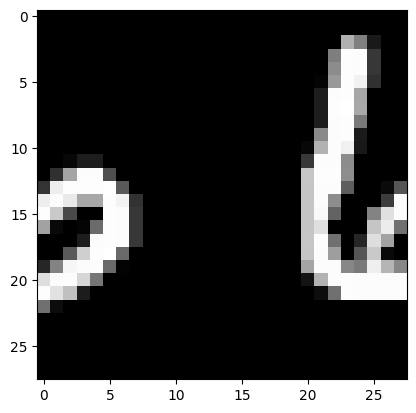

idx: 2578
-1840270120


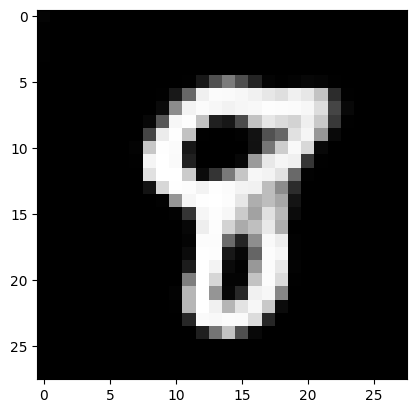

idx: 13620
8


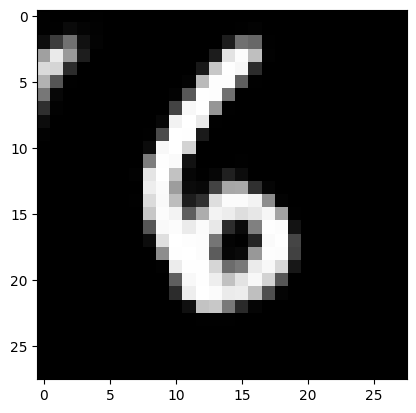

idx: 18065
6


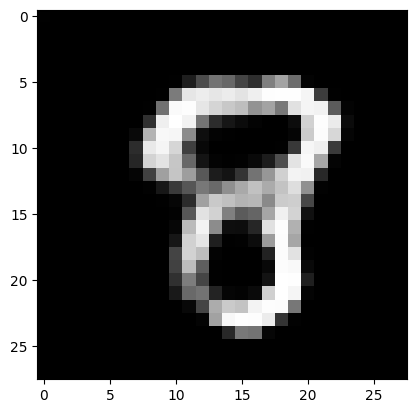

idx: 1137
8


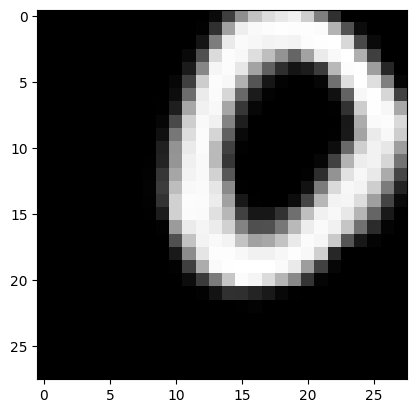

idx: 1527
0


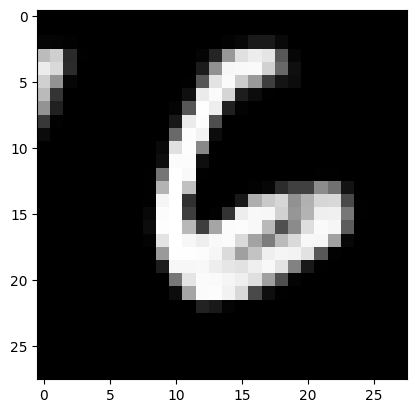

idx: 11668
6


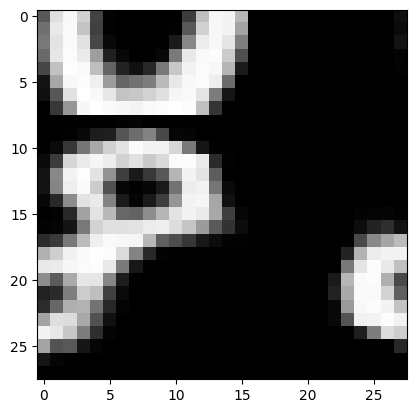

idx: 4489
0


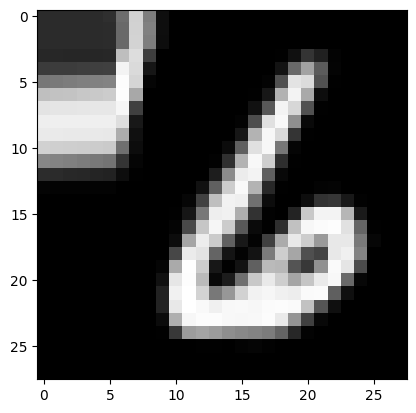

idx: 6056
6


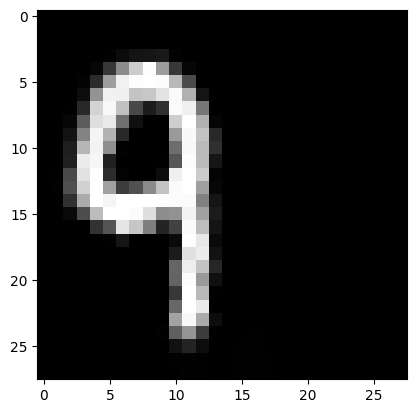

idx: 18522
9


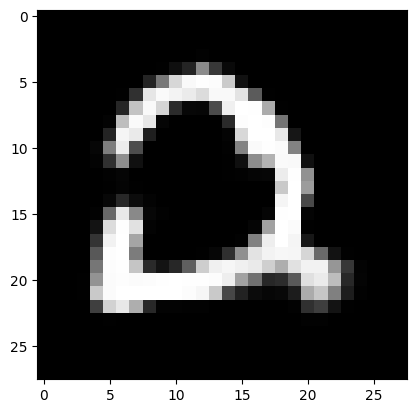

idx: 12562
2


In [33]:
import random
for _ in range(10):
  idx = random.randint(0, 18600)
  img = Server.x_public[idx]
  plt.imshow(img, cmap='gray')
  plt.show()
  print('idx:', idx)
  print(Server.y_public[idx])

In [37]:
def print_dist(y_train, name):
  unique, counts = np.unique(y_train, return_counts=True)
  label_distribution = dict(zip(unique, counts))
  # Print the label distribution
  print("Label Distribution in Training Set ", name, ":")
  for label, count in label_distribution.items():
      print(f"Label {label}: {count} instances")

In [38]:
print_dist(Server.y_public, 'server')

Label Distribution in Training Set  server :
Label -1858536816: 55 instances
Label -1858536800: 55 instances
Label -1840363480: 55 instances
Label -1840270120: 110 instances
Label -1705265690: 1 instances
Label -1622705402: 1 instances
Label -780436128: 2 instances
Label 0: 2852 instances
Label 1: 1753 instances
Label 2: 1683 instances
Label 3: 1681 instances
Label 4: 1692 instances
Label 5: 1699 instances
Label 6: 1659 instances
Label 7: 1664 instances
Label 8: 1656 instances
Label 9: 1682 instances
Label 48: 1 instances
Label 64: 1 instances
Label 96: 1 instances
Label 110: 1 instances
Label 128: 1 instances
Label 145: 1 instances
Label 1920: 1 instances
Label 1968: 1 instances
Label 23619: 3 instances
Label 23622: 2 instances
Label 31166: 277 instances
Label 791689835: 1 instances
Label 809132387: 1 instances
Label 1439341552: 1 instances
Label 1439350064: 1 instances
Label 1671954848: 1 instances
Label 1768383842: 1 instances
Label 1768714341: 1 instances
Label 1869114465: 1 instan

In [39]:
pseudo_labels = np.repeat(np.arange(10), int(100))
print(pseudo_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4 4 4 

In [43]:
type(pseudo_labels[0])

numpy.int64

In [48]:
print(x_train.dtype)
print(y_train.dtype)

float32
uint8


# TODO list:
- add wandb to the training steps to record metrics
- tune the parameters to achieve better performances

numbers to consider:

number of rounds of training

compare:
using logits or feature map output ie layer[-2]


- set up homogeneous experiments
- set up heterogenous experiments